In [1]:
import pandas as pd ## need pandas 1.5.0 a less
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from glob import glob


os.chdir('/data/cephfs-2/unmirrored/groups/ag-kircher/MisLa/MisLaReview')

import seaborn as sns


zero = sns.color_palette("Set2", 8)[0]
one = sns.color_palette("Set2", 8)[1]
two = sns.color_palette("Set2", 8)[2]

pd.set_option('display.max_columns', 140)
pd.set_option('display.max_rows', 300)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

sns.set_palette(sns.color_palette("Set2")[:]+pd.Series(sns.color_palette("Paired"))[[0,6,8]].to_list())
sns.color_palette()

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
 (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098)]

### Load data

In [113]:
imps = ['Python','CleanLab','R', 'DNN']

COLS = ["Index","Status","True Positive","False Positive", "True Negative", "False Negative", "Execution Time","Precision","Recall",
"F-score", "Extra Info"] #	NoiseInd	FoundNoiseInd	Time


noiseType = ["Sym","Asym","Real"]


# without ClinVar
datasets = ["Adult","DryBean","Chess","Magic", "RNA0", "RNA1", "RNA2",
           "HEPMASS","Pokerhand", "IFD"]

#datasets = ['ClinVarReal']
#datasets = ['ClinVarRealPCA']
#imps = ['DNN']

dfs = pd.DataFrame()
for imp in imps:
    #print(imp)
    for name in datasets[:]:

       # print(name)
        file='output/'+name+'_'+imp+'.csv'
       # print(file)
        df_raw = pd.read_csv(file, sep = '\t',header = None)
        df = df_raw.copy()
        #display(df.head())
        df[0] = df[0].str.replace('\'','')
        df.columns = COLS
        cols = ['Dataset','Model','NoiseLevel','NoiseType','DatasetSize', 'Sample']
        df[cols] = df['Index'].str.replace(' ','').str.split('\[|]|,',expand= True).iloc[:,1:-1]
        dfs = pd.concat([dfs,df],axis = 0)
        #dfs = dfs.append(df)

print(dfs.shape)
dfs_raw = dfs  

# drop all failed runs
dfs  = dfs[dfs['Status']!='F']
#dfs  = dfs[dfs['Status']!='N']
dfs = dfs[~dfs['True Positive'].isna()]

if ['ClinVarRealPCA'] == datasets:
    b = 'ClinVar'
    dfs = dfs[dfs['DatasetSize']=='1000000']
    dfs['NoiseLevel'] = 0.046
    dfs['DatasetSize'] = dfs['True Positive']+dfs['False Positive']+dfs['True Negative']+dfs['False Negative']
else:
    b = 'NoiseMax05_woClinVar'
    dfs = dfs[dfs['DatasetSize']!='1000000']
    dfs = dfs[dfs['NoiseLevel'].astype(float)>0]
    dfs = dfs[dfs['NoiseLevel'].astype(float)<=0.5]


# drop Encode dataset and AE model
dfs = dfs[~dfs['Dataset'].isin(['EncodeReal','EncodeArt'])]
dfs = dfs[~dfs['Model'].isin(['AE'])]


print(dfs.shape)


dfs = dfs.reset_index(drop = True)
print('Number of unique models in the dataset:', len(dfs['Model'].unique()))


small_samples = False

(450872, 17)
(276716, 17)
Number of unique models in the dataset: 37


In [114]:
dfs['DatasetSize'].value_counts()

100      44863
500      44604
300      44477
1000     37475
3000     36861
5000     34232
10000    34204
Name: DatasetSize, dtype: int64

In [115]:
dfs['Model'].value_counts().sort_index()

AENN                       14130
BBNR                       11240
C45iteratedVotingFilter    11452
C45robustFilter            11040
C45votingFilter            11241
CNN                        11024
CVCF                       11169
CleanLab                   14171
DROP1                        990
DROP2                        812
DROP3                       1001
EF                          9402
ENG                          906
ENN                         9455
ERL                        14530
EWF                          910
FKDN                       14223
GE                          4741
HARF                       11117
IH                         14062
INFFC                        884
IPF                        11180
KDN                        14316
MCS                        14363
ModeFilter                   946
ORBoostFilter              10639
PD                         14174
PRISM                        555
RFD                        14311
RNN                         1160
RkDN      

In [5]:
#dfs[(dfs['DatasetSize']=='10000')&(dfs['Dataset']=='Magic')].groupby('Model')['Execution Time'].mean()

In [ ]:
#dfs['Extra Info'].value_counts()

In [ ]:
#dfs['Model'].value_counts()

### Selection 

Selection of ilters is done in incremental manner: first run all filter for 100 and 300 samples, and only if the filter runs without errors and in reasonal time, continue with 500, 1000 etc. Thus, some filters have implementation errors either on all datasets or on one (eg. Adult):
- PF:  Error in `.rowNamesDF<-`(x, value = value) : invalid 'row.names' length
- dynamicCF: Error in eval(predvars, data, env) : object '0' not found
- consensusSF: Error in cove[indMax[1], indMax[2], ] : incorrect number of dimensions
- PRIMS: Error in if (cld(i, x, classColumn) >= 0) { :  missing value where TRUE/FALSE needed
- edgeBoostFilter: java memory error for n > 5000 (is included!)
- GE 
- EN

For last two filters, most of the runs are with no found noisy instance 

These filters are dropped after 300 datapoints:
- classifES
- saturationFilter

These filters are dropped after 500 datapoints:
- ENG
- EWF

These filters are dropped after 1000 datapoints:
- DROP1
- DROP2
- INFFC

These filters are dropped after 3000 datapoints:
- DROP3
- modeFilter

These filters are dropped after 10000 datapoints (non after 5000):
- hybridRF
- RNN

So, 18 filters dropped, 12 are left from the R package

In [5]:
# select the rows with benchmarking runs
df3 = dfs[dfs['Extra Info'].str.contains('BechmarkRNA|BenchmarkRNA', na = False)]
df3['DatasetSize'] = df3['DatasetSize'].astype(int)
cols = ['Execution Time', 'Precision', 'Recall', 'F-score', 'DatasetSize', 'Model']

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_706508/2287928635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['DatasetSize'] = df3['DatasetSize'].astype(int)


In [6]:
a = df3[cols].groupby(['Model','DatasetSize']).mean().reset_index()
aa = a.pivot(values = 'Execution Time', columns = 'DatasetSize', index = 'Model' ).sort_values('Model',key=lambda col: col.str.lower()).round(1)
aa/3600

DatasetSize              100    300    500    1000   3000   5000   10000
Model                                                                   
AENN                     0.003  0.004  0.009  0.014  0.099  0.239  0.835
BBNR                     0.001  0.002  0.003  0.007  0.032  0.074  0.260
C45iteratedVotingFilter  0.002  0.003  0.002  0.003  0.005  0.009  0.016
C45robustFilter          0.002  0.002  0.001  0.002  0.002  0.002  0.004
C45votingFilter          0.001  0.002  0.002  0.002  0.002  0.002  0.003
classifSF                0.145  4.185 31.232    NaN    NaN    NaN    NaN
CleanLab                 0.000  0.000  0.000  0.000  0.000  0.000  0.000
CNN                      0.002  0.004  0.006  0.011  0.039  0.079  0.358
CVCF                     0.002  0.002  0.001  0.001  0.003  0.002  0.003
DROP1                    0.029  0.146  0.680  2.097    NaN    NaN    NaN
DROP2                    0.045  0.387  0.697  4.447    NaN    NaN    NaN
DROP3                    0.011  0.092  0.298  1.104 13.970    NaN    NaN
edgeBoostFilter          0.007  0.013  0.019  0.023  0.051  0.091  0.192
EF                       0.002  0.001  0.002  0.002  0.002  0.004  0.007
ENG                      0.290  4.204  9.873    NaN    NaN    NaN    NaN
ENN                      0.002  0.002  0.004  0.007  0.022  0.078  0.246
ERL                      0.003  0.004  0.003  0.007  0.005  0.007  0.025
EWF                      0.477  3.782  9.492 47.251    NaN    NaN    NaN
FKDN                     0.000  0.000  0.000  0.000  0.000  0.001  0.003
GE                       0.001  0.001  0.001  0.001  0.001    NaN    NaN
HARF                     0.001  0.001  0.002  0.002  0.005  0.010  0.022
hybridRepairFilter       0.003  0.010  0.017  0.044  0.129  0.324  1.265
IH                       0.000  0.000  0.000  0.000  0.000  0.001  0.001
INFFC                    0.008  0.074  0.352  1.174 28.561    NaN    NaN
IPF                      0.003  0.003  0.002  0.002  0.004  0.002  0.003
KDN                      0.000  0.000  0.000  0.000  0.000  0.000  0.000
MCS                      0.000  0.000  0.000  0.000  0.000  0.000  0.000
ModeFilter               0.018  0.112  0.420  1.677 11.963    NaN    NaN
ORBoostFilter            0.001  0.002  0.002  0.003  0.011  0.008  0.015
PD                       0.000  0.000  0.000  0.000  0.000  0.000  0.000
PRISM                    0.002  0.007  0.017  0.065  0.602    NaN    NaN
RFD                      0.000  0.000  0.000  0.000  0.000  0.001  0.002
RkDN                     0.000  0.000  0.000  0.000  0.000  0.000  0.000
RNN                      0.002  0.004  0.010  0.019  0.163  0.694  2.716
saturationFilter         0.052  3.216 37.411    NaN    NaN    NaN    NaN
TomekLinks               0.001  0.005  0.030  0.214  3.451 26.800    NaN

### Selection with snakemake benchmark

#### create latex tables

In [84]:
# drop these as they do not run or do not find noise at all
# to_drop =  ['classifSF' , 'hybridRepairFilter','saturationFilter', 'PF', 'dynamicCF','consensusSF', 'GE']
to_drop =  ['hybridRepairFilter', 'PF', 'dynamicCF','consensusSF', 'GE']


In [8]:
li = glob('benchmarks/RNA*.tsv')
#li = glob('benchmarks/ClinVarRealPCA*.tsv')

df = pd.DataFrame()
for l in li:
    temp = pd.read_csv(l,sep = '\t')
    temp.index = [l]*len(temp)
    df = pd.concat([df,temp])
    #display(temp)
    #print(df.shape)
li  =pd.Series(df.index).str.split('/',expand = True)[1].str.split('_',expand = True).iloc[:,:5]
df = df.reset_index(drop = True)
cols = ['SampleSize', 'Model']
df[cols] = li[[2,4]]
df['SampleSize'] = df['SampleSize'].astype(int)
print(len(df['Model'].unique()))
# drop filters with errors (snakemake runs it anyways because 
# the script does not throws an error but tries and excepts)
print('Dropping filters', to_drop)
df = df[~df['Model'].isin(to_drop)]
print(len(df['Model'].unique()))
print(df['Model'].unique())
df['s'] = df['s']/60
df['cpu_time'] = df['cpu_time']/60

# group by sample size and calcualte the mean


to_replace = {'C45votingFilter':'C45vF',
'C45robustFilter':'C45rF',
'C45iteratedVotingFilter':'C45itF',
'ORBoostFilter':'ORBF',
             'hybridRepairFilter':'hybridRF',
             'edgeBoostFilter':'edgeBF'}
df['Model'] =  df['Model'].replace(to_replace)
a = df.groupby(cols).sample(n = 5).groupby(cols).mean().reset_index()
a['SampleSize'] = a['SampleSize'].astype(int)

38
Dropping filters ['hybridRepairFilter', 'PF', 'dynamicCF', 'consensusSF', 'GE']
34
['PRISM' 'DROP1' 'C45robustFilter' 'C45votingFilter' 'MCS' 'ENN' 'DROP2'
 'C45iteratedVotingFilter' 'FKDN' 'ERL' 'INFFC' 'EWF' 'PD' 'CleanLab'
 'AENN' 'IH' 'RFD' 'BBNR' 'RNN' 'ModeFilter' 'IPF' 'CVCF' 'HARF' 'RkDN'
 'ENG' 'CNN' 'ORBoostFilter' 'saturationFilter' 'DROP3' 'KDN' 'EF'
 'edgeBoostFilter' 'TomekLinks' 'classifSF']


/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_706508/1464559251.py:36: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  a = df.groupby(cols).sample(n = 5).groupby(cols).mean().reset_index()


In [9]:



di = {'max_rss':['Memory',0,1],
     'cpu_time':['RunningTime', 2,1]}
values = ['max_rss','cpu_time']
for value in values:
    repl = di[value][0]
    mean_dig = di[value][1]
    std_dig = di[value][2]
    std = df.groupby(cols).std().reset_index()
    std_sn = std.pivot(values = value, columns = 'SampleSize', index = 'Model' )#.sort_values('Model',key=lambda col: col.str.lower())
    b = "{0:.9f}".replace('9',str(std_dig))
    std_sn = std_sn.apply(lambda x:x.round(2).apply(b.format).astype(str))

    aa_sn = a.pivot(values = value, columns = 'SampleSize', index = 'Model' )#.sort_values('Model',key=lambda col: col.str.lower()).round(1)
   # aa_sn = aa_sn.sort_values([100, 300, 500, 1000, 3000, 5000, 10000], ascending = True)
    aa_sn = aa_sn.sort_values('Model', ascending = True)
    b = "{0:.9f}".replace('9',str(mean_dig))

    aa_sn = aa_sn.apply(lambda x:x.round(2).apply(b.format).astype(str))

    for col in aa_sn.columns:
        for i in aa_sn.index:
            if aa_sn.loc[i,col]!='nan':
                aa_sn.loc[i,col] = aa_sn.loc[i,col]+'$\pm$ ' +std_sn.loc[i,col]
    aa_sn = aa_sn.replace('nan','-')
    aa_sn = aa_sn.sort_values('Model', ascending = True,key=lambda col: col.str.lower())
    #aa_sn.to_latex('tablesNew/'+repl+'.tex',escape=False, bold_rows = True)
    display(aa_sn)

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_706508/874092271.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std = df.groupby(cols).std().reset_index()


SampleSize                   100              300              500    \
Model                                                                  
AENN                 804$\pm$ 48.5    719$\pm$ 51.0    729$\pm$ 78.7   
BBNR                677$\pm$ 235.9   673$\pm$ 223.3   701$\pm$ 139.1   
C45itF               751$\pm$ 88.6    617$\pm$ 69.7   957$\pm$ 217.7   
C45rF               693$\pm$ 251.2   730$\pm$ 268.4   804$\pm$ 199.6   
C45vF               650$\pm$ 234.3    678$\pm$ 82.7   695$\pm$ 316.0   
classifSF           1035$\pm$ 27.8   2901$\pm$ 92.1                -   
CleanLab             555$\pm$ 74.5    569$\pm$ 25.6    556$\pm$ 75.9   
CNN                 696$\pm$ 241.2   728$\pm$ 196.7     843$\pm$ 0.2   
CVCF                 767$\pm$ 72.2    793$\pm$ 70.8     887$\pm$ 1.0   
DROP1                 837$\pm$ 0.4     841$\pm$ 0.2     822$\pm$ 5.9   
DROP2                 838$\pm$ 0.7     842$\pm$ 1.1     814$\pm$ 3.6   
DROP3                 833$\pm$ 0.3     845$\pm$ 1.0     841$\pm$ 1.1   
edgeBF            2583$\pm$ 1228.2  2991$\pm$ 191.0  4061$\pm$ 602.0   
EF                    915$\pm$ 0.6    891$\pm$ 77.4   801$\pm$ 126.6   
ENG                   803$\pm$ 0.1     804$\pm$ 0.1     804$\pm$ 0.1   
ENN                  812$\pm$ 50.0    771$\pm$ 27.0     762$\pm$ 1.7   
ERL                 529$\pm$ 149.0     598$\pm$ 1.7    577$\pm$ 36.0   
EWF                   804$\pm$ 0.3     804$\pm$ 0.6     807$\pm$ 1.8   
FKDN                 556$\pm$ 71.5   506$\pm$ 128.6     589$\pm$ 2.4   
HARF                 732$\pm$ 42.8    735$\pm$ 51.7     768$\pm$ 5.1   
IH                   557$\pm$ 69.7   509$\pm$ 129.7    569$\pm$ 26.0   
INFFC               786$\pm$ 142.4     919$\pm$ 2.2     932$\pm$ 4.3   
IPF                  883$\pm$ 90.4    975$\pm$ 39.2    901$\pm$ 34.0   
KDN                  544$\pm$ 79.1     591$\pm$ 3.1   514$\pm$ 106.5   
MCS                 498$\pm$ 128.7    552$\pm$ 82.0    552$\pm$ 88.0   
ModeFilter            803$\pm$ 0.2     804$\pm$ 0.2     805$\pm$ 0.1   
ORBF                660$\pm$ 133.6   605$\pm$ 250.5    713$\pm$ 71.2   
PD                   557$\pm$ 69.5   508$\pm$ 130.2     589$\pm$ 2.5   
PRISM                 930$\pm$ 1.3  1007$\pm$ 172.6    1127$\pm$ 4.9   
RFD                 498$\pm$ 129.2    551$\pm$ 81.5   514$\pm$ 106.9   
RkDN                  592$\pm$ 0.9    545$\pm$ 79.4    564$\pm$ 51.9   
RNN                  802$\pm$ 45.0   779$\pm$ 108.4     847$\pm$ 0.5   
saturationFilter      953$\pm$ 9.6   4507$\pm$ 83.2                -   
TomekLinks          714$\pm$ 101.9   702$\pm$ 124.7     758$\pm$ 0.5   

SampleSize                    1000             3000             5000   \
Model                                                                   
AENN                   763$\pm$ 0.2     784$\pm$ 0.6     807$\pm$ 0.7   
BBNR                  753$\pm$ 16.3     784$\pm$ 0.9    822$\pm$ 30.1   
C45itF               743$\pm$ 102.1   920$\pm$ 311.7  1298$\pm$ 256.2   
C45rF                 834$\pm$ 21.0   962$\pm$ 518.3    796$\pm$ 56.5   
C45vF                761$\pm$ 162.6    790$\pm$ 51.0   572$\pm$ 215.1   
classifSF                         -                -                -   
CleanLab             521$\pm$ 159.2     588$\pm$ 2.6    553$\pm$ 82.0   
CNN                    842$\pm$ 0.1     867$\pm$ 2.2     870$\pm$ 5.7   
CVCF                  922$\pm$ 12.2   957$\pm$ 290.1    842$\pm$ 21.0   
DROP1                  789$\pm$ 3.9                -                -   
DROP2                  777$\pm$ 2.0                -                -   
DROP3                 803$\pm$ 10.4     790$\pm$ 3.8                -   
edgeBF            10363$\pm$ 4197.7                -                -   
EF                   641$\pm$ 302.2   985$\pm$ 269.2  1003$\pm$ 321.1   
ENG                               -                -                -   
ENN                    762$\pm$ 1.2     782$\pm$ 0.3     807$\pm$ 1.0   
ERL                    593$\pm$ 2.9     595$\pm$ 2.4     595$\pm$ 1.8   
EWF                 

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_706508/874092271.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std = df.groupby(cols).std().reset_index()


SampleSize                 100               300                500    \
Model                                                                   
AENN               0.21$\pm$ 0.0     0.25$\pm$ 0.1      0.21$\pm$ 0.1   
BBNR               0.14$\pm$ 0.1     0.18$\pm$ 0.1      0.19$\pm$ 0.1   
C45itF             0.21$\pm$ 0.0     0.20$\pm$ 0.0      0.21$\pm$ 0.1   
C45rF              0.15$\pm$ 0.1     0.17$\pm$ 0.1      0.19$\pm$ 0.1   
C45vF              0.13$\pm$ 0.1     0.22$\pm$ 0.0      0.15$\pm$ 0.1   
classifSF          7.70$\pm$ 3.1  369.95$\pm$ 15.2                  -   
CleanLab           0.10$\pm$ 0.0     0.15$\pm$ 0.0      0.10$\pm$ 0.0   
CNN                0.16$\pm$ 0.1     0.19$\pm$ 0.1      0.22$\pm$ 0.0   
CVCF               0.21$\pm$ 0.0     0.22$\pm$ 0.0      0.19$\pm$ 0.0   
DROP1              0.87$\pm$ 0.2     7.79$\pm$ 0.3     42.25$\pm$ 1.2   
DROP2              2.71$\pm$ 0.1    23.21$\pm$ 0.1     45.33$\pm$ 1.8   
DROP3              0.73$\pm$ 0.0     6.31$\pm$ 0.8     16.28$\pm$ 1.2   
edgeBF             0.65$\pm$ 0.3     0.87$\pm$ 0.2      1.81$\pm$ 0.3   
EF                 0.18$\pm$ 0.0     0.19$\pm$ 0.0      0.23$\pm$ 0.1   
ENG               19.16$\pm$ 2.7  329.56$\pm$ 41.2  959.23$\pm$ 154.6   
ENN                0.22$\pm$ 0.0     0.22$\pm$ 0.0      0.23$\pm$ 0.0   
ERL                0.17$\pm$ 0.1     0.21$\pm$ 0.0      0.19$\pm$ 0.1   
EWF               29.91$\pm$ 5.3  222.21$\pm$ 24.0  1007.29$\pm$ 64.0   
FKDN               0.15$\pm$ 0.0     0.15$\pm$ 0.1      0.15$\pm$ 0.0   
HARF               0.20$\pm$ 0.0     0.15$\pm$ 0.0      0.21$\pm$ 0.0   
IH                 0.14$\pm$ 0.0     0.15$\pm$ 0.1      0.15$\pm$ 0.0   
INFFC              0.18$\pm$ 0.1     3.07$\pm$ 0.3     21.24$\pm$ 2.3   
IPF                0.22$\pm$ 0.1     0.23$\pm$ 0.0      0.25$\pm$ 0.0   
KDN                0.14$\pm$ 0.0     0.16$\pm$ 0.0      0.14$\pm$ 0.0   
MCS                0.10$\pm$ 0.0     0.14$\pm$ 0.0      0.11$\pm$ 0.0   
ModeFilter         1.22$\pm$ 0.1     9.64$\pm$ 0.1     17.01$\pm$ 0.4   
ORBF               0.19$\pm$ 0.1     0.14$\pm$ 0.1      0.19$\pm$ 0.0   
PD                 0.14$\pm$ 0.0     0.14$\pm$ 0.1      0.15$\pm$ 0.0   
PRISM              0.23$\pm$ 0.0     0.56$\pm$ 0.3      1.49$\pm$ 0.3   
RFD                0.09$\pm$ 0.0     0.14$\pm$ 0.0      0.14$\pm$ 0.0   
RkDN               0.11$\pm$ 0.0     0.14$\pm$ 0.0      0.13$\pm$ 0.0   
RNN                0.23$\pm$ 0.0     0.22$\pm$ 0.0      0.68$\pm$ 0.1   
saturationFilter   2.61$\pm$ 0.4  193.71$\pm$ 15.1                  -   
TomekLinks         0.15$\pm$ 0.0     0.18$\pm$ 0.1      0.89$\pm$ 0.2   

SampleSize                  1000              3000              5000   \
Model                                                                   
AENN                0.73$\pm$ 0.0     6.67$\pm$ 0.5    14.88$\pm$ 0.3   
BBNR                0.22$\pm$ 0.0     1.20$\pm$ 0.0     3.70$\pm$ 0.1   
C45itF              0.20$\pm$ 0.0     0.32$\pm$ 0.2     0.65$\pm$ 0.2   
C45rF               0.24$\pm$ 0.0     0.18$\pm$ 0.1     0.22$\pm$ 0.0   
C45vF               0.22$\pm$ 0.1     0.22$\pm$ 0.0     0.16$\pm$ 0.1   
classifSF                       -                 -                 -   
CleanLab            0.12$\pm$ 0.1     0.16$\pm$ 0.0     0.14$\pm$ 0.0   
CNN                 0.73$\pm$ 0.0     2.13$\pm$ 0.2     5.12$\pm$ 0.9   
CVCF                0.24$\pm$ 0.0     0.17$\pm$ 0.1     0.25$\pm$ 0.0   
DROP1             120.72$\pm$ 2.3                 -                 -   
DROP2             213.62$\pm$ 3.8                 -                 -   
DROP3              65.59$\pm$ 7.8  847.80$\pm$ 81.8                 -   
edgeBF              1.71$\pm$ 0.2                 -                 -   
EF                  0.13$\pm$ 0.1     0.21$\pm$ 0.1     0.22$\pm$ 0.1   
ENG                             -                 -                 -   
ENN                 0.22$\pm$ 0.0     1.23$\pm$ 0.0     3.48$\pm$ 0.1   
ERL                 0.23$\pm$ 0.0     0.64$\pm$ 0.2     0

#### plot the figure

In [14]:
models = pd.Series(df['Model'].unique()).sort_values(ascending = True,key=lambda col: col.str.lower())


In [28]:
# models = models[models!='edgeBF']

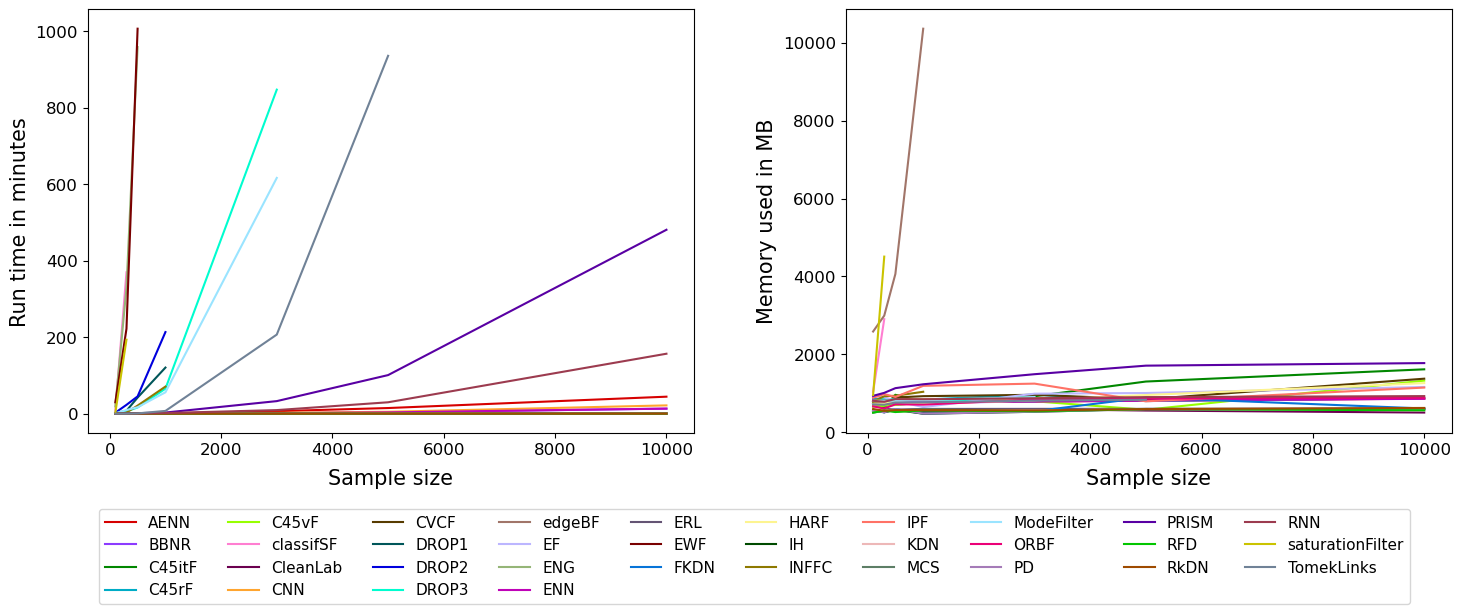

In [15]:
import colorcet as cc

#sns.set_palette(sns.color_palette('tab20b')+sns.color_palette('tab20c'))
sns.color_palette(cc.glasbey, n_colors=32)
current_palette = sns.color_palette(cc.glasbey, n_colors=34)
b = 'NoiseMax05_woClinVar'

n = 1.1

di = {'cpu_time':'Run time in minutes',
     'max_rss':'Memory used in MB'}
models = pd.Series(a['Model'].unique()).sort_values(ascending = True,key=lambda col: col.str.lower())
fig, axs = plt.subplots(1,2,figsize=(16*n,5*n))
#models = models[models!='edgeBF']
for i, c in enumerate(['cpu_time','max_rss']):
    for j, model in enumerate(models[:]):
        temp = a[a['Model']==model][['SampleSize',c,]]#
        axs[i].plot(temp['SampleSize'], temp[c],label = model, color = current_palette[j])
        axs[i].set_ylabel(di[c], fontsize = 15)
        axs[i].set_xlabel('Sample size',fontsize = 15, labelpad = 8)
        
        if i ==1:
            axs[i].legend(bbox_to_anchor=(-0.15, -0.44,0,0), loc='lower center'
                                                          ,borderaxespad=1,
                          fancybox=True, shadow=False, ncol=10, fontsize = 11)
      #  fig.tight_layout(pad= 0)
        axs[i].tick_params(axis='both', labelsize=12)
        #axs[i].set_ylim(0,2000)

    plt.subplots_adjust(hspace = 0.1, wspace =0.25)

    name = 'selection_'+b+'.jpeg'
    #plt.savefig('figuresNew/'+name,transparent=False,bbox_inches = 'tight', dpi = 300)





### Prepare the dataset

In [100]:
# rename some models (to names in the snakemake workflow)
to_replace = {'C45votingFilter':'C45vF',
                'C45robustFilter':'C45rF',
                'C45iteratedVotingFilter':'C45itF',
                'ORBoostFilter':'ORBF',
             'hybridRepairFilter' : 'hybridRF',
             'edgeBoostFilter' : 'edgeBF',
             'ERL':'ELR'}
dfs['Model'] =  dfs['Model'].replace(to_replace)

dfs['Model'].value_counts().index


Index(['ELR', 'MCS', 'KDN', 'RFD', 'FKDN', 'PD', 'CleanLab', 'AENN', 'RkDN',
       'IH', 'C45itF', 'C45vF', 'BBNR', 'IPF', 'CVCF', 'HARF', 'C45rF', 'CNN',
       'ORBF', 'ENN', 'EF', 'GE', 'RNN', 'DROP3', 'DROP1', 'edgeBF',
       'ModeFilter', 'EWF', 'ENG', 'INFFC', 'DROP2', 'TomekLinks', 'PRISM',
       'saturationFilter', 'classifSF', 'hybridRF', 'consensusSF'],
      dtype='object')

In [101]:
usedModels = dfs['Model'].unique()

# define the list of valid models either this way
models = ['ELR', 'AENN', 'IH', 'PD', 'RFD', 'MCS', 'CleanLab', 'KDN', 'RkDN',
       'FKDN', 'C45itF', 'CVCF', 'C45vF', 'IPF', 'C45rF', 'CNN', 'HARF',
       'BBNR', 'ORBF', 'ENN',
      #  'DROP1','DROP2','DROP3','ENG','EWF',  'INFFC', 'ModeFilter', 'RNN', 'TomekLinks', 'PRISM', 'GE'
         ]

# or this way

# models_drop = ['classifSF' , 'hybridRF','saturationFilter', 'PF', 'dynamicCF','consensusSF', 'GE']

models_drop = [ 'hybridRF', 'PF', 'dynamicCF', 'GE','consensusSF']

models_slow = [ 'DROP1','DROP2','DROP3','ENG','EWF',  'INFFC', 'ModeFilter', 'RNN', 
               'TomekLinks', 'PRISM', 'edgeBF', 'EF', 'saturationFilter', 'classifSF']

models_all = pd.Series(dfs['Model'].unique())
models = models_all[~models_all.isin(models_drop)]

if not small_samples:
    models = models[~models.isin(models_slow)].to_list()

print(len(models))

print(set(usedModels)- set(usedModels).intersection(set(models)))
dfs = dfs[dfs['Model'].isin(models)].reset_index(drop = True)
print(dfs['Model'].unique().shape)



## read in the model file 

mod = pd.read_csv('configs/models.txt',sep = '\t')
groups = ['Similarity','Ensemble','Single']
mod['Abbreviation'] = mod['Abbreviation'].replace(to_replace)

#drop = ['saturationFilter', 'classifSF', 'DROP1', 'DROP2',
#                                 'DROP3', 'EWF', 'TomekLinks','consensusSF','INFFC','ModeFilter', 'ENG','edgeBoostFilter']
#mod = mod[~mod['Abbreviation'].isin(drop)]
mod = mod[mod['Abbreviation'].isin(models)]

di = mod[['Abbreviation','Group']].set_index('Abbreviation').to_dict()['Group']

dfs['Group'] = dfs['Model']
dfs['Group'] = dfs['Group'].replace(di)
print(dfs['Group'].value_counts())


## add the implementaion dictionary for models
repl = {'Tensorflow':'DNN',
'GitHub':'DNN' ,
'Scikit-Clean':'Python',
'NoiseFiltersR':'R'}
mod['Implementation'] = mod['Package'].replace(repl)
repl = mod[['Abbreviation','Implementation']].set_index('Abbreviation').to_dict()['Implementation']



dfs['Model'].value_counts()

34
{'GE', 'consensusSF', 'hybridRF'}
(34,)
Ensemble      119631
Similarity     97357
Single         54886
Name: Group, dtype: int64


ELR                 14530
MCS                 14363
KDN                 14316
RFD                 14311
FKDN                14223
PD                  14174
CleanLab            14171
AENN                14130
RkDN                14064
IH                  14062
C45itF              11452
C45vF               11241
BBNR                11240
IPF                 11180
CVCF                11169
HARF                11117
C45rF               11040
CNN                 11024
ORBF                10639
ENN                  9455
EF                   9402
RNN                  1160
DROP3                1001
DROP1                 990
edgeBF                985
ModeFilter            946
EWF                   910
ENG                   906
INFFC                 884
DROP2                 812
TomekLinks            640
PRISM                 555
saturationFilter      402
classifSF             380
Name: Model, dtype: int64

### Add new variables

In [102]:
# change for less memory requirements
cols = [ 'True Positive', 'False Positive', 'True Negative',
       'False Negative','DatasetSize','Sample']
dfs[cols] = dfs[cols].astype('int')
cols = ['Precision', 'Recall', 'F-score','NoiseLevel','Execution Time']
dfs[cols] = dfs[cols].astype('float')

## adding new columns
pon = 'Precision over Noise'
dfs[pon] = dfs['Precision']-dfs['NoiseLevel']
dfs['RecallOverNoise'] = dfs['Recall']-dfs['NoiseLevel']
n = dfs["True Positive"]+dfs['True Negative'] + dfs['False Positive'] + dfs['False Negative']
dfs['Accuracy'] =(dfs["True Positive"]+dfs['True Negative'])/n

#retrieved = 'Retrieved instances'
retrieved = 'Subjective Noise Level'

dfs[retrieved] = (dfs['True Positive'] + dfs['False Positive'])/n

# some extra metrics (were not used)

cost = 'Cost'
cost1 = 'Cost-mod'


dfs[cost] = dfs['False Positive']/(dfs['True Positive']+dfs['False Negative'])
dfs[cost] = dfs['False Positive']/(dfs['True Positive'])/dfs['NoiseLevel']
dfs[cost] = dfs[retrieved]/dfs['Recall']
dfs[cost1] = dfs[retrieved]/(dfs['Recall']*dfs['NoiseLevel'])


dfs.loc[dfs[cost]==np.inf,cost]=np.nan
dfs.loc[dfs[cost1]==np.inf,cost1]=np.nan



dfs['FPR'] = dfs['False Positive']/(dfs['False Positive']+dfs['True Negative'])
dfs['TPR'] = dfs['True Positive']/(dfs['True Positive']+dfs['False Positive'])

dfs['F-score-mod'] = dfs['F-score']/dfs['NoiseLevel']

dfs['PLR'] = dfs['TPR']/dfs['FPR']
dfs['PLR-Inv'] = dfs['FPR']/dfs['TPR']

for col in [cost, cost1, 'PLR', 'PLR-Inv']:
    dfs.loc[dfs[col]==np.inf,col]=np.nan

di_groups = {'Similarity':1, 'Ensemble':2, 'Single':3}    
dfs['GroupNum'] = dfs['Group'].replace(di_groups)


In [103]:
# sanity check (metrics max and min)
dfs.describe()

True Positive  False Positive  True Negative  False Negative  \
count     271874.000      271874.000     271874.000      271874.000   
mean         408.124         514.244       1362.553         248.513   
std          720.039         876.430       1931.460         521.399   
min            0.000           0.000          0.000           0.000   
25%           24.000          34.000        137.000          13.000   
50%           97.000         129.000        385.000          52.000   
75%          434.000         608.000       1980.000         205.000   
max         5000.000        9500.000       9500.000        5000.000   

       Execution Time  Precision     Recall    F-score  NoiseLevel  \
count      271874.000 271874.000 271874.000 271874.000  271874.000   
mean          201.441      0.433      0.610      0.456       0.260   
std          2963.827      0.249      0.268      0.232       0.157   
min             0.003      0.000      0.000      0.000       0.050   
25%             0.304      0.222      0.450      0.283       0.100   
50%             2.025      0.443      0.640      0.473       0.300   
75%             8.826      0.603      0.810      0.617       0.400   
max        475534.290      1.000      1.000      1.000       0.500   

       DatasetSize     Sample  Precision over Noise  RecallOverNoise  \
count   271874.000 271874.000            271874.000       271874.000   
mean      2533.434      2.453                 0.173            0.350   
std       3227.177      2.585                 0.211            0.329   
min        100.000      0.000                -0.500           -0.500   
25%        300.000      0.000                 0.033            0.120   
50%       1000.000      2.000                 0.133            0.372   
75%       3000.000      4.000                 0.286            0.600   
max      10000.000      9.000                 0.950            0.950   

        Accuracy  Subjective Noise Level       Cost   Cost-mod        FPR  \
count 271874.000              271874.000 263431.000 263431.000 271874.000   
mean       0.683                   0.362      0.728      4.859      0.290   
std        0.166                   0.210      1.511     25.958      0.218   
min        0.050                   0.000      0.050      0.994      0.000   
25%        0.565                   0.216      0.406      1.639      0.122   
50%        0.691                   0.350      0.607      2.198      0.249   
75%        0.808                   0.477      0.843      4.052      0.424   
max        1.000                   1.000    187.900   3758.000      1.000   

             TPR  F-score-mod        PLR    PLR-Inv   GroupNum  
count 265057.000   271874.000 263539.000 263431.000 271874.000  
mean       0.444        2.596      9.972      2.076      1.844  
std        0.243        2.572     61.339     19.410      0.732  
min        0.000        0.000      0.000      0.000      1.000  
25%        0.242        1.293      0.685      0.263      1.000  
50%        0.453        1.835      1.484      0.662      2.000  
75%        0.609        2.966      3.702      1.425      2.000  
max        1.000       20.000   5913.043   2972.380      3.000

In [71]:
# check whether can sample 10 points for each run
# need to rerun those with less than 10 runs
cols = ['Model','Dataset', 'DatasetSize','NoiseType', 'NoiseLevel']
dfs.groupby(cols).count()[dfs.groupby(cols).count()['Index']<10]#.shape

Empty DataFrame
Columns: [Index, Status, True Positive, False Positive, True Negative, False Negative, Execution Time, Precision, Recall, F-score, Extra Info, Sample, Group, Precision over Noise, RecallOverNoise, Accuracy, Subjective Noise Level, Cost, Cost-mod, FPR, TPR, F-score-mod, PLR, PLR-Inv, GroupNum]
Index: []

In [72]:
## to have the save proportion of runs for all models
cols = ['Model','Dataset', 'DatasetSize','NoiseType', 'NoiseLevel']

dfs =  dfs.groupby(cols).sample(n = 10, replace = False,random_state = 1234)
dfs.groupby('Model').count()

Index  Status  True Positive  False Positive  True Negative  \
Model                                                                   
AENN       8400    8400           8400            8400           8400   
BBNR       8400    8400           8400            8400           8400   
C45itF     8400    8400           8400            8400           8400   
C45rF      8400    8400           8400            8400           8400   
C45vF      8400    8400           8400            8400           8400   
CNN        8400    8400           8400            8400           8400   
CVCF       8400    8400           8400            8400           8400   
CleanLab   8400    8400           8400            8400           8400   
ELR        8380    8380           8380            8380           8380   
ENN        8400    8400           8400            8400           8400   
FKDN       8400    8400           8400            8400           8400   
HARF       8400    8400           8400            8400           8400   
IH         8400    8400           8400            8400           8400   
IPF        8400    8400           8400            8400           8400   
KDN        8400    8400           8400            8400           8400   
MCS        8400    8400           8400            8400           8400   
ORBF       8400    8400           8400            8400           8400   
PD         8400    8400           8400            8400           8400   
RFD        8400    8400           8400            8400           8400   
RkDN       8400    8400           8400            8400           8400   

          False Negative  Execution Time  Precision  Recall  F-score  \
Model                                                                  
AENN                8400            8400       8400    8400     8400   
BBNR                8400            8400       8400    8400     8400   
C45itF              8400            8400       8400    8400     8400   
C45rF               8400            8400       8400    8400     8400   
C45vF               8400            8400       8400    8400     8400   
CNN                 8400            8400       8400    8400     8400   
CVCF                8400            8400       8400    8400     8400   
CleanLab            8400            8400       8400    8400     8400   
ELR                 8380            8380       8380    8380     8380   
ENN                 8400            8400       8400    8400     8400   
FKDN                8400            8400       8400    8400     8400   
HARF                8400            8400       8400    8400     8400   
IH                  8400            8400       8400    8400     8400   
IPF                 8400            8400       8400    8400     8400   
KDN                 8400            8400       8400    8400     8400   
MCS                 8400            8400       8400    8400     8400   
ORBF                8400            8400       8400    8400     8400   
PD                  8400            8400       8400    8400     8400   
RFD                 8400            8400       8400    8400     8400   
RkDN                8400            8400       8400    8400     8400   

          Extra Info  Dataset  NoiseLevel  NoiseType  DatasetSize  Sample  \
Model                                                                       
AENN             256     8400        8400       8400         8400    8400   
BBNR             408     8400        8400       8400         8400    8400   
C45itF           465     8400        8400       8400         8400    8400   
C45rF            285     8400        8400       8400         8400    8400   
C45vF            399     8400        8400       8400         8400    8400   
CNN              266     8400        8400       8400         8400    8400   
CVCF             334     8400        8400       8400         8400    8400   
CleanLab         283     8400        8400       8400         8400    8400   
ELR             8380     8380        8380       

### Create Latex Tables 

In [23]:
n = round(dfs['Model'].value_counts().mean())
df = pd.DataFrame(dfs[dfs['True Positive']!=0]['Model'].value_counts()/n)
df['Model'] =  (1- df['Model']).abs()
df = df.sort_values('Model',ascending = False)
df['Model'] =df['Model'].mul(100).astype(float).round(2).astype(str).add('%')
df = df.reset_index()

df.columns = ['Model','Ratio']
empty = df.iloc[:11,:].reset_index(drop = True)
empty['Model'] = ''
empty['Ratio'] = ''
df = pd.concat([df.iloc[:11,:].reset_index(drop = True), empty, empty,df.iloc[9:,:].reset_index(drop = True)], axis = 1)

#df.to_latex('tablesNew/ZeroPrecision_'+b+'.tex', index = False)
df

Model   Ratio Model Ratio Model Ratio     Model  Ratio
0     ORBF  49.89%                               IPF  0.15%
1     CVCF   4.04%                               MCS  0.11%
2      CNN   3.76%                          CleanLab  0.08%
3    C45vF   3.13%                                PD  0.07%
4   C45itF   1.43%                              BBNR  0.07%
5     HARF   0.88%                              RkDN  0.02%
6      ELR    0.8%                              AENN  0.02%
7    C45rF   0.75%                                IH  0.01%
8     FKDN   0.48%                               ENN  0.01%
9      IPF   0.15%                               KDN  0.01%
10     MCS   0.11%                               RFD   0.0%

In [24]:
df = pd.read_csv('dataProduced/ClinVarTwoLabelsJune23Sample.csv.gz', compression = 'zip',sep = '\t')
#df = df[~df['LabelNew'].str.contains('Conflicting')]
#df = df[~df['LabelOld'].str.contains('Conflicting')]
ct = pd.crosstab(df['LabelOld'], df['LabelNew'], margins = True)
ct = ct.apply(lambda x: '\num{' + x.astype(str)+'}')

#ct.to_latex('tablesNew/ClinvarLabelsCT.tex',escape=False)
ct

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_706508/620459994.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataProduced/ClinVarTwoLabelsJune23Sample.csv.gz', compression = 'zip',sep = '\t')


LabelNew          Benign    Pathogenic           VUS           All
LabelOld                                                          
Benign      \num{242314}      \num{42}    \num{1918}  \num{244274}
Pathogenic     \num{553}  \num{111338}    \num{4767}  \num{116658}
VUS          \num{22476}    \num{4731}  \num{361240}  \num{388447}
All         \num{265343}  \num{116111}  \num{367925}  \num{749379}

In [26]:
for score in ['Accuracy',pon,'Recall']:
    n = round(len(dfs)*0.7)
    li = []
    for i in range(100):
        dfs_sample = dfs.sample(n = n)
        a = dfs_sample.groupby(['NoiseLevel','Model'])[score].mean().reset_index()
        li.append(a[score])


    a[score] = pd.DataFrame(li).mean(axis = 0)
    a[score] = a[score].apply("{0:.3f}".format)
    a['Value'] = a['Model']+' (' + a[score].astype(str) + ')'

    alle = pd.DataFrame()
    for i in a['NoiseLevel'].unique():
        aa = a[a['NoiseLevel']==i].sort_values(score, ascending = False).reset_index(drop = True).reset_index()
        alle = pd.concat([alle, aa])
    alle = alle.rename(columns = {'index':'Rank'})
    alle = alle.pivot(values = 'Value',columns = 'NoiseLevel', index = 'Rank')#.to_csv('tables/precranks.csv',sep = '\t')
    alle.index = alle.index+1
    alle#.to_latex('tablesNew/Pivot_'+score.replace(' ','')+'_'+b+'.tex', index = True)

In [27]:
# this is not used in the paper
a = dfs[['Precision',pon,'Recall','F-score','NoiseLevel','NoiseType','DatasetSize',retrieved, 
         'PLR','PLR-Inv'  ]]

corr = a.corr().round(3)
corr.round(3)


di = {retrieved:'SNR',
     pon:'PON',
     'NoiseLevel':'Noise level',
     'DatasetSize':'Sample size'}
corr.columns = pd.Series(corr.columns).replace(di)
corr.index = pd.Series(corr.index).replace(di)
corr#.to_latex('tables/Correlation.tex', index = True)

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_706508/3189628925.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = a.corr().round(3)


Precision    PON  Recall  F-score  Noise level  Sample size  \
Precision        1.000  0.780   0.276    0.845        0.532        0.036   
PON              0.780  1.000   0.431    0.721       -0.115        0.042   
Recall           0.276  0.431   1.000    0.646       -0.145        0.103   
F-score          0.845  0.721   0.646    1.000        0.366        0.086   
Noise level      0.532 -0.115  -0.145    0.366        1.000        0.000   
Sample size      0.036  0.042   0.103    0.086        0.000        1.000   
SNR             -0.064 -0.288   0.501    0.183        0.289        0.017   
PLR              0.289  0.389   0.083    0.214       -0.040        0.053   
PLR-Inv         -0.125 -0.090  -0.089   -0.130       -0.079        0.015   

               SNR    PLR  PLR-Inv  
Precision   -0.064  0.289   -0.125  
PON         -0.288  0.389   -0.090  
Recall       0.501  0.083   -0.089  
F-score      0.183  0.214   -0.130  
Noise level  0.289 -0.040   -0.079  
Sample size  0.017  0.053    0.015  
SNR          1.000 -0.167    0.097  
PLR         -0.167  1.000   -0.015  
PLR-Inv      0.097 -0.015    1.000

In [50]:
# Not used in the paper

#https://stats.stackexchange.com/questions/239973/a-general-measure-of-data-set-imbalance
# shanon measure for balance in the dataset
# my own measure for disbalance is in varianble 'disbalance'
def balance(seq):
    from collections import Counter
    from numpy import log
    
    n = len(seq)
    classes = [(clas,float(count)) for clas,count in Counter(seq).items()]
    k = len(classes)
    
    H = -sum([ (count/n) * log((count/n)) for clas,count in classes]) #shannon entropy
    return H/log(k)


di_dataset_desc  ={}

for dataset in datasets[:]:

    
    df = pd.read_csv('datasets/'+dataset+'.csv.gz',sep = '\t', compression = 'zip')
    print(dataset, df.shape)
    print(df.iloc[:,-1].value_counts(normalize = True, sort = False).round(2).to_dict())
    n_classes = len(df['Label'].value_counts())
    n_features = df.shape[1]
    disbalance = 1 - ((df.iloc[:,-1].value_counts(normalize = True, sort = False).round(2)-1/n_classes)**2).sum() 
    shanon = balance(df['Label'])
    dataset_features = [n_classes,n_features, disbalance,shanon]
    dataset_features = '-'.join(list(map(str,dataset_features)))
    di_dataset_desc.update({dataset: dataset_features})

Adult (32561, 109)
{0: 0.76, 1: 0.24}
DryBean (13611, 17)
{0: 0.15, 1: 0.1, 2: 0.04, 3: 0.12, 4: 0.14, 5: 0.19, 6: 0.26}
Chess (25290, 24)
{0: 0.11, 1: 0.06, 2: 0.07, 3: 0.08, 4: 0.11, 5: 0.14, 6: 0.17, 7: 0.18, 8: 0.09}
Magic (19020, 11)
{0: 0.65, 1: 0.35}
RNA0 (15570, 51)
{0: 0.47, 1: 0.53}
RNA1 (19465, 51)
{0: 0.37, 1: 0.43, 2: 0.2}
RNA2 (22348, 51)
{0: 0.33, 1: 0.47, 2: 0.21}
HEPMASS (100000, 29)
{0.0: 0.5, 1.0: 0.5}
Pokerhand (25010, 11)
{0: 0.5, 1: 0.5}
IFD (65478, 12)
{0: 0.57, 1: 0.2, 2: 0.23}


In [52]:
# Not used in the paper

dfs['Dataset_Features'] = dfs['Dataset'].replace(di_dataset_desc)
dfs[['N_Classes','N_Features','Disbalance', 'Shanon']] = dfs['Dataset_Features'].str.split('-',expand = True).astype(float)

dfs[['Execution Time','Accuracy','Precision','Precision over Noise', 'Recall', 'F-score','NoiseLevel',
     'N_Features', 'Dataset_Features', 'N_Classes', 'Disbalance','Shanon']].corr(method = 'spearman')

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_706508/1996529156.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfs[['Execution Time','Accuracy','Precision','Precision over Noise', 'Recall', 'F-score','NoiseLevel',


Execution Time  Accuracy  Precision  \
Execution Time                 1.000     0.008     -0.065   
Accuracy                       0.008     1.000      0.367   
Precision                     -0.065     0.367      1.000   
Precision over Noise          -0.041     0.780      0.747   
Recall                        -0.154     0.233      0.228   
F-score                       -0.089     0.413      0.846   
NoiseLevel                    -0.003    -0.363      0.572   
N_Features                     0.161    -0.028     -0.062   
N_Classes                      0.053    -0.074      0.039   
Disbalance                    -0.032    -0.276     -0.235   
Shanon                        -0.031    -0.328     -0.281   

                      Precision over Noise  Recall  F-score  NoiseLevel  \
Execution Time                      -0.041  -0.154   -0.089      -0.003   
Accuracy                             0.780   0.233    0.413      -0.363   
Precision                            0.747   0.228    0.846       0.572   
Precision over Noise                 1.000   0.381    0.697      -0.033   
Recall                               0.381   1.000    0.578      -0.164   
F-score                              0.697   0.578    1.000       0.415   
NoiseLevel                          -0.033  -0.164    0.415       1.000   
N_Features                          -0.002  -0.056   -0.071      -0.000   
N_Classes                            0.004   0.441    0.173      -0.000   
Disbalance                          -0.310  -0.209   -0.277       0.000   
Shanon                              -0.373  -0.240   -0.321       0.000   

                      N_Features  N_Classes  Disbalance  Shanon  
Execution Time             0.161      0.053      -0.032  -0.031  
Accuracy                  -0.028     -0.074      -0.276  -0.328  
Precision                 -0.062      0.039      -0.235  -0.281  
Precision over Noise      -0.002      0.004      -0.310  -0.373  
Recall                    -0.056      0.441      -0.209  -0.240  
F-score                   -0.071      0.173      -0.277  -0.321  
NoiseLevel                -0.000     -0.000       0.000   0.000  
N_Features                 1.000     -0.033      -0.145  -0.123  
N_Classes                 -0.033      1.000      -0.138  -0.164  
Disbalance                -0.145     -0.138       1.000   0.985  
Shanon                    -0.123     -0.164       0.985   1.000

#### Save dataset desciptions into a file


In [ ]:
# dont run
#datasets = ["RNA0", "RNA1", "RNA2"]

#for dataset in datasets[:]:

#df = pd.read_csv('datasets/'+dataset+'.csv.gz',sep = '\t', compression = 'zip')
#    print(dataset, df.shape)
#    print(df.iloc[:,-1].value_counts(normalize = True, sort = False).round(2).to_dict())

#### Small dataset benchmarking. Do not filter the models in 'Prepare the dataset'!

In [104]:

cols = ['Model','Dataset', 'DatasetSize','NoiseType', 'NoiseLevel']

temp = dfs[((dfs['DatasetSize']<=500)&(dfs['NoiseLevel']==0.3)&(dfs['NoiseType']=='Asym')&(dfs['Dataset'].isin(["Magic","RNA0", "HEPMASS"])))]#.groupby('Model').sample(2)
# check whether all models have 5 runs (empty df)
temp.groupby(cols).count()[temp.groupby(cols).count()['Index']<5]#.shape


Empty DataFrame
Columns: [Index, Status, True Positive, False Positive, True Negative, False Negative, Execution Time, Precision, Recall, F-score, Extra Info, Sample, Group, Precision over Noise, RecallOverNoise, Accuracy, Subjective Noise Level, Cost, Cost-mod, FPR, TPR, F-score-mod, PLR, PLR-Inv, GroupNum]
Index: []

In [105]:
cols = ['Model','Dataset', 'DatasetSize','NoiseType', 'NoiseLevel']

temp =  temp.groupby(cols).sample(n = 5, replace = False,random_state = 1234)
#temp.groupby('Model').count()

In [106]:
cols = ['Accuracy', 'Precision', 'Precision over Noise', 'Recall', 'F-score', 'Execution Time']
t = temp.groupby('Model').mean()[cols]#.reset_index()
#dfs.groupby('Model').count()
#t = t.sort_values('Model', ascending = True,key=lambda col: col.str.lower())
t_mean = t

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_706508/495738852.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = temp.groupby('Model').mean()[cols]#.reset_index()


In [107]:
t_std = temp.groupby('Model')[cols].std().round(2)
t.index == t_std.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [108]:
t_std = temp.groupby('Model')[cols].std().round(2)
t.index == t_std.index

t = t.apply(lambda x:x.round(3))
t_std = t_std.apply(lambda x:x.round(2))

In [109]:
for col in t.columns:
    t.loc[:,col] = t.loc[:,col].astype(str)+'$\pm$ ' +t_std.loc[:,col].astype(str)
            
t = t.sort_values('Model', ascending = True,key=lambda col: col.str.lower())
t

Accuracy        Precision Precision over Noise  \
Model                                                                     
AENN              0.641$\pm$ 0.05  0.433$\pm$ 0.06      0.133$\pm$ 0.06   
BBNR              0.704$\pm$ 0.04  0.515$\pm$ 0.07      0.215$\pm$ 0.07   
C45itF            0.721$\pm$ 0.04  0.558$\pm$ 0.23      0.258$\pm$ 0.23   
C45rF             0.707$\pm$ 0.04  0.529$\pm$ 0.13      0.229$\pm$ 0.13   
C45vF             0.719$\pm$ 0.03  0.603$\pm$ 0.27      0.303$\pm$ 0.27   
classifSF         0.671$\pm$ 0.05  0.469$\pm$ 0.06      0.169$\pm$ 0.06   
CleanLab          0.768$\pm$ 0.04  0.624$\pm$ 0.08      0.324$\pm$ 0.08   
CNN               0.457$\pm$ 0.05  0.201$\pm$ 0.04     -0.099$\pm$ 0.04   
CVCF              0.714$\pm$ 0.04  0.606$\pm$ 0.31      0.306$\pm$ 0.31   
DROP1             0.437$\pm$ 0.06    0.3$\pm$ 0.03        0.0$\pm$ 0.03   
DROP2             0.485$\pm$ 0.05  0.314$\pm$ 0.03      0.014$\pm$ 0.03   
DROP3             0.442$\pm$ 0.05  0.321$\pm$ 0.03      0.021$\pm$ 0.03   
edgeBF             0.701$\pm$ 0.0  0.014$\pm$ 0.09     -0.286$\pm$ 0.09   
EF                0.722$\pm$ 0.04  0.534$\pm$ 0.06      0.234$\pm$ 0.06   
ELR                0.82$\pm$ 0.09   0.72$\pm$ 0.15       0.42$\pm$ 0.15   
ENG               0.714$\pm$ 0.05   0.538$\pm$ 0.1       0.238$\pm$ 0.1   
ENN               0.693$\pm$ 0.05  0.498$\pm$ 0.08      0.198$\pm$ 0.08   
EWF               0.515$\pm$ 0.07  0.373$\pm$ 0.04      0.073$\pm$ 0.04   
FKDN              0.744$\pm$ 0.02  0.726$\pm$ 0.14      0.426$\pm$ 0.14   
HARF              0.749$\pm$ 0.03  0.718$\pm$ 0.12      0.418$\pm$ 0.12   
IH                0.748$\pm$ 0.04  0.574$\pm$ 0.06      0.274$\pm$ 0.06   
INFFC             0.752$\pm$ 0.03   0.643$\pm$ 0.1       0.343$\pm$ 0.1   
IPF               0.727$\pm$ 0.05  0.553$\pm$ 0.09      0.253$\pm$ 0.09   
KDN                 0.7$\pm$ 0.04  0.505$\pm$ 0.06      0.205$\pm$ 0.06   
MCS               0.753$\pm$ 0.04  0.615$\pm$ 0.09      0.315$\pm$ 0.09   
ModeFilter         0.72$\pm$ 0.02  0.411$\pm$ 0.35      0.111$\pm$ 0.35   
ORBF              0.747$\pm$ 0.05  0.533$\pm$ 0.18      0.233$\pm$ 0.18   
PD                0.717$\pm$ 0.06    0.53$\pm$ 0.1        0.23$\pm$ 0.1   
PRISM             0.726$\pm$ 0.02  0.725$\pm$ 0.15      0.425$\pm$ 0.15   
RFD               0.738$\pm$ 0.05  0.562$\pm$ 0.09      0.262$\pm$ 0.09   
RkDN              0.704$\pm$ 0.03  0.509$\pm$ 0.05      0.209$\pm$ 0.05   
RNN               0.464$\pm$ 0.04  0.194$\pm$ 0.04     -0.106$\pm$ 0.04   
saturationFilter    0.6$\pm$ 0.04  0.328$\pm$ 0.07      0.028$\pm$ 0.07   
TomekLinks        0.346$\pm$ 0.06  0.314$\pm$ 0.02      0.014$\pm$ 0.02   

                           Recall          F-score           Execution Time  
Model                                                                        
AENN              0.586$\pm$ 0.07  0.495$\pm$ 0.05         10.024$\pm$ 6.37  
BBNR              0.514$\pm$ 0.06  0.511$\pm$ 0.05          4.646$\pm$ 2.89  
C45itF             0.37$\pm$ 0.21  0.403$\pm$ 0.18         6.885$\pm$ 12.35  
C45rF             0.352$\pm$ 0.19   0.39$\pm$ 0.16          2.737$\pm$ 2.15  
C45vF             0.251$\pm$ 0.21  0.296$\pm$ 0.22          3.328$\pm$ 2.37  
classifSF         0.612$\pm$ 0.06  0.529$\pm$ 0.05  22936.813$\pm$ 34981.95  
CleanLab          0.598$\pm$ 0.07  0.608$\pm$ 0.06          0.221$\pm$ 0.18  
CNN               0.267$\pm$ 0.05  0.229$\pm$ 0.04          6.684$\pm$ 3.86  
CVCF              0.238$\pm$ 0.23  0.276$\pm$ 0.22          2.729$\pm$ 2.56  
DROP1              0.656$\pm$ 0.1   0.41$\pm$ 0.04      632.626$\pm$ 736.52  
DROP2             0.606$\pm$ 0.11  0.412$\pm$ 0.05       887.936$\pm$ 840.1  
DROP3             0.764$\pm$ 0.07  0.451$\pm$ 0.03      331.894$\pm$ 345.04  
edgeBF            0.005$\pm$ 0.04  0.008$\pm$ 0.05        34.776$\pm$ 24.13  
EF                0.638$\pm$ 0.06   0.58$\pm$ 0.05          2.052$\pm$ 2.22  
ELR               0.675$\pm$ 0.14  0.694$\pm$ 0.14          7.308$\pm$ 3.66 

In [110]:
for col in t.columns:
    if col == 'Execution Time':
        m = t_mean.sort_values(col, ascending = False)[col][-3:].index
    else:
        m = t_mean.sort_values(col, ascending = False)[col][:3].index
    t.loc[m, col] =   '\textbf{' + t.loc[m, col]  + '}'

    

In [111]:
models = ['ERL', 'AENN', 'IH', 'PD', 'RFD', 'MCS', 'CleanLab', 'KDN', 'RkDN',
        'FKDN', 'C45itF', 'CVCF', 'C45vF', 'IPF', 'C45rF', 'CNN', 'HARF',
        'BBNR', 'ORBF', 'ENN']    
len(models)
dropped = t.index[~t.index.isin(models)]

ind = pd.Series(t.index.to_list())

ind[ind.isin(dropped)] = '\textit{' + ind[ind.isin(dropped)] + '}'
t.index = ind

In [112]:
t

Accuracy                 Precision  \
AENN                                0.641$\pm$ 0.05           0.433$\pm$ 0.06   
BBNR                                0.704$\pm$ 0.04           0.515$\pm$ 0.07   
C45itF                              0.721$\pm$ 0.04           0.558$\pm$ 0.23   
C45rF                               0.707$\pm$ 0.04           0.529$\pm$ 0.13   
C45vF                               0.719$\pm$ 0.03           0.603$\pm$ 0.27   
\textit{classifSF}                  0.671$\pm$ 0.05           0.469$\pm$ 0.06   
CleanLab                   \textbf{0.768$\pm$ 0.04}           0.624$\pm$ 0.08   
CNN                                 0.457$\pm$ 0.05           0.201$\pm$ 0.04   
CVCF                                0.714$\pm$ 0.04           0.606$\pm$ 0.31   
\textit{DROP1}                      0.437$\pm$ 0.06             0.3$\pm$ 0.03   
\textit{DROP2}                      0.485$\pm$ 0.05           0.314$\pm$ 0.03   
\textit{DROP3}                      0.442$\pm$ 0.05           0.321$\pm$ 0.03   
\textit{edgeBF}                      0.701$\pm$ 0.0           0.014$\pm$ 0.09   
\textit{EF}                         0.722$\pm$ 0.04           0.534$\pm$ 0.06   
\textit{ELR}                \textbf{0.82$\pm$ 0.09}   \textbf{0.72$\pm$ 0.15}   
\textit{ENG}                        0.714$\pm$ 0.05            0.538$\pm$ 0.1   
ENN                                 0.693$\pm$ 0.05           0.498$\pm$ 0.08   
\textit{EWF}                        0.515$\pm$ 0.07           0.373$\pm$ 0.04   
FKDN                                0.744$\pm$ 0.02  \textbf{0.726$\pm$ 0.14}   
HARF                                0.749$\pm$ 0.03           0.718$\pm$ 0.12   
IH                                  0.748$\pm$ 0.04           0.574$\pm$ 0.06   
\textit{INFFC}                      0.752$\pm$ 0.03            0.643$\pm$ 0.1   
IPF                                 0.727$\pm$ 0.05           0.553$\pm$ 0.09   
KDN                                   0.7$\pm$ 0.04           0.505$\pm$ 0.06   
MCS                        \textbf{0.753$\pm$ 0.04}           0.615$\pm$ 0.09   
\textit{ModeFilter}                  0.72$\pm$ 0.02           0.411$\pm$ 0.35   
ORBF                                0.747$\pm$ 0.05           0.533$\pm$ 0.18   
PD                                  0.717$\pm$ 0.06             0.53$\pm$ 0.1   
\textit{PRISM}                      0.726$\pm$ 0.02  \textbf{0.725$\pm$ 0.15}   
RFD                                 0.738$\pm$ 0.05           0.562$\pm$ 0.09   
RkDN                                0.704$\pm$ 0.03           0.509$\pm$ 0.05   
\textit{RNN}                        0.464$\pm$ 0.04           0.194$\pm$ 0.04   
\textit{saturationFilter}             0.6$\pm$ 0.04           0.328$\pm$ 0.07   
\textit{TomekLinks}                 0.346$\pm$ 0.06           0.314$\pm$ 0.02   

                               Precision over Noise                    Recall  \
AENN                                0.133$\pm$ 0.06           0.586$\pm$ 0.07   
BBNR                                0.215$\pm$ 0.07           0.514$\pm$ 0.06   
C45itF                              0.258$\pm$ 0.23            0.37$\pm$ 0.21   
C45rF                               0.229$\pm$ 0.13           0.352$\pm$ 0.19   
C45vF                               0.303$\pm$ 0.27           0.251$\pm$ 0.21   
\textit{classifSF}                  0.169$\pm$ 0.06           0.612$\pm$ 0.06   
CleanLab                            0.324$\pm$ 0.08           0.598$\pm$ 0.07   
CNN                                -0.099$\pm$ 0.04           0.267$\pm$ 0.05   
CVCF                                0.306$\pm$ 0.31           0.238$\pm$ 0.23   
\textit{DROP1}                        0.0$\pm$ 0.03            0.656$\pm$ 0.1   
\textit{DROP2}                      0.014$\pm$ 0.03           0.606$\pm$ 0.11   
\textit{DROP3}                      0.021$\pm$ 0.03  \textbf{0.764$\pm$ 0.07}   
\textit{edgeBF}                    -0.286$\pm$ 0.09           0.005$\pm$ 0.04   
\textit{EF}                         0.234$\pm$ 0.06           0.638$\pm$ 

In [108]:
t.to_latex('tablesNew/SmallSampleComparison.tex', index = True, escape=False)

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_271342/2190104009.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  t.to_latex('tablesNew/SmallSampleComparison.tex', index = True, escape=False)


### Critical Difference Diagrams (not omptimal, rewrite)

In [36]:
import Orange 
import matplotlib.pyplot as plt


/data/gpfs-1/users/nazaretl_c/work/miniconda/lib/python3.9/site-packages/pyqtgraph/colors/palette.py:1: RuntimeWarning: PyQtGraph supports Qt version >= 5.15, but 5.12.9 detected.
  from ..Qt import QtGui


#### Create and safe the CDD for each score and each group and for all groups together

In [37]:
groups = list(dfs['Group'].unique())
groups

['Similarity', 'Ensemble', 'Single']

<Figure size 1600x450 with 0 Axes>

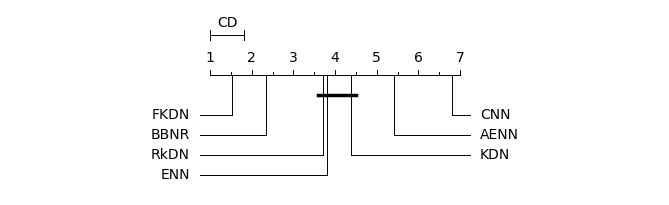

<Figure size 1600x450 with 0 Axes>

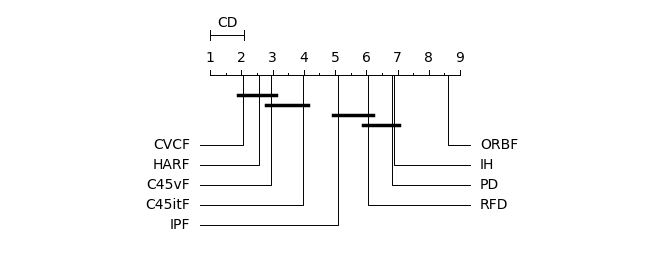

<Figure size 1600x450 with 0 Axes>

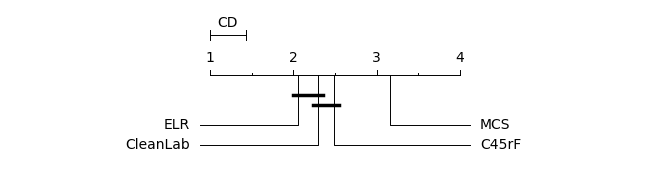

<Figure size 1600x450 with 0 Axes>

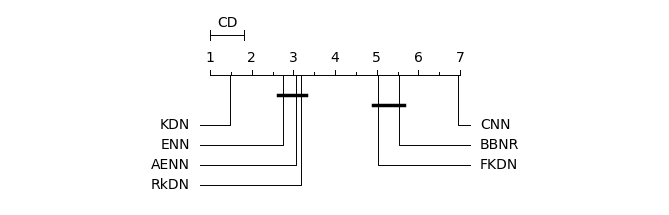

<Figure size 1600x450 with 0 Axes>

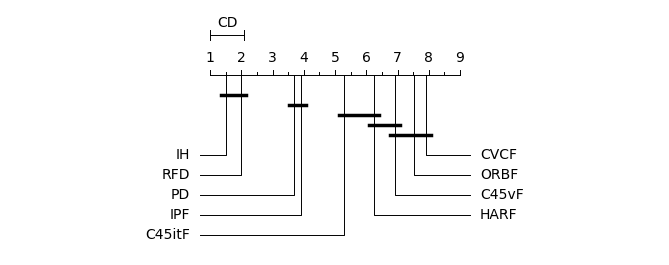

<Figure size 1600x450 with 0 Axes>

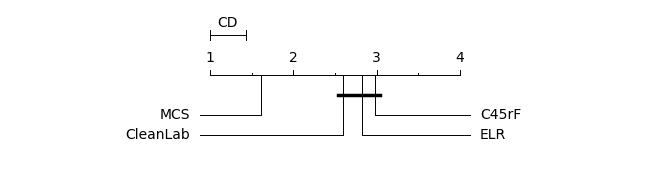

In [39]:
# Need to internatate between score lists (not an optimal solution)
scores = ['Precision','Recall']

#scores = ['Accuracy', 'F-score']

#fig, axs = plt.subplots(3,2,figsize=(16,4*len(score)))


for i, score in enumerate(scores):
    for j,group in enumerate(groups): # + ['All'] 
        fig = plt.figure(figsize=(16,4.5 ))

        if group=='All':
            df = dfs#[dfs['Group']  == group]
        else:
            df = dfs[dfs['Group']  == group]
        d = df.pivot_table(values=score, index=['NoiseType','NoiseLevel','Dataset'], columns='Model', aggfunc='mean')
       # d = d.dropna(axis = 1)

        d = d.rank(ascending = False, axis = 1).astype(int)

        names = d.columns.to_list()
        
        avranks = d.mean()
        # First Friedman test (global)  H0: no difference, if rejected 
        # Nemenyi or Bonferroni-Dunn (one-sided, two sided): H0: no difference
        cd = Orange.evaluation.compute_CD(avranks, len(d), alpha='0.05', 
                                         # test="bonferroni-dunn"
                                         )



        Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6.5 #  6.5 or 8
                                      , textspace=2,  fontsize = 2,
                                      # cdmethod=0
                                     )
        name = 'figuresNew/CD'+group+'_'+score+'.jpeg'
        fig = plt.gcf()
        size = fig.get_size_inches()*fig.dpi 
        #plt.savefig('figuresNew/CD'+group+'_'+score+b+'.jpeg',transparent=True,bbox_inches = 'tight', dpi = 300)


#### Read the saved files for each group separetly 

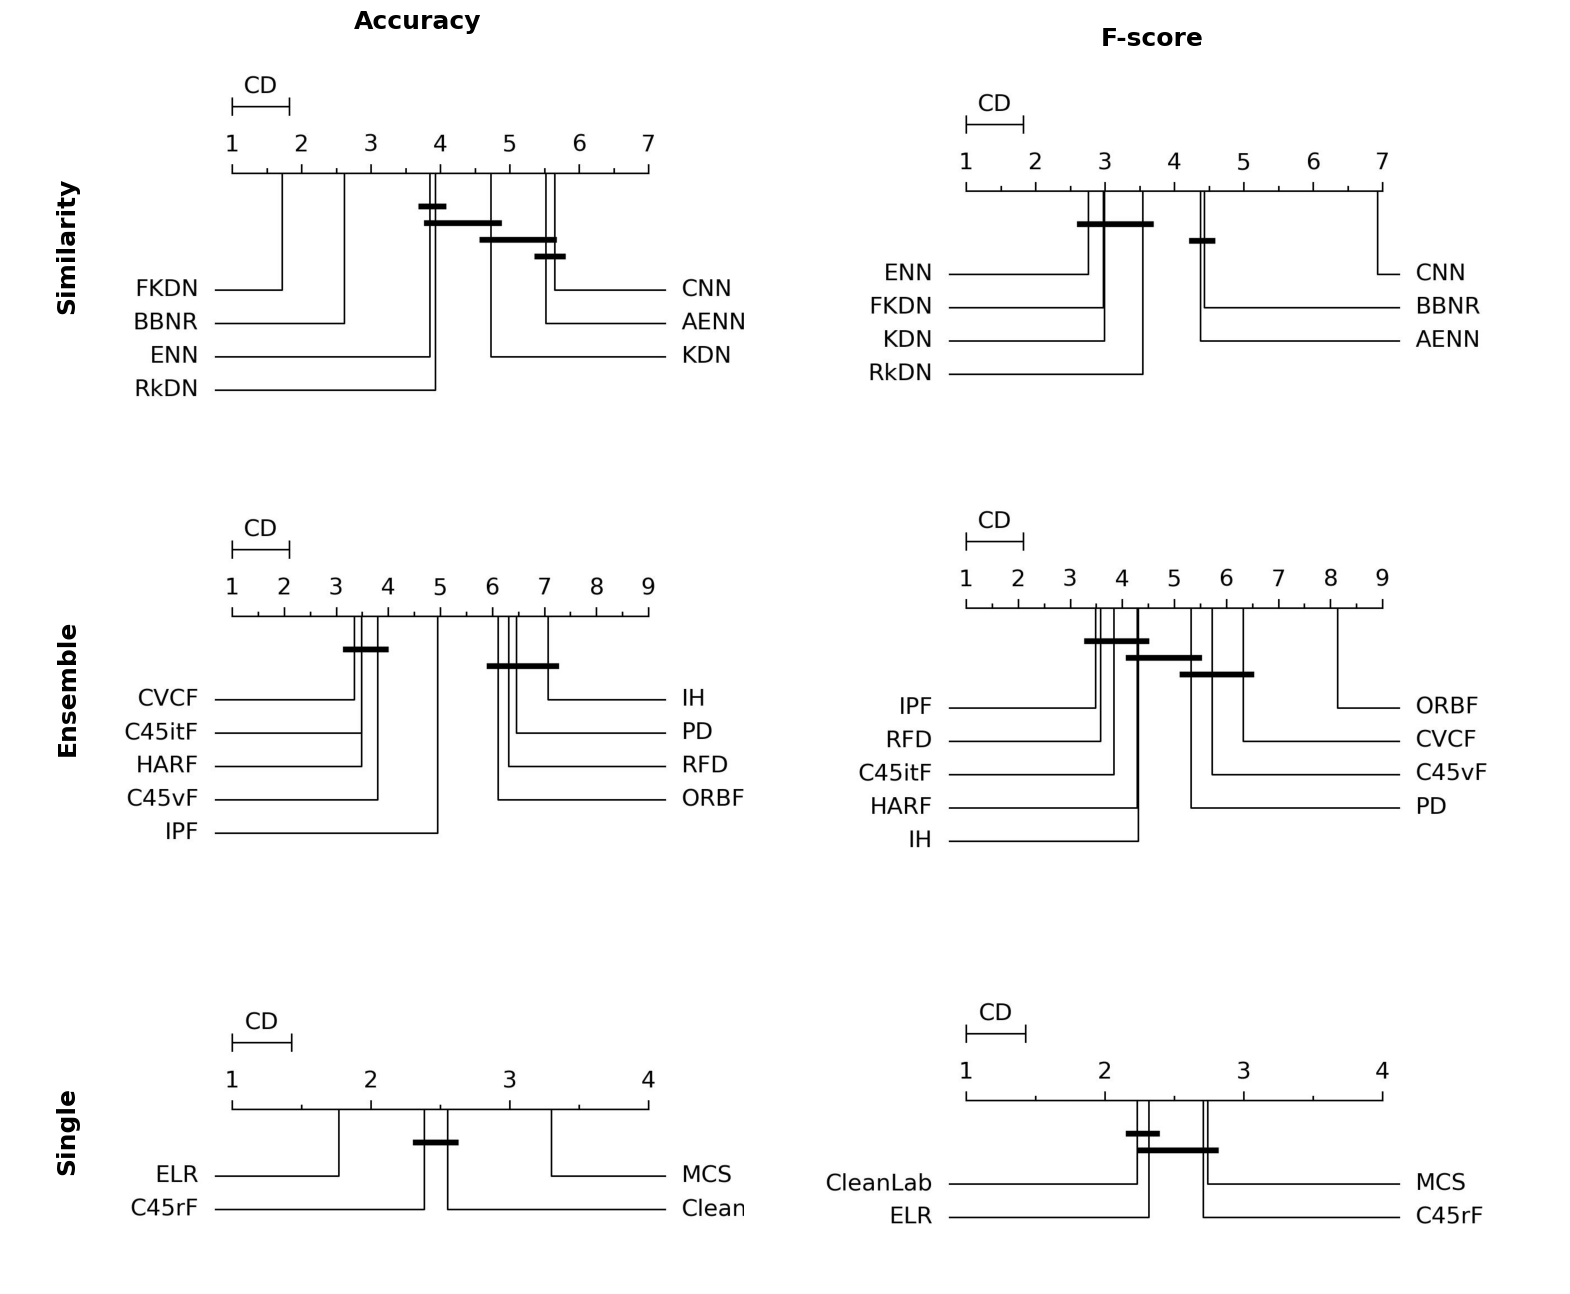

In [41]:
scores = ['Precision','Recall']

scores = ['Accuracy', 'F-score']

import pickle as pkl
fig, axs = plt.subplots(3,2,figsize=(8,2*len(score)))

for i, score in enumerate(scores):
    for j,group in enumerate(groups):
        

        name = 'figuresNew/CD'+group+'_'+score+b+'.jpeg'
        image = plt.imread(name)
        cropped_image = image[:,230:1700, :]
        #print(np.shape(cropped_image))

        axs[j,i].imshow(cropped_image)
        axs[j,i].xaxis.set_visible(False) # same for y axis.
      #  axs[j,i].yaxis.set_visible(False) # same for y axis.
        fig.tight_layout(pad=-27.0)

        axs[j,i].set_frame_on(False)
        if j==0: 
            axs[j,i].set_title("{}".format(score), fontsize = 18, pad=15,weight='bold',style = 'normal',)
        if i==0:
            axs[j,i].set_ylabel(group,style = 'normal',
                                fontsize = 18,labelpad=-50 ,weight='bold'
                               )
        axs[j,i].set_yticks([]) 
plt.subplots_adjust(wspace = -0.1, hspace = -0.65)
#plt.savefig('figuresNew/CD'+b+score+'.jpeg',transparent=False,bbox_inches = 'tight', dpi = 300)


In [194]:
#### Read the saved files for all groups together 

figuresNew/CDAll_AccuracyNoiseMax05_woClinVar.jpeg
(1155, 2460, 3)
figuresNew/CDAll_F-scoreNoiseMax05_woClinVar.jpeg
(1244, 2460, 3)


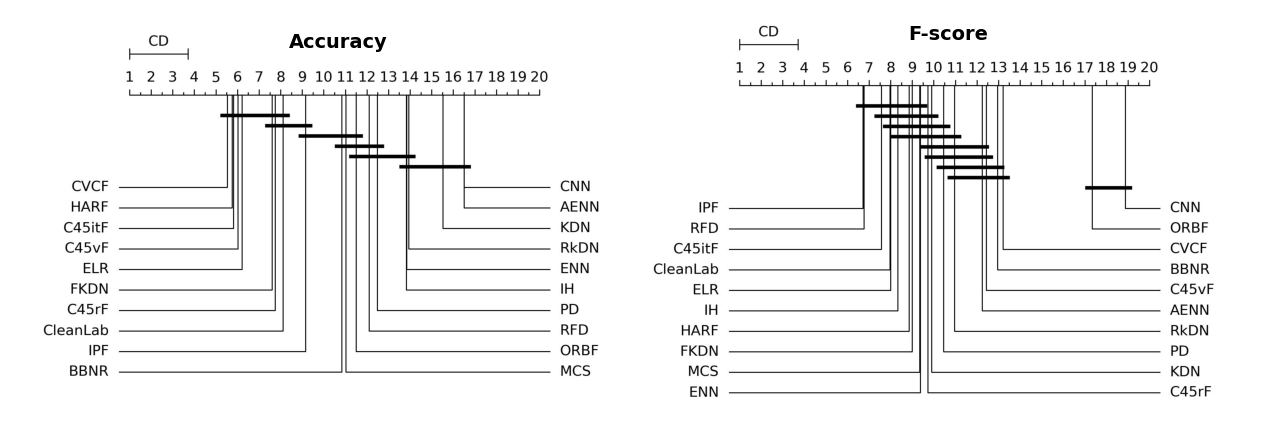

In [43]:
import pickle as pkl
import matplotlib as mpl

fig, axs = plt.subplots(1,2,figsize=(12,2.5*len(score)))
group = 'All'

for i, score in enumerate(scores):        

        name = 'figuresNew/CD'+group+'_'+score+b+'.jpeg'
        print(name)
        image = plt.imread(name)
        print(np.shape(image))

        cropped_image = image[0:1210,280:2130, :] # precision and recall
        #cropped_image = image[0:1155,280:2130, :]

        imgplot = axs[i].imshow(cropped_image)
        axs[i].xaxis.set_visible(False) # same for y axis.
        axs[i].yaxis.set_visible(False) # same for y axis.
        fig.tight_layout(pad=-1.5)

        axs[i].set_frame_on(False)
       
        
        axs[i].set_title("{}".format(score), fontsize = 14, pad=8
                         ,weight='bold',style = 'normal',
                        x=0.52, y=0.9, 
                        # loc = 'center'
                        )

      
        axs[i].set_xticks([]) 
        axs[i].set_yticks([]) 

#plt.savefig('figuresNew/CD_All'+b+score+'.jpeg',transparent=False,bbox_inches = 'tight', dpi = 300)


In [ ]:
cropped_image = ax[0:1215,0:2460, :]


### Main Analysis (plots)

In [46]:
labels = {'NoiseLevel': 'Noise level',
         'DatasetSize' : 'Sample size'}

noiseLevels = pd.Series((dfs['NoiseLevel'].unique())).sort_values()


fs = 15
diSave = di


#### Figure 3. Precision, recall and F-score for different datasets over all parameters.

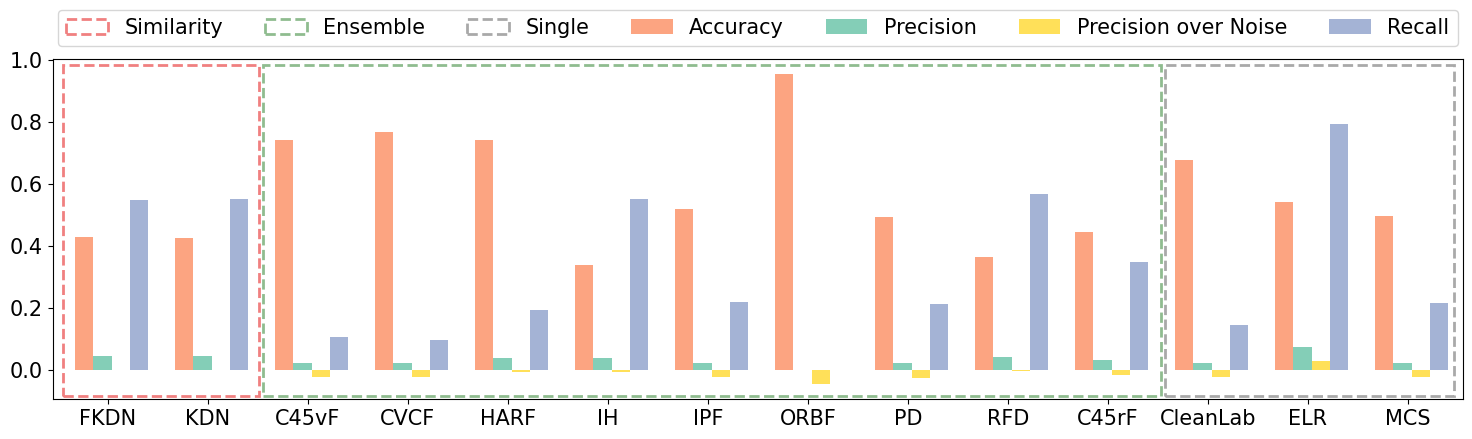

In [208]:
# now used only for ClinVar
df =  dfs.groupby(['Model'])[['Precision','Recall','F-score','Accuracy',pon]].mean()#.dropna(how = 'all')


di = dict(dfs[['Model','Group']].value_counts().index)
di1 = {'Ensemble':1,'Similarity':0,'Single':2}



df['Group'] = df.index
df['Group'] = df['Group'].replace(di).replace(di1).astype(int)
df = df.sort_values('Group')
di2 = df['Group'].value_counts()
colors  = pd.Series(sns.color_palette("Set2"))[[0,1,2,5]]
fig = plt.figure(figsize=(16,4.5 ))
#fig = plt.figure(figsize=(13,4.5 ))


colors = list(set(colors))
ax = fig.add_subplot(111)
indices = np.array(list(range(len(df))))
width = np.min(np.diff(indices))/3 -0.15

# matplotlib 3.0 you have to use align
s =0.005

ax.bar(indices-width+s,df['Accuracy'],width,align='edge',
       label = 'Accuracy' ,alpha = 0.8, color = colors[2]
      )

ax.bar(indices+s,df['Precision'],width,align='edge',
       label = 'Precision',color = colors[1]
       ,alpha = 0.8 )


ax.bar(indices+width+s,df[pon],width,align='edge',alpha = 0.8,
       label = pon,color = colors[0]
      )
ax.bar(indices+width*2+s,df['Recall'],width,align='edge',alpha = 0.8,
       label = 'Recall',color = colors[3]
      )


plt.xticks(indices+0.15, df.index.to_list(), fontsize = fs,rotation=0)
plt.yticks(fontsize = fs)



ax.add_patch(plt.Rectangle((0.007, 0.01), .139, 0.97, ls="--", ec="lightcoral", fc="none", 
    transform=ax.transAxes, label = 'Similarity', linewidth = 2))

ax.add_patch(plt.Rectangle((.149, 0.01), .637, 0.97, ls="--", ec="darkseagreen", 
                           fc="none",
                           transform=ax.transAxes, label = 'Ensemble', linewidth = 2))

ax.add_patch(plt.Rectangle((0.7885, 0.01), .205, 0.97, ls="--", ec="darkgrey", 
                           fc="none",
                           transform=ax.transAxes, label = 'Single', linewidth = 2))

#fig.legend(#)
plt.legend(ncol = 7, fontsize = fs, loc='center', bbox_to_anchor=(0.5, 1.09))  # 0.5, 1.09
plt.xlim([-0.4,len(indices)-0.3])
    
fig.tight_layout()

name = 'BarPlotAll'+b+'.jpeg'    
plt.savefig('figuresNew/'+ name,transparent=False,bbox_inches = 'tight', dpi = 300)

plt.show()

#### Boxplots

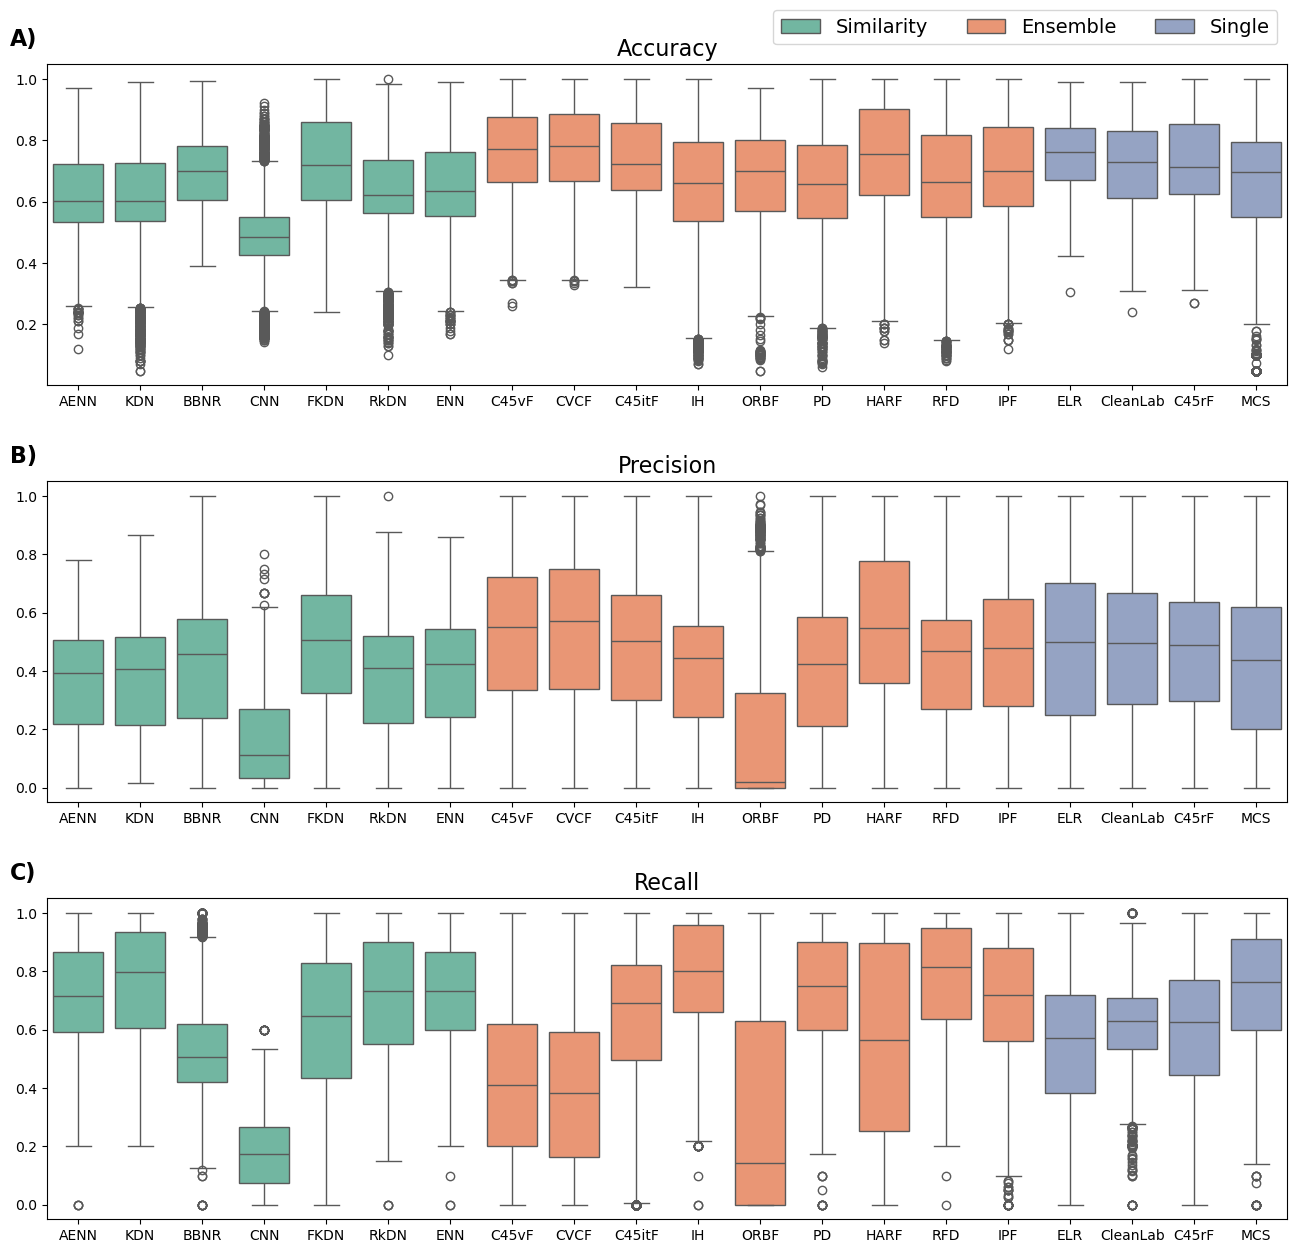

In [61]:

dfs = dfs.sort_values('GroupNum')
titleRes = ['A)', 'B)', 'C)']
fig, axs = plt.subplots(3,1,figsize=(16, 15))

for i, score in enumerate(['Accuracy', 'Precision', 'Recall']):
    sns.boxplot(data = dfs,  x="Model", y=score, hue = 'Group', width = 1, gap = 0.2, ax = axs[i],
                legend = True if i == 2 else False
               #notch=True,showcaps=True
               )
  #  sns.stripplot(data = dfs,  x="Model", y=score, hue = 'Group',ax = axs[i],
   #             legend = True if i == 2 else False, dodge = True)
    axs[i].set_title(titleRes[i] + '\n', fontsize = 16,loc='left',weight="bold",x=-0.03, y = 0.95)
    axs[i].set_title(score, fontsize = 16)
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    
plt.subplots_adjust(hspace = 0.3, wspace = 0.2)
plt.legend(ncol = 3, fontsize = 14, #loc='lower right', bbox_to_anchor=(1, -0.28)
           loc='upper right', bbox_to_anchor=(1, 3.8)
          )
#plt.savefig('figuresNew/Boxplots'+b+'.jpeg',transparent=False, bbox_inches = 'tight', dpi = 300)





9800
12600
5590
9800
12600
5600
9800
12600
5600
9800
12600
5600
9800
12600
5600
9800
12600
5590


/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_706508/2181170520.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0].set_markersize(6)
/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_706508/2181170520.py:38: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0].set_alpha(1)
/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_706508/2181170520.py:39: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1].set_markersize(6)
/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_706508/2181170520.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in 

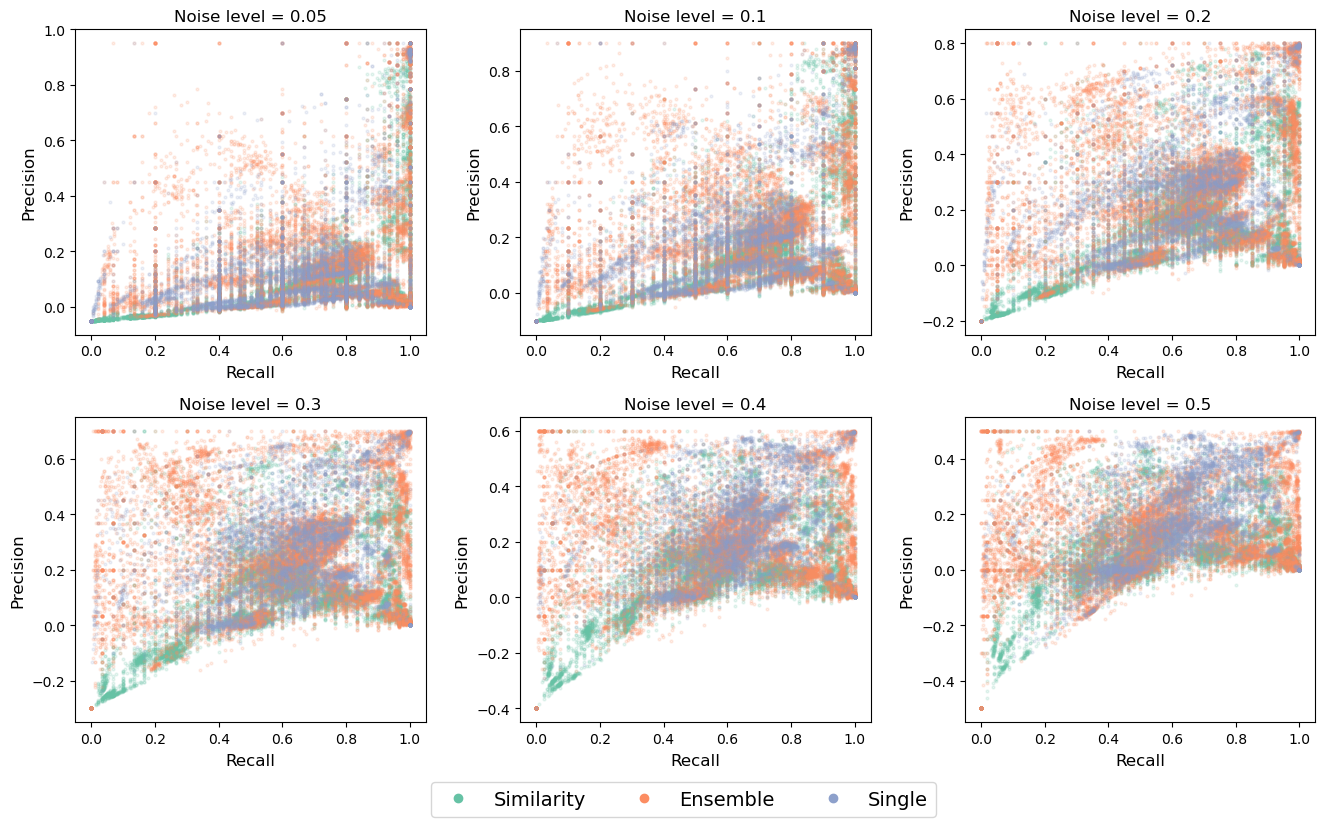

In [62]:
#pivot_table = temp.pivot(columns ='NoiseLevel', index = 'Model' )
#pivot_table
noiseLevels = pd.Series((dfs['NoiseLevel'].unique())).sort_values()


groups = di_groups.values()
fig, axs = plt.subplots(2,3,figsize=(16,9))
axs = axs.flatten()

for i, noise in enumerate(noiseLevels):

    for group in groups:
        temp = dfs[dfs['GroupNum']==group]
        temp = temp[temp['NoiseLevel'] == noise]
        print(len(temp))
        #temp =  temp.groupby(['DatasetSize','Dataset','Model','NoiseType']).mean(numeric_only = True).reset_index()
        #print(temp.groupby('Model').count())
        
        ax = axs[i]
        ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

        ax.plot(temp['Recall'], temp[pon], marker='o', linestyle='', ms=2, label=group,alpha = 0.15
               )
        ax.set_title('Noise level = {}'.format(noise))
        ax.set_xlabel('Recall',fontsize = 12, labelpad = 5)
        ax.set_ylabel('Precision',fontsize = 12, labelpad = 5)
#ax.legend()
#h,l = ax.get_legend_handles_labels()
#print(h,l)
lgnd = fig.legend(di_groups.keys(),
           loc="upper center", bbox_to_anchor=(0.505,0), borderaxespad= -2,
            fancybox=True, shadow=False,  ncol=3, fontsize = 14)

#for ln in lgnd.legendHandles:
#    lgnd.legendHandles.set_markersize(6)

lgnd.legendHandles[0].set_markersize(6)
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_markersize(6)
lgnd.legendHandles[1].set_alpha(1)
lgnd.legendHandles[2].set_markersize(6)
lgnd.legendHandles[2].set_alpha(1)

plt.subplots_adjust(hspace = 0.27, wspace = 0.27)
#plt.savefig('figuresNew/Scatter_all.jpeg',transparent=False,bbox_inches = 'tight', dpi = 300)

plt.show()

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_706508/971068546.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0].set_markersize(6)
/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_706508/971068546.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1].set_markersize(6)
/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_706508/971068546.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[2].set_markersize(6)


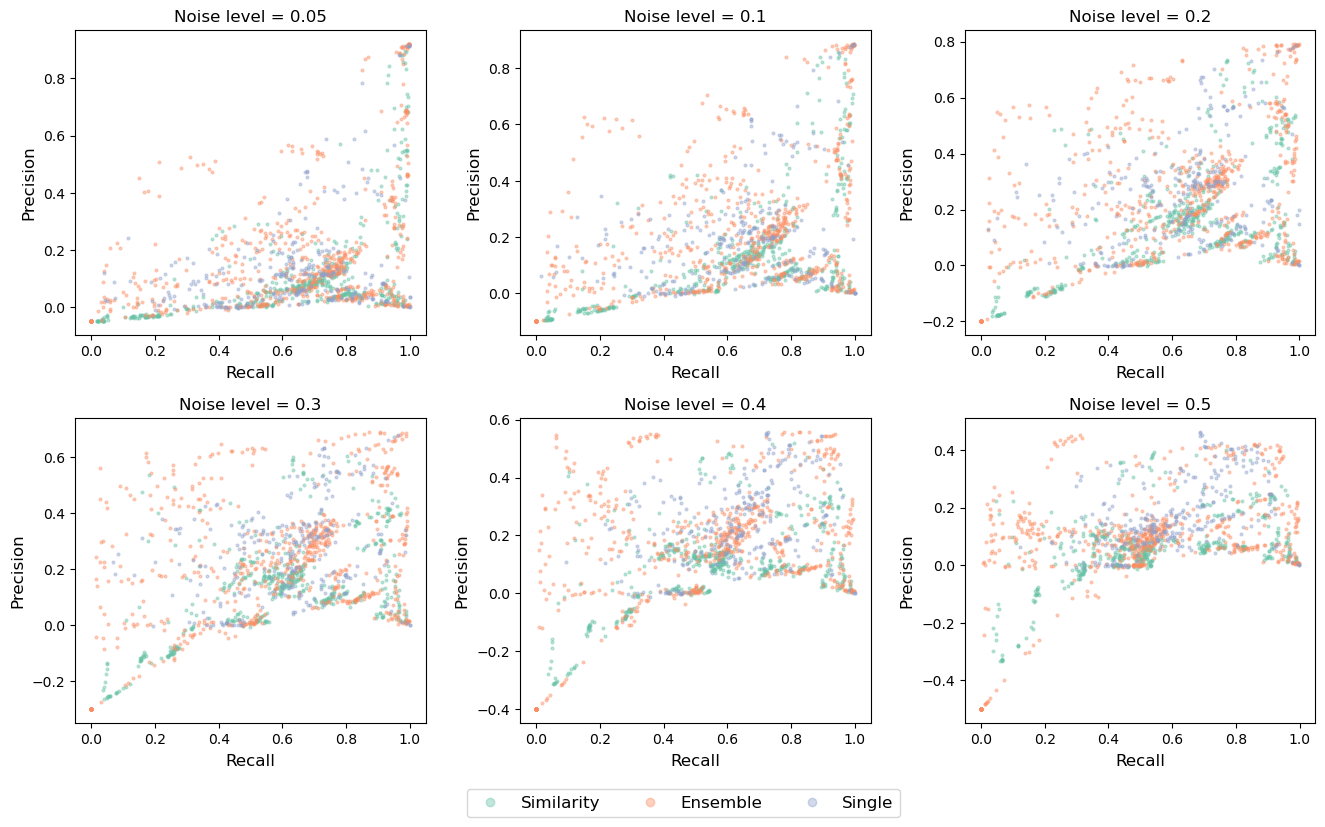

In [55]:
# With lower number of data points

groups = di_groups.values()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
fig, axs = plt.subplots(2,3,figsize=(16,9))
axs = axs.flatten()

for i, noise in enumerate(noiseLevels):

    for group in groups:
        temp = dfs[dfs['GroupNum']==group]
        temp = temp[temp['NoiseLevel'] == noise]
        temp =  temp.groupby(['DatasetSize','Dataset','Model']).mean(numeric_only = True).reset_index()
        ax = axs[i]
        ax.plot(temp['Recall'], temp[pon], marker='o', linestyle='', ms=2, label=group,alpha = 0.4)
        ax.set_title('Noise level = {}'.format(noise))
        ax.set_xlabel('Recall',fontsize = 12, labelpad = 5)
        ax.set_ylabel('Precision',fontsize = 12, labelpad = 5)
#ax.legend()
#h,l = ax.get_legend_handles_labels()
#print(h,l)
lgnd = fig.legend(di_groups.keys(),
           loc="upper center", bbox_to_anchor=(0.505,0), borderaxespad= -2,
            fancybox=True, shadow=False,  ncol=3, fontsize = 12)
lgnd.legendHandles[0].set_markersize(6)
lgnd.legendHandles[1].set_markersize(6)
lgnd.legendHandles[2].set_markersize(6)

plt.subplots_adjust(hspace = 0.27, wspace = 0.27)

plt.show()

#### Line plots with vertical alignment of groups (not used in the current version of the paper)

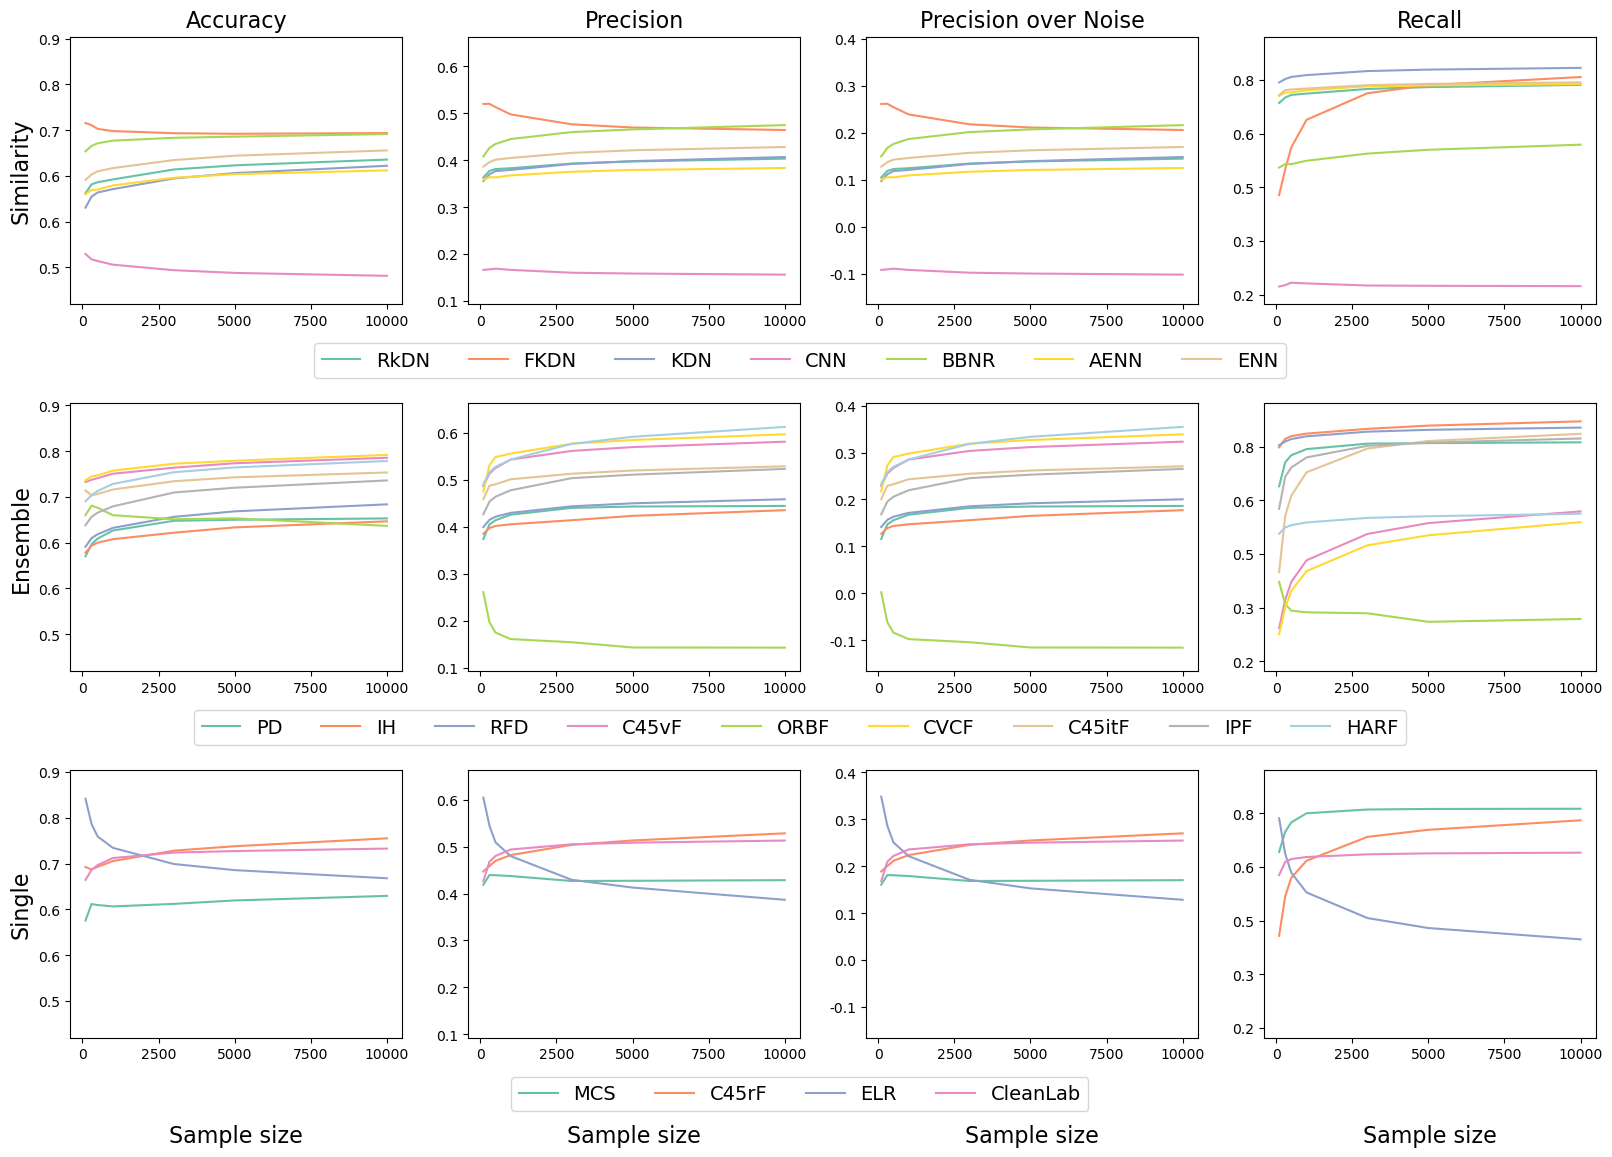

In [74]:
## Performance wrt to particular model 
## Rerun the dfs creation if the plots are empty


allScores = dfs
di = {
   #  'PrecisionOverNoise':[['Precision', pon, pon], ['NoiseLevel','NoiseLevel','DatasetSize'], True], #Figure 7
     # 'RecallOverNoise':[['Recall', 'Recall'], ['NoiseLevel','DatasetSize'], True], # Figure 8
      #    'AccuracyOverNoise':[['Accuracy', 'Accuracy'], ['NoiseLevel','DatasetSize'], True], # Figure 8

#      'CostOfTP' : [[retrieved,'PLR-Inv' ], ['NoiseLevel','NoiseLevel'], True], # Figure 10
#       'ExecutionTime' : [['Execution Time','Execution Time'],['NoiseLevel','DatasetSize'], False],
#    # 'CostComparison' : [[retrieved, 'F-score','F-score-mod', 'Cost','Cost-mod','PLR','PLR-Inv'], ['NoiseLevel']*7, True],
#    'AllMetricsOverNoise' : [['Precision', pon,'Recall', 'Accuracy'], ['NoiseLevel']*4, True],

  # 'AllOverNoise':[['Accuracy','Precision', pon, 'Recall'], ['NoiseLevel','NoiseLevel','NoiseLevel','NoiseLevel'], True], #Figure 7
     'AllOverSampleSize':[['Accuracy','Precision', pon, 'Recall'], ['DatasetSize','DatasetSize','DatasetSize','DatasetSize'], True], # Figure 8
    #     'AccuracyOverNoise':[['Accuracy', 'Accuracy'], ['NoiseLevel','DatasetSize'], True], # Figure 8

  #   'CostOfTP' : [[retrieved,'PLR-Inv' ], ['NoiseLevel','NoiseLevel'], True], # Figure 10
  #    'ExecutionTime' : [['Execution Time','Execution Time'],['NoiseLevel','DatasetSize'], False],
   # 'CostComparison' : [[retrieved, 'F-score','F-score-mod', 'Cost','Cost-mod','PLR','PLR-Inv'], ['NoiseLevel']*7, True],
   #'AllMetricsOverNoise' : [['Precision', pon,'Recall', 'Accuracy'], ['NoiseLevel']*4, True]

     }


n = 1.3
fontsize = 10

for key in di.keys():

    li = di[key][0]
    variables = di[key][1]
    fig, axs = plt.subplots(3,len(li),figsize=(3.4*len(li)*n+2,10*n))

    for i,Score in enumerate(li):

        scores = allScores
        variable = variables[i]
        label = labels[variable]
        lim = scores.groupby(['Model', variable])[Score].mean()
        if (key=='CostOfTP')& (Score=='PLR-Inv'):
            lim = pd.Series([0,scores.groupby(['Model', variable])[Score].mean().sort_values(ascending = False)[3]+0.5])
        applyLim = di[key][2]
        for j,group in enumerate(groups):  
                models = mod[mod['Group']==group]['Abbreviation']

                for model in models[:]:
                    table_ = scores[scores['Model'] == model]

                    if len(table_) > 0:

                        table = pd.DataFrame(table_.groupby(variable).mean(numeric_only = True)).reset_index()
                        table_ = table.sort_values([variable])

                        axs[j,i].plot(table[variable],table[Score].astype(float),  label = model)
                        if j==len(groups)-1: 
                            axs[j,i].set_xlabel(label,fontsize = 16, labelpad=45)

                        if j==0: 
                            axs[j,i].set_title("{}".format(Score), fontsize = 16, pad=7)
                        if i==0:
                            axs[j,i].set_ylabel(group,fontsize = 16 )
#                            
                            leg = axs[j,i].legend(bbox_to_anchor=(2.2, -0.42,0,0), 
                                                  loc='lower center'
                                                  ,borderaxespad=2,
                  fancybox=True, shadow=False, ncol=10,fontsize = 14)
                   

                        axs[j,i].set_ylim(lim.min()-0.05,lim.max()+0.05)
                        if lim.mean()>1:
                            f = '%.0f'
                        else:
                            f = '%.1f'
                        axs[j,i].yaxis.set_major_formatter(FormatStrFormatter(f))
                        axs[j,i].yaxis.set_major_locator(MaxNLocator(6)) 
                        axs[j,i].xaxis.set_major_locator(MaxNLocator(5)) 

    plt.subplots_adjust(hspace = 0.37, wspace =0.2)

    name = key+b+'.jpeg'
    #plt.savefig('figuresNew/'+name,transparent=False,bbox_inches = 'tight', dpi = 300)



#### Line plots with horuzontal alignment of groups

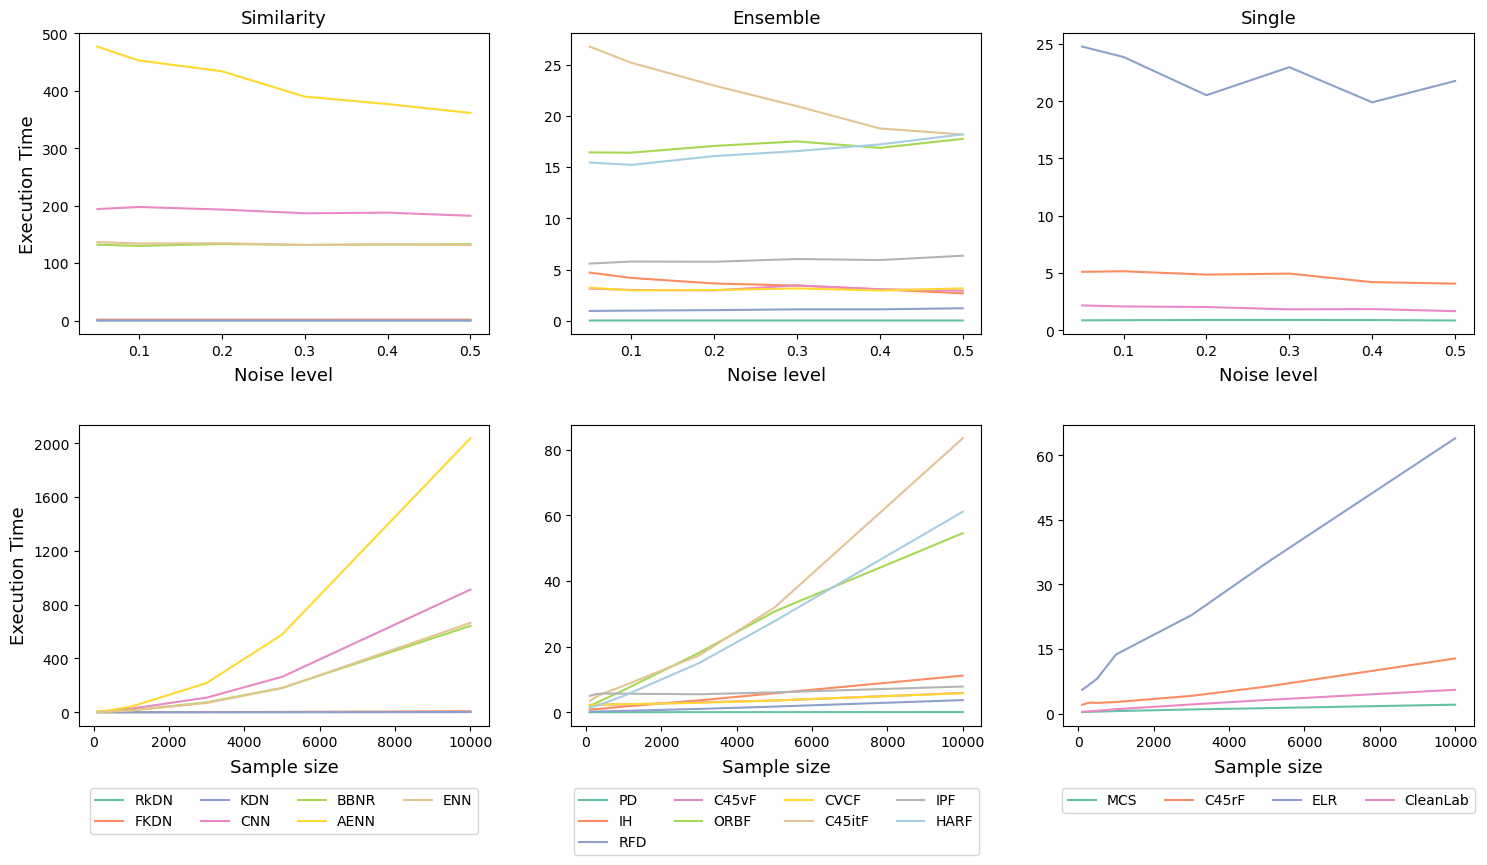

In [73]:

## Rerun the dfs creation if the plots are empty

allScores = dfs
di = {
    # 'PrecisionOverNoise':[['Precision', pon, pon], ['NoiseLevel','NoiseLevel','DatasetSize'], True], #Figure 7
    #  'RecallOverNoise':[['Recall', 'Recall'], ['NoiseLevel','DatasetSize'], True], # Figure 8
    #      'AccuracyOverNoise':[['Accuracy', 'Accuracy'], ['NoiseLevel','DatasetSize'], True], # Figure 8

#      'CostOfTP' : [[retrieved,'PLR-Inv' ], ['NoiseLevel','NoiseLevel'], True], # Figure 10
#       'ExecutionTime' : [['Execution Time','Execution Time'],['NoiseLevel','DatasetSize'], False],
#    # 'CostComparison' : [[retrieved, 'F-score','F-score-mod', 'Cost','Cost-mod','PLR','PLR-Inv'], ['NoiseLevel']*7, True],
    #'AllMetricsOverNoise' : [['Precision', pon,'Recall', 'Accuracy'], ['NoiseLevel']*4, True]

  #  'AllOverNoise':[['Accuracy','Precision', pon, 'Recall'], ['NoiseLevel','NoiseLevel','NoiseLevel','NoiseLevel'], True], #Figure 7
  #   'AllOverSampleSize':[['Accuracy','Precision', pon, 'Recall'], ['DatasetSize','DatasetSize','DatasetSize','DatasetSize'], True], # Figure 8
    #     'AccuracyOverNoise':[['Accuracy', 'Accuracy'], ['NoiseLevel','DatasetSize'], True], # Figure 8

  #   'CostOfTP' : [[retrieved,'PLR-Inv' ], ['NoiseLevel','NoiseLevel'], True], # Figure 10
      'ExecutionTime' : [['Execution Time','Execution Time'],['NoiseLevel','DatasetSize'], False],
   # 'CostComparison' : [[retrieved, 'F-score','F-score-mod', 'Cost','Cost-mod','PLR','PLR-Inv'], ['NoiseLevel']*7, True],
   #'AllMetricsOverNoise' : [['Precision', pon,'Recall', 'Accuracy'], ['NoiseLevel']*4, True]  
     }


n = 1.5
fontsize = 10

for key in di.keys():

    li = di[key][0]
    variables = di[key][1]
    fig, axs = plt.subplots(len(li),3,figsize=(12*n,3*len(li)*n))
    
    for j,Score in enumerate(li):

        scores = allScores
        variable = variables[j]
        label = labels[variable]
        lim = scores.groupby(['Model', variable])[Score].mean()
        if (key=='CostOfTP')& (Score=='PLR-Inv'):
            lim = pd.Series([0,scores.groupby(['Model', variable])[Score].mean().sort_values(ascending = False)[3]+0.5])
        applyLim = di[key][2]
        for i,group in enumerate(groups):  
                models = mod[mod['Group']==group]['Abbreviation']

                for model in models[:]:
                    table_ = scores[scores['Model'] == model]

                    if len(table_) > 0:

                        table = pd.DataFrame(table_.groupby(variable).mean(numeric_only = True)).reset_index()
                        table_ = table.sort_values([variable])

                        axs[j,i].plot(table[variable],table[Score].astype(float),  label = model)
                        axs[j,i].set_xlabel(label,fontsize = 13, labelpad=6)


                        if j==len(li)-1: 
                            axs[j,i].legend(bbox_to_anchor=(0.5, -0.16), loc='upper center'
                                                  ,borderaxespad=1,
                  fancybox=True, shadow=False, ncol=4)

                        if j==0: 
                            axs[j,i].set_title("{}".format(group), fontsize = 13, pad=7)
                          
                        if i==0:
                            axs[j,i].set_ylabel(Score,fontsize = 13 )

                        if lim.mean()>1:
                            f = '%.0f'
                        else:
                            f = '%.1f'
                        axs[j,i].yaxis.set_major_formatter(FormatStrFormatter(f))
                        axs[j,i].yaxis.set_major_locator(MaxNLocator(6)) 
                     
                        locs, l = plt.xticks() 

                    
    plt.subplots_adjust(hspace = 0.3, wspace =0.2)

    name = key+b+'.jpeg'
    #plt.savefig('figuresNew/'+name,transparent=False,bbox_inches = 'tight', dpi = 300)



#### Model performance on different datasets (vertical plots)

40.5


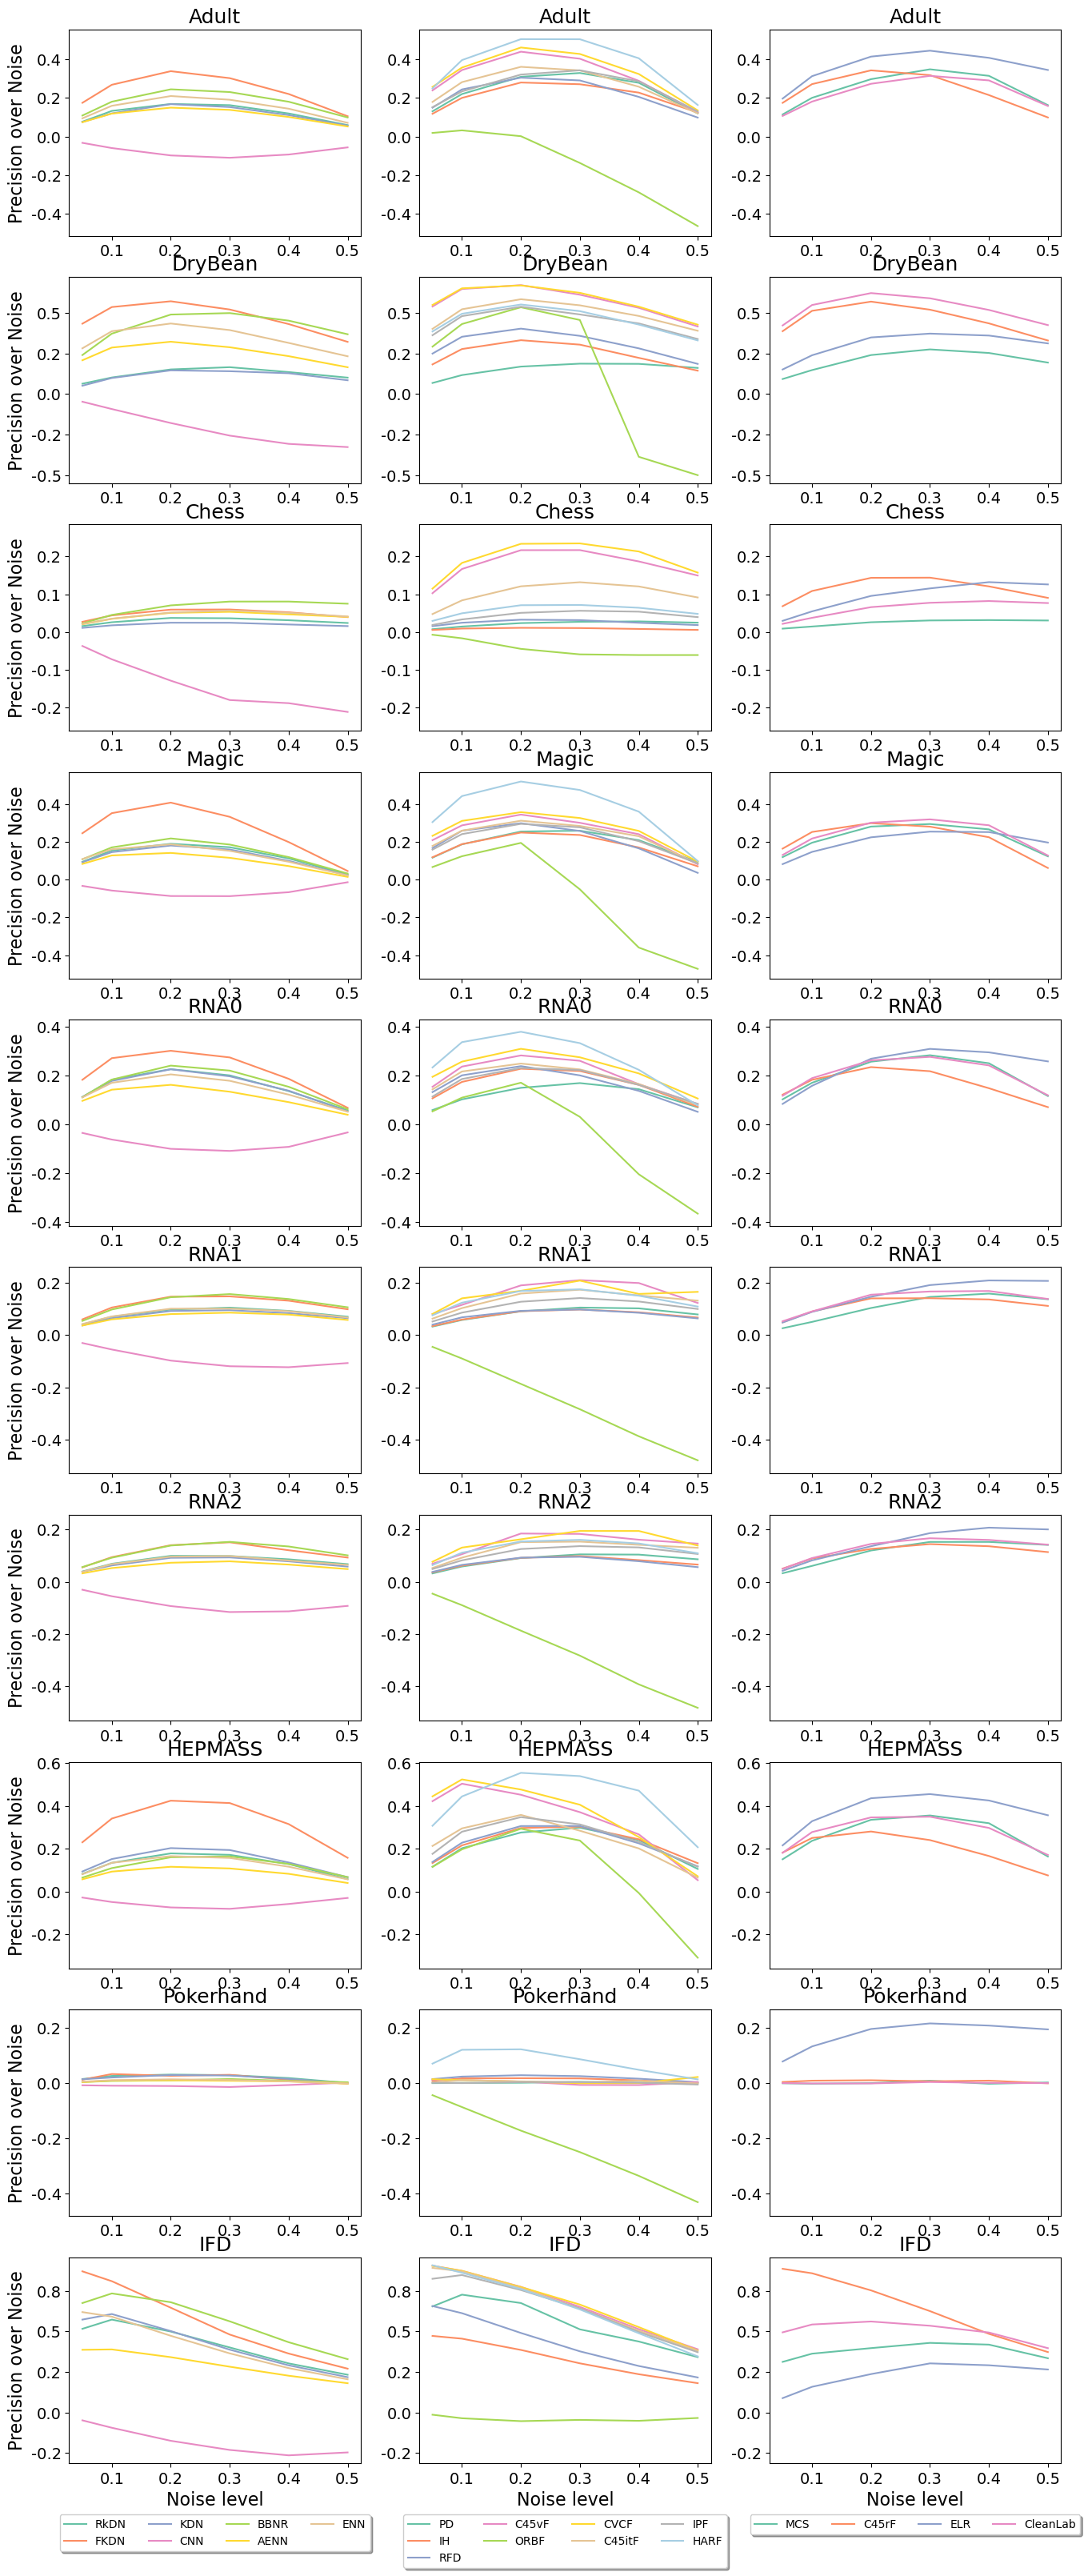

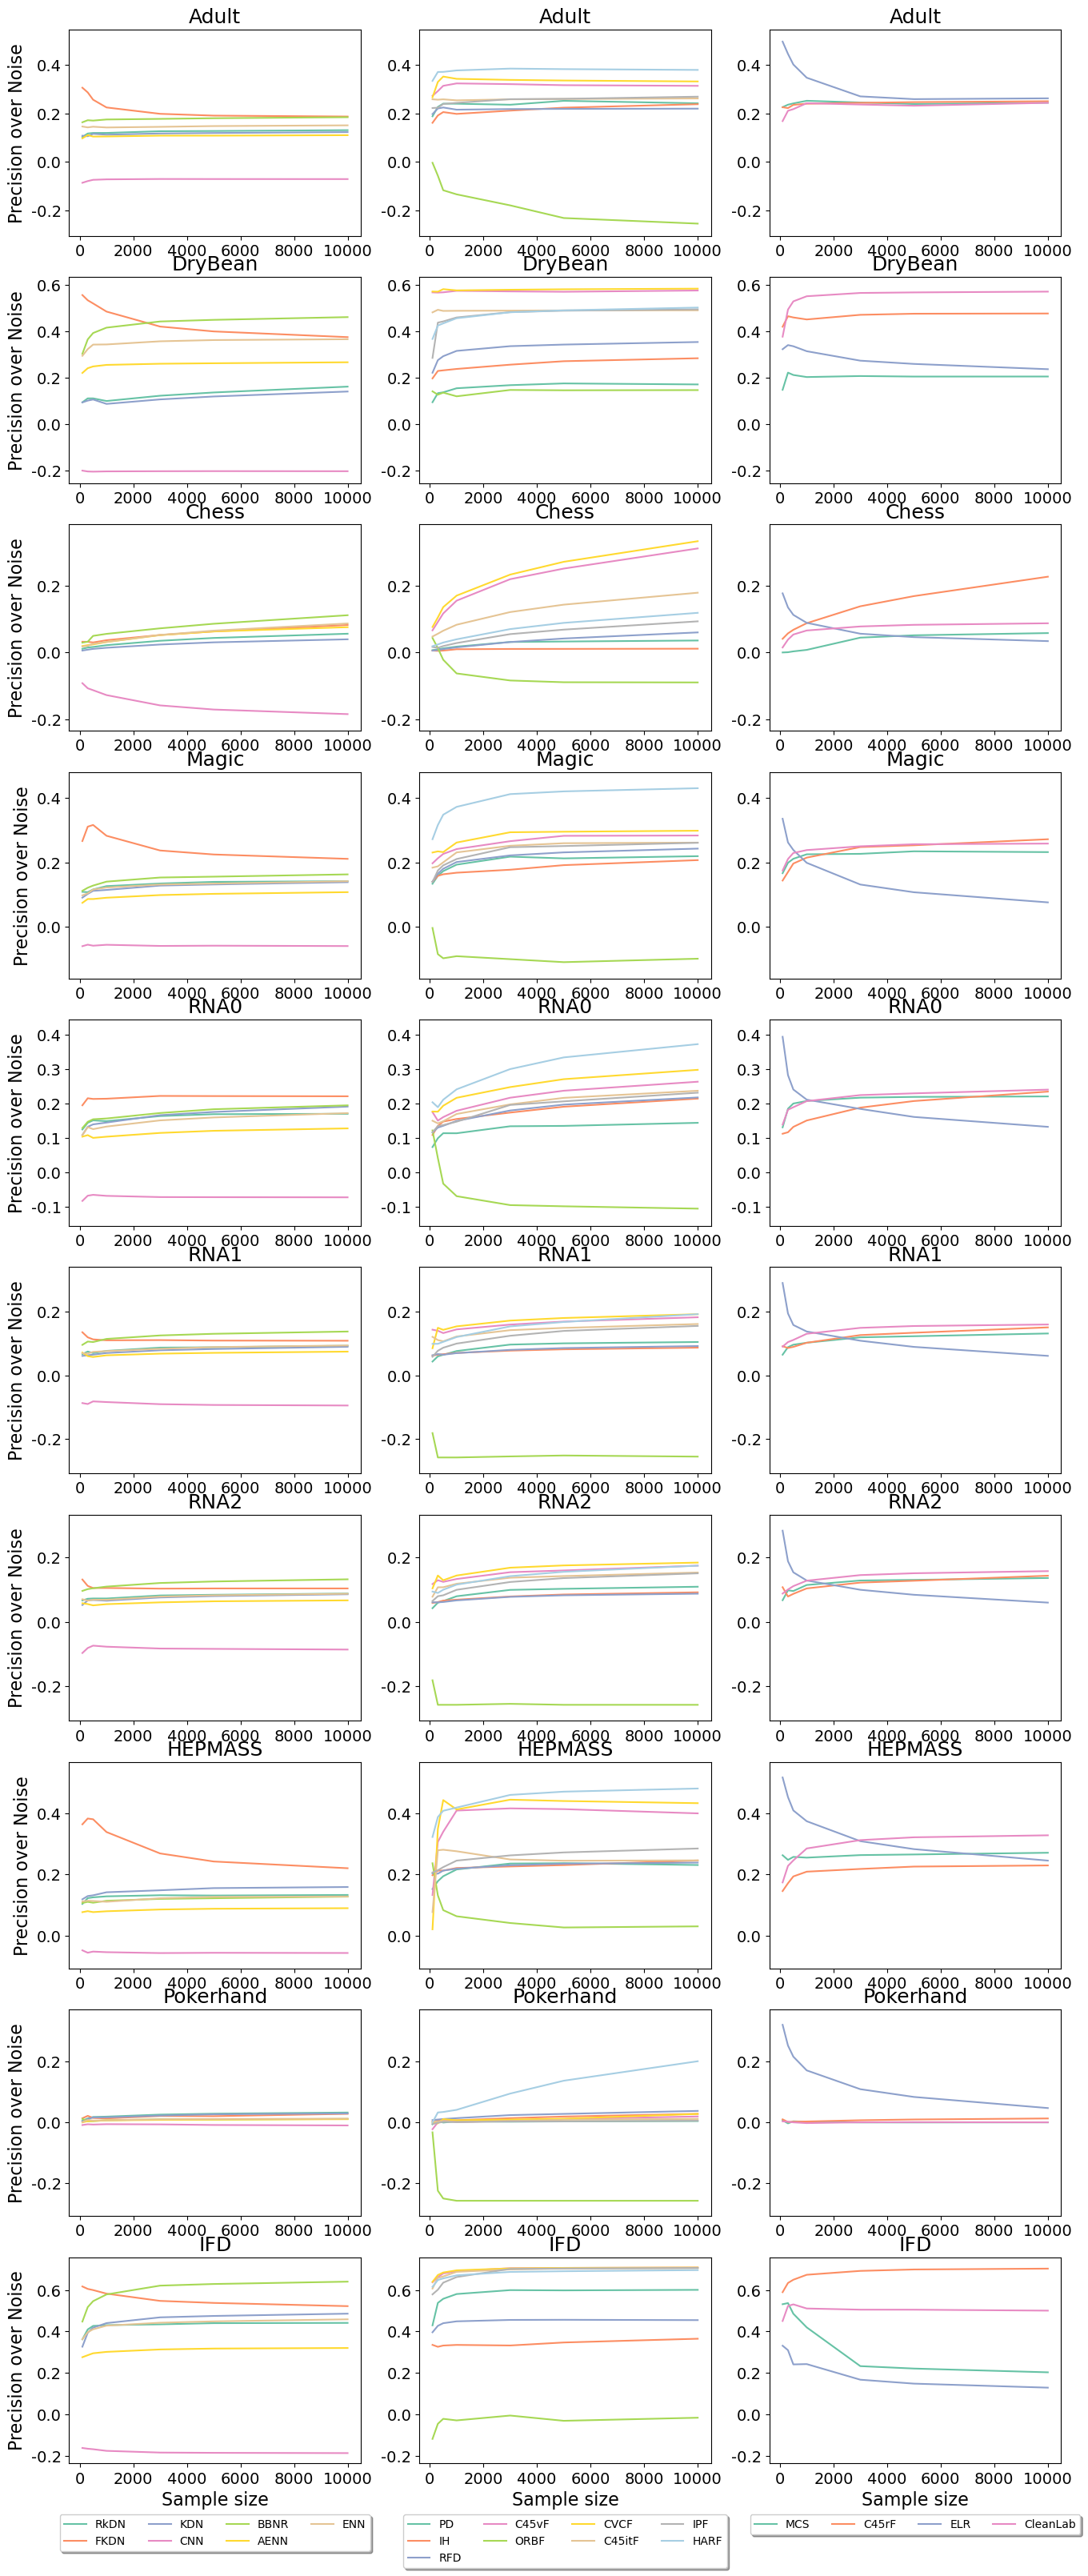

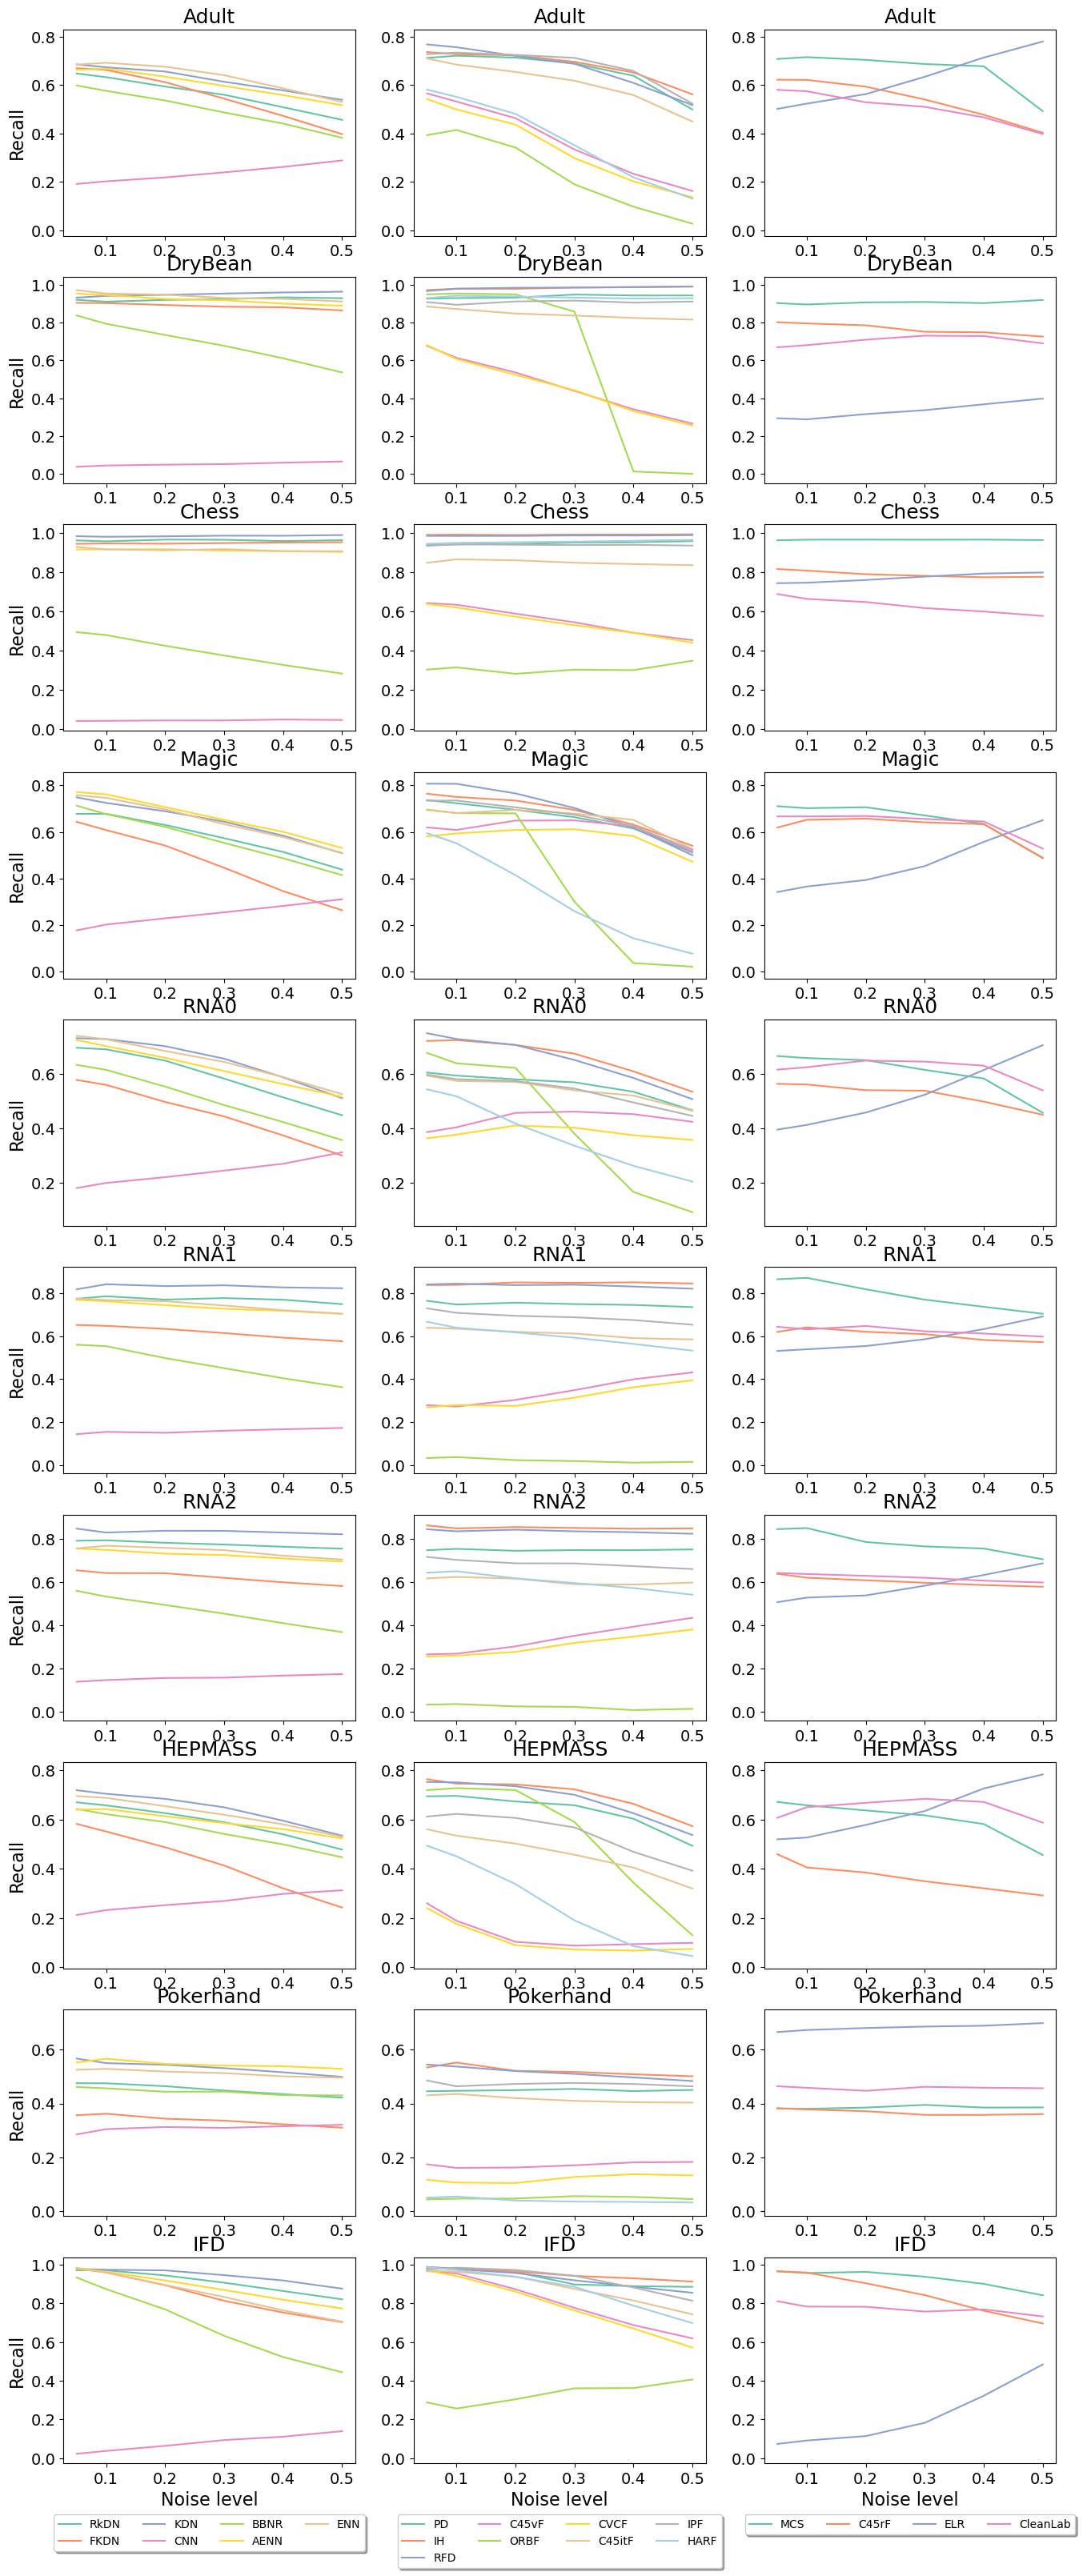

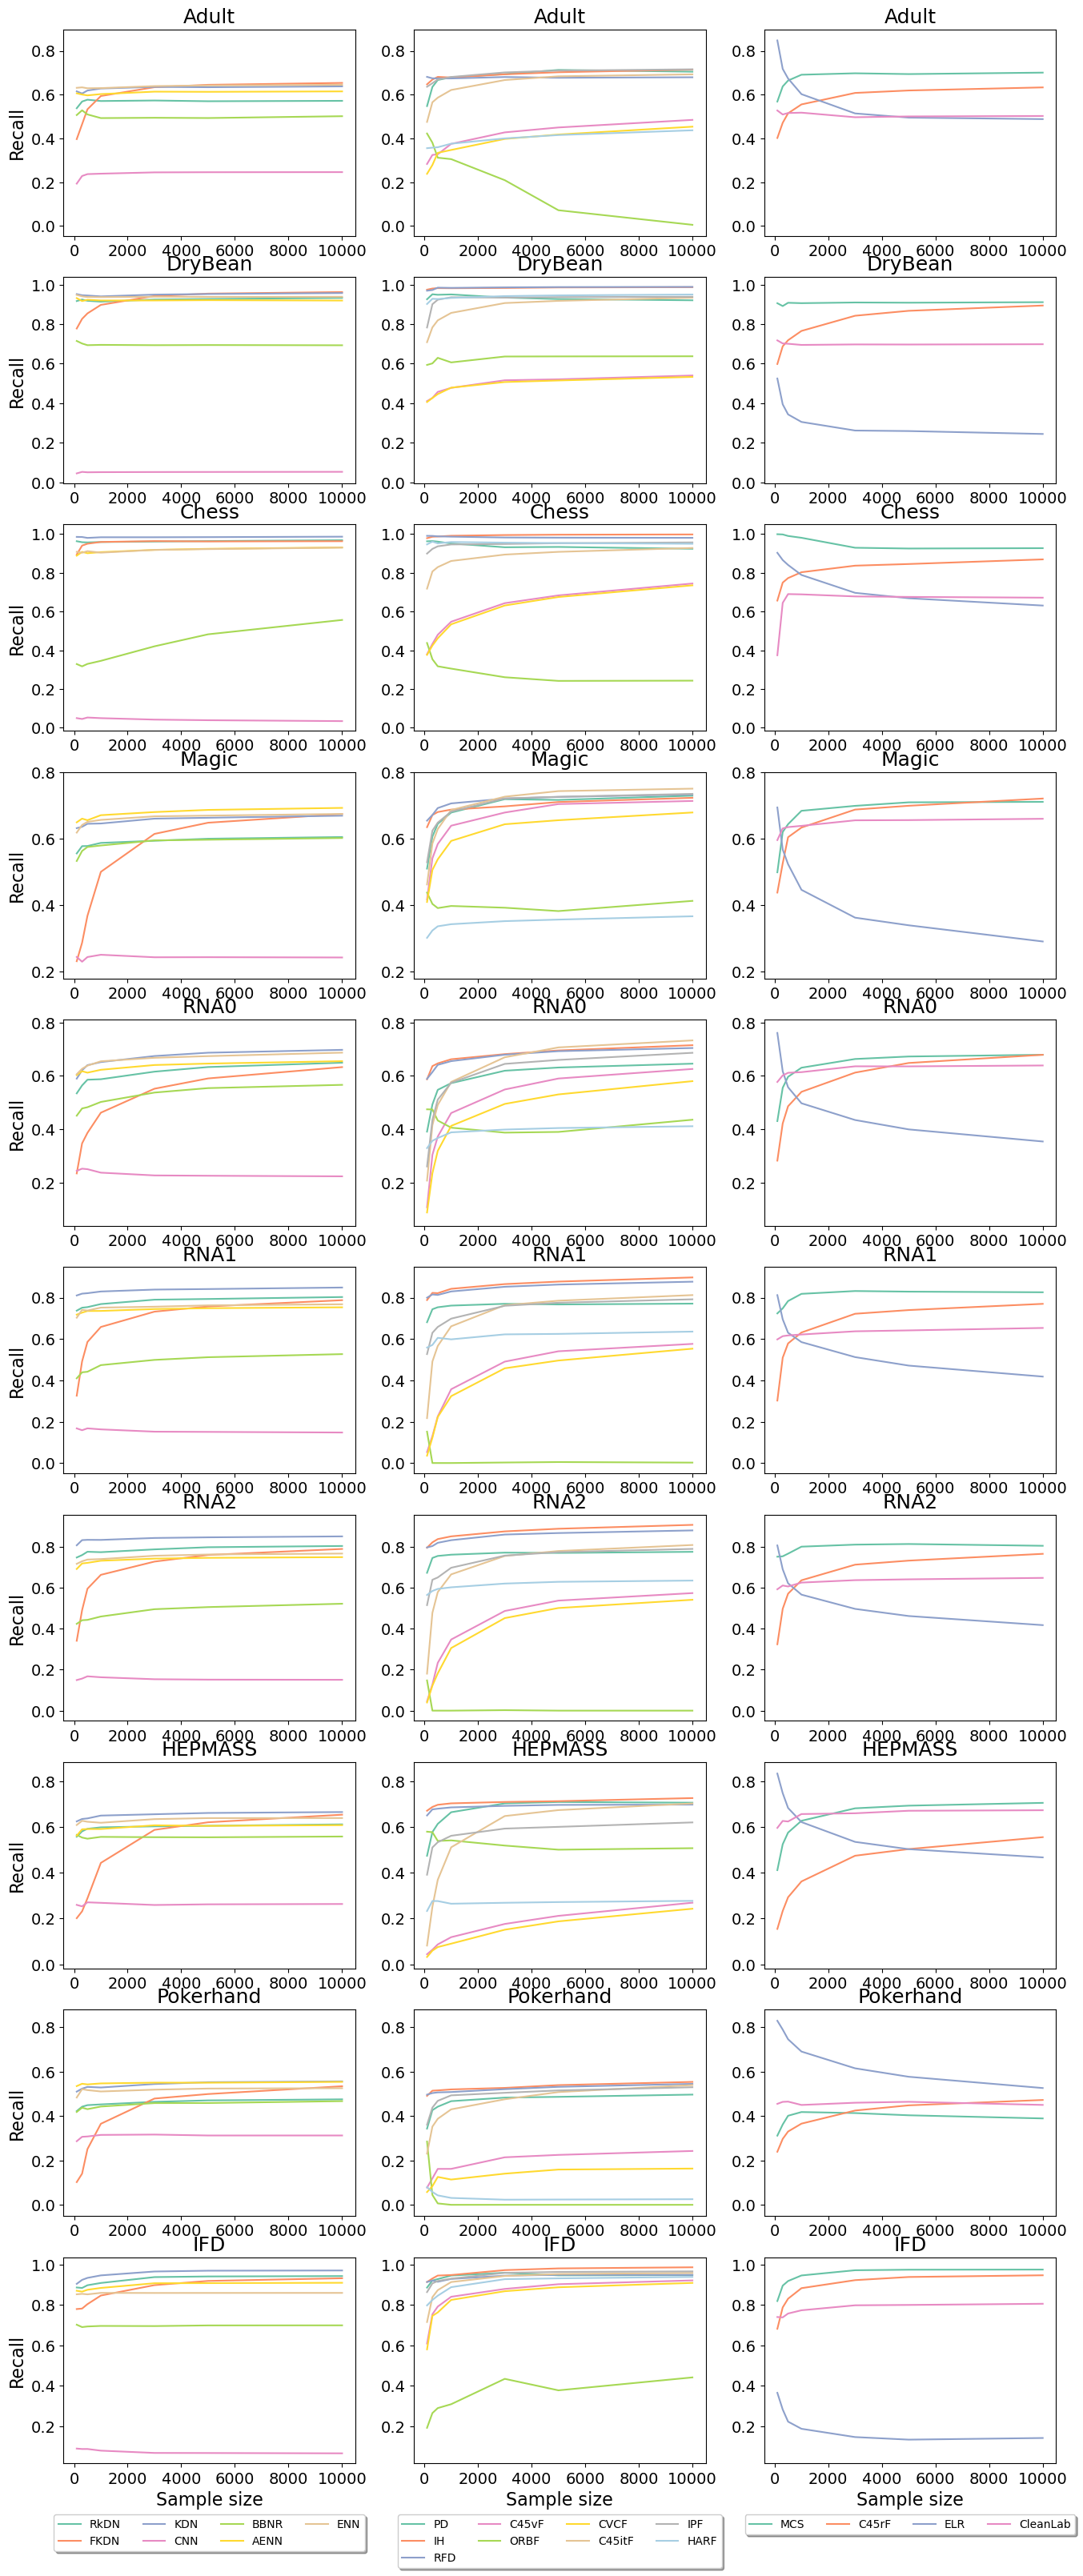

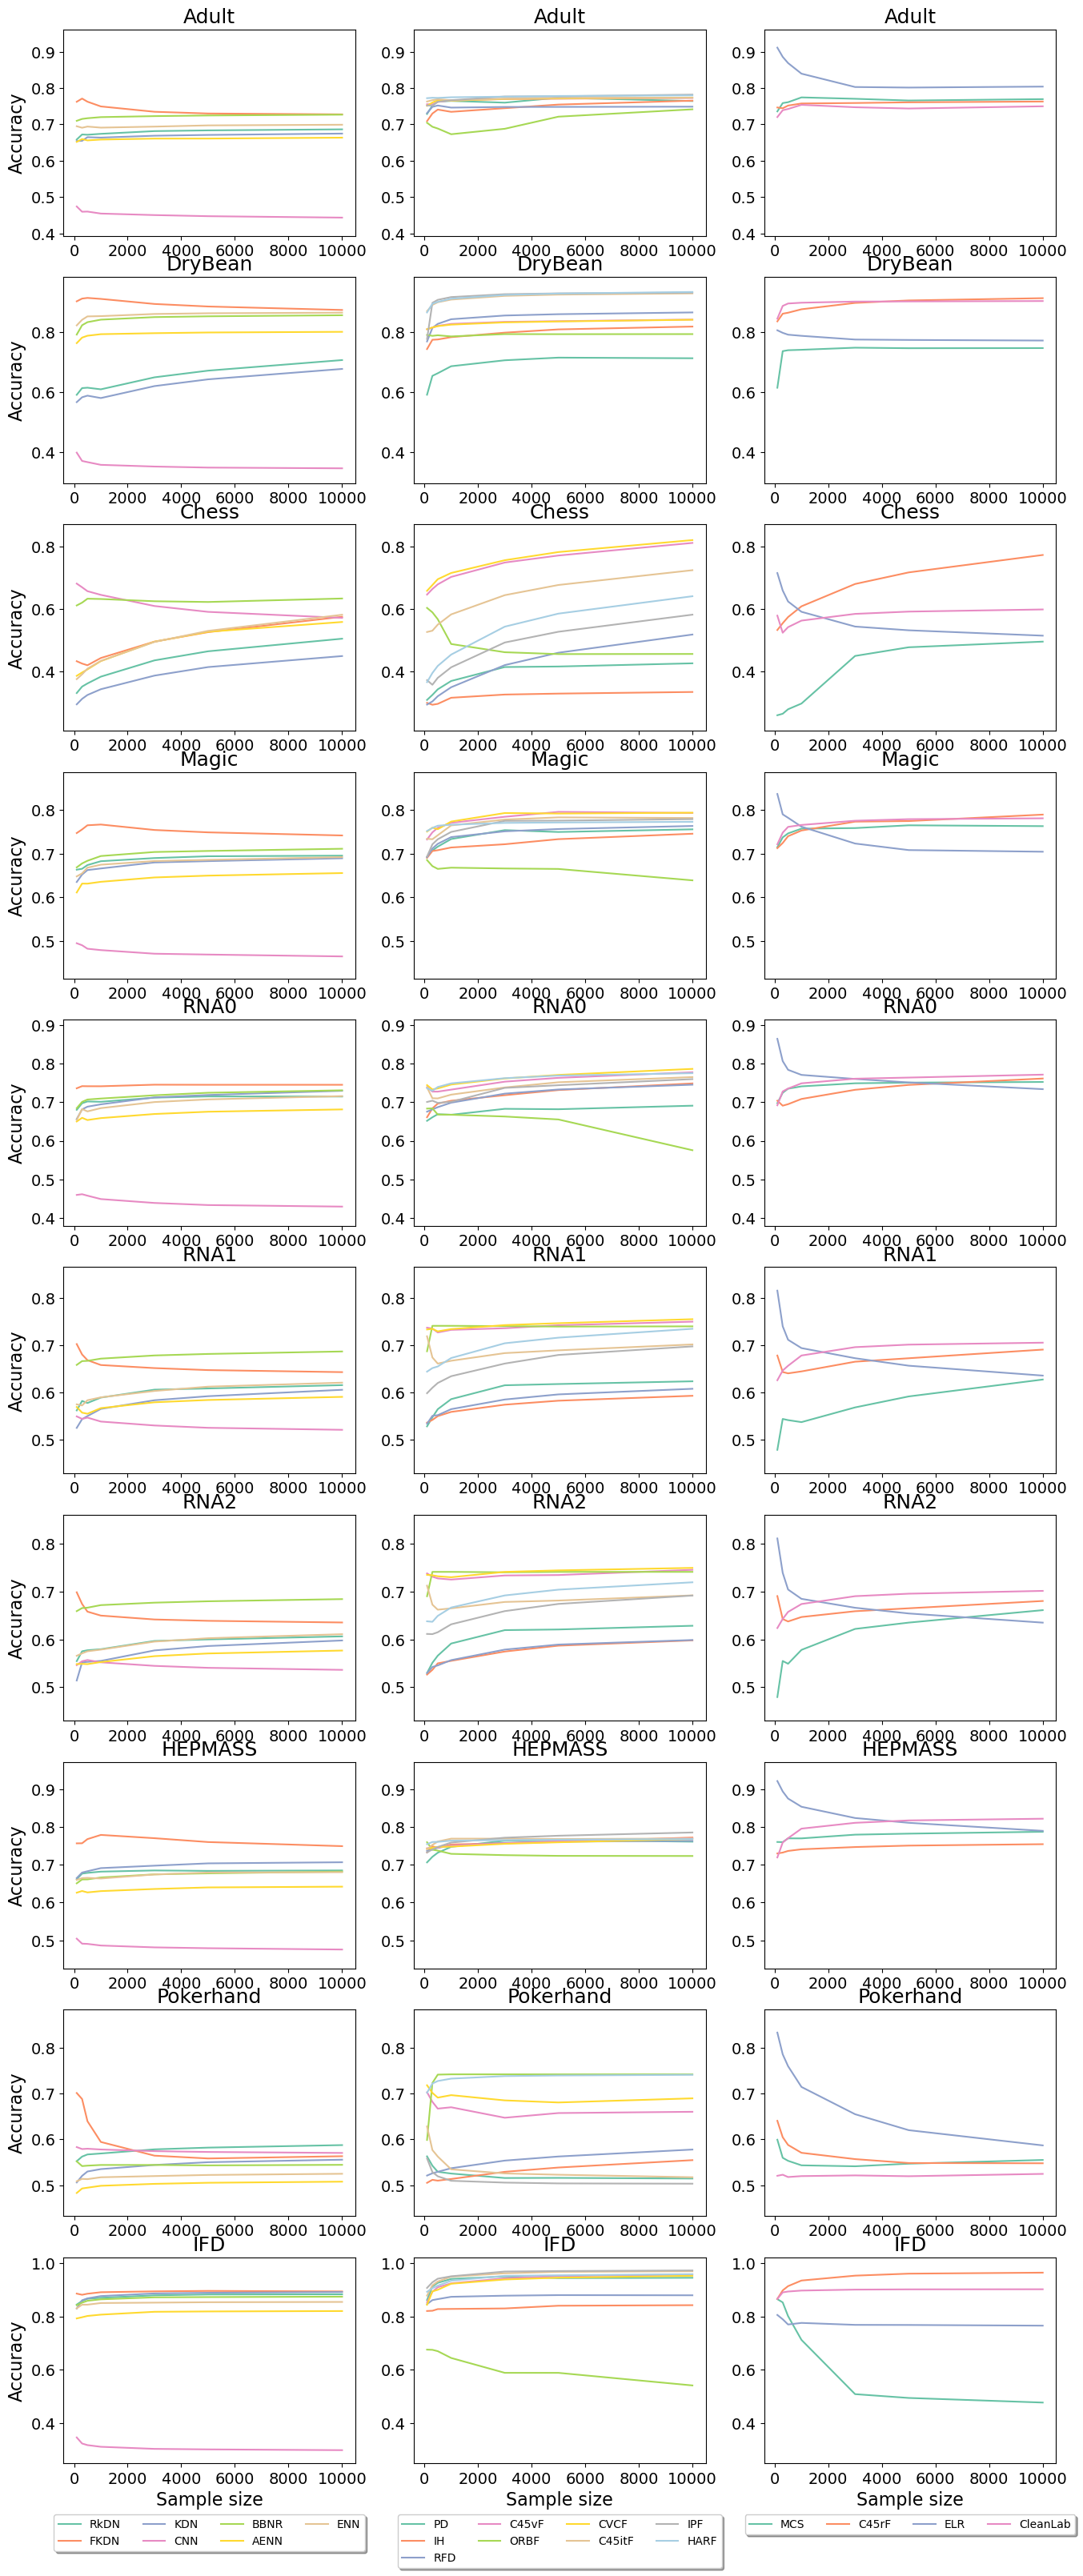

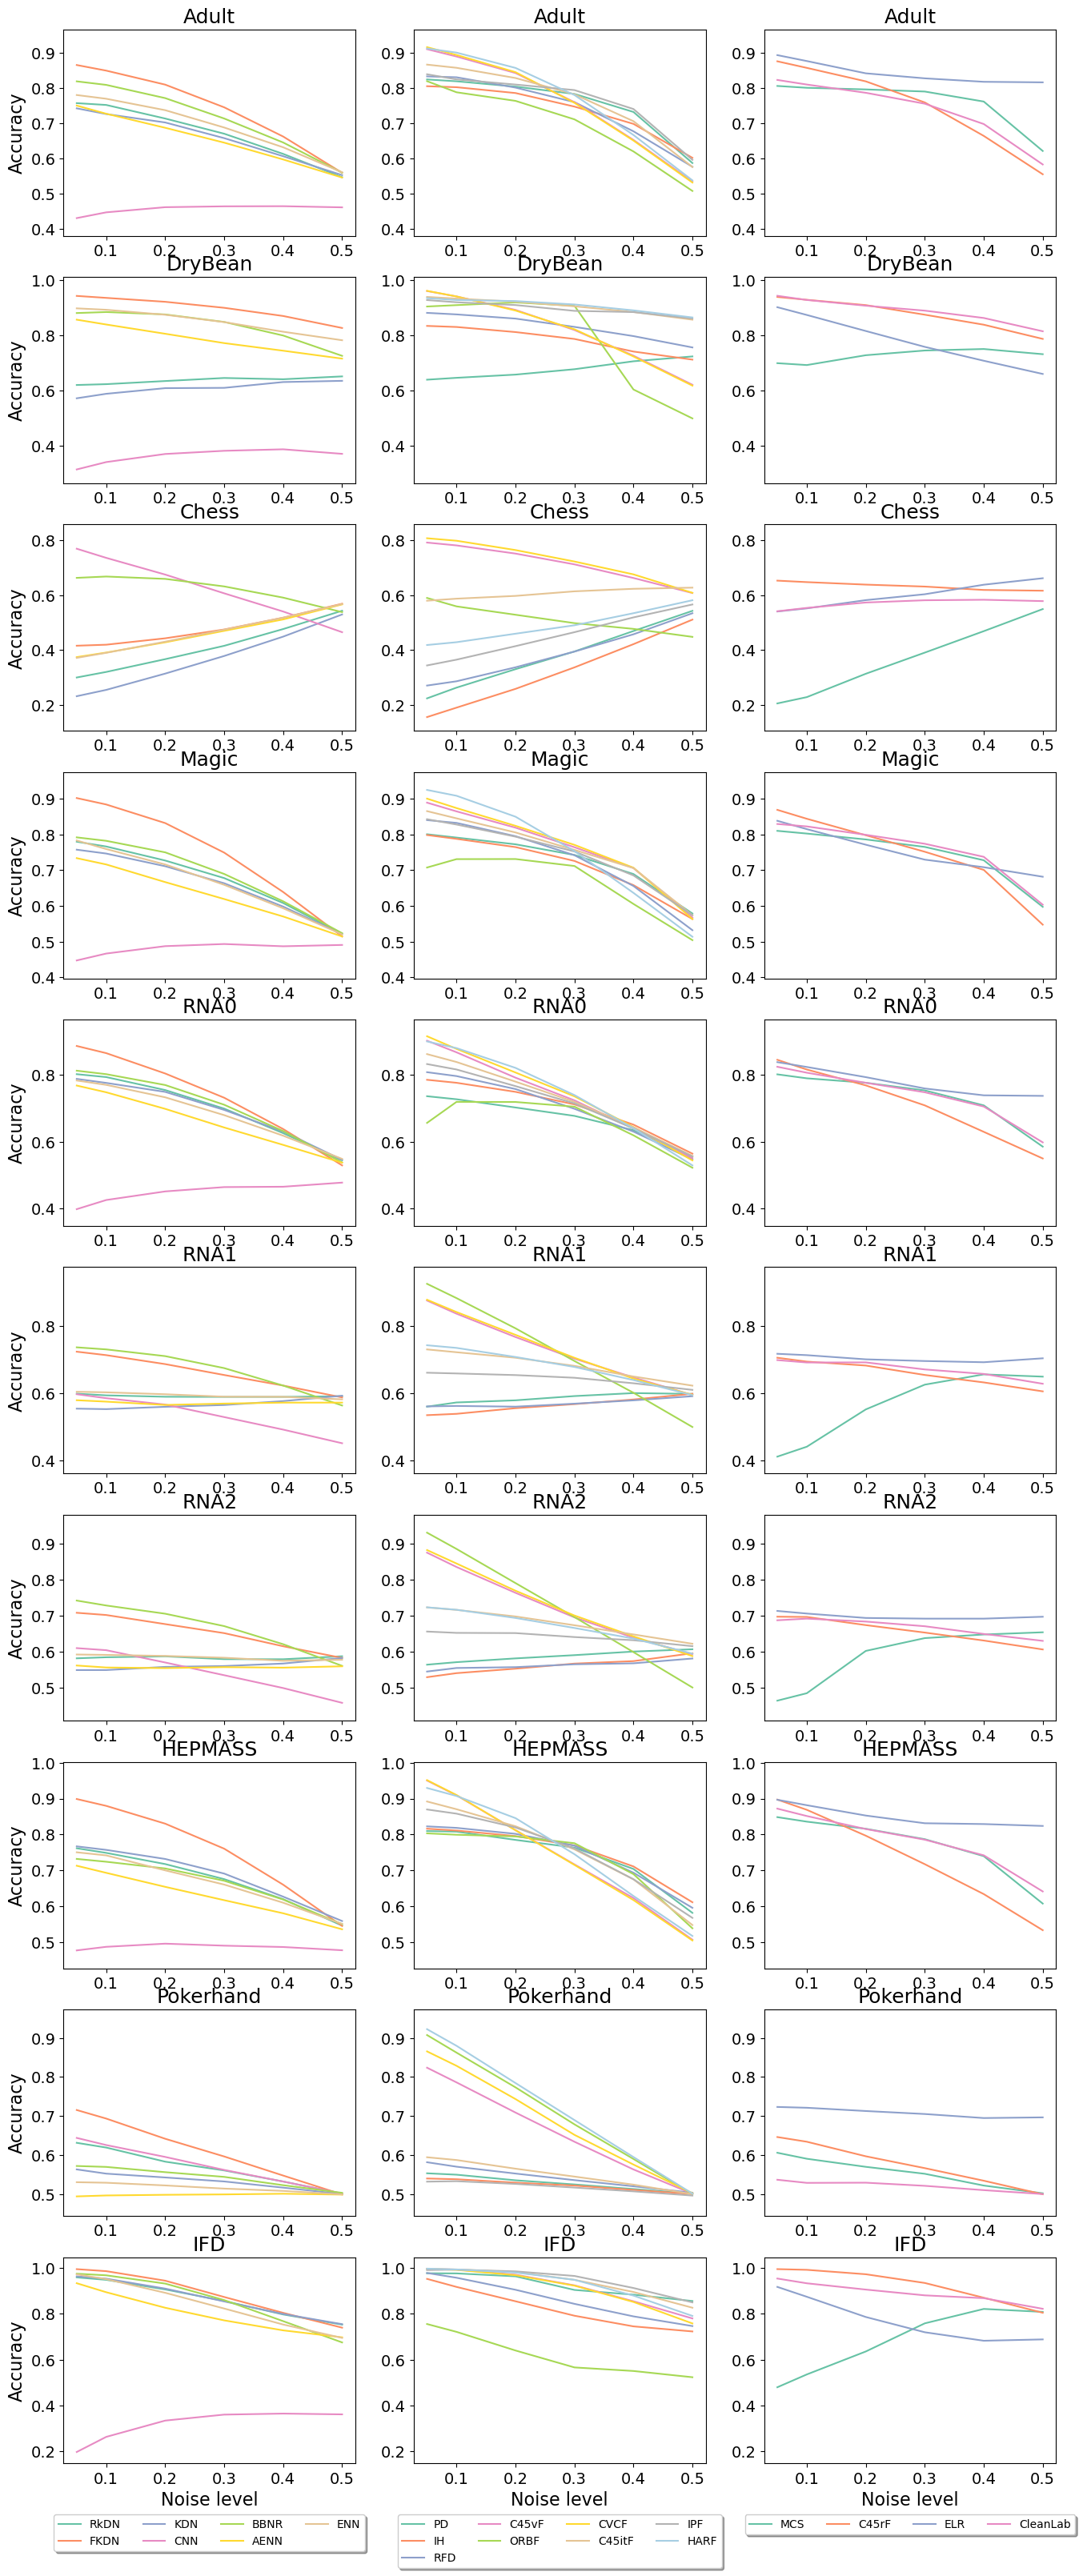

In [75]:

allScores = dfs

di = {'PonOverNoisePerDataset' : [[pon],['NoiseLevel']],
     'PonOverDSPerDataset' : [[pon],['DatasetSize']],

      'RecallOverNoisePerDataset' : [['Recall'],['NoiseLevel']],
      'RecallOverDSPerDataset' : [['Recall'],['DatasetSize']],
      'AccuracyOverDSPerDataset' : [['Accuracy'],['DatasetSize']],
      'AccuracyOverNoisePerDataset' : [['Accuracy'],['NoiseLevel']],
  
}

n = len(datasets)
nn = 3.8*n+2.5
print(nn)
for key in di.keys():
    Score = di[key][0][0]
    variable = di[key][1][0]
    label = labels[variable]
    fig, axs = plt.subplots(n,3,figsize=(16,4*n+2.5))
    fig.set_size_inches(16,3.7*n+2.5, forward=True)


    for j,Dataset in enumerate(datasets[:]):

        scores = allScores[((allScores['Dataset'].str.contains(Dataset)))]
     #   print(len(scores))

        for i,group in enumerate(groups):  
                #print(i)
                models = mod[mod['Group']==group]['Abbreviation']
                lim = scores.groupby(['Model', variable])[Score].mean()
               

                    #plt.figure(figsize=(8,5))
                for model in models[:]:

                    table_ = scores[scores['Model'] == model]

                    if len(table_) > 0:
                        table_ = table_.sort_values([variable])
                        table = pd.DataFrame(table_.groupby(variable).mean(numeric_only = True)).reset_index()
                        axs[j,i].plot(table[variable],table[Score].astype(float),  label = model)

                        if j==n-1: 
                            ncols = 4
                            if group == 'Single':
                                ncols = 4
                            axs[j,i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.22),
                  fancybox=True, shadow=True, ncol=ncols)

                        axs[j,i].set_title("{}".format(Dataset), fontsize = 18 )
                        if j==n-1: 
                            axs[j,i].set_xlabel(label,fontsize = 16 )
                        if i==0:
                            axs[j,i].set_ylabel(Score,fontsize = 16 )
                        #plt.savefig('figures/'+Dataset+Score+noiseType+'.png',transparent=True)
                        axs[j,i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                        axs[j,i].set_ylim(lim.min()-0.05,lim.max()+0.05)
                        axs[j,i].tick_params(axis='both', labelsize=14)
 
  #  plt.subplots_adjust(bottom = 0.15)

    #plt.savefig('figuresNew/'+Score+'_'+variable+'_'+b+'.jpeg',transparent=False#,bbox_inches = 'tight'
    #            , dpi = 300)


#### Comparison of symmetric, asymmetric noise and real aggregated over datasets 

16


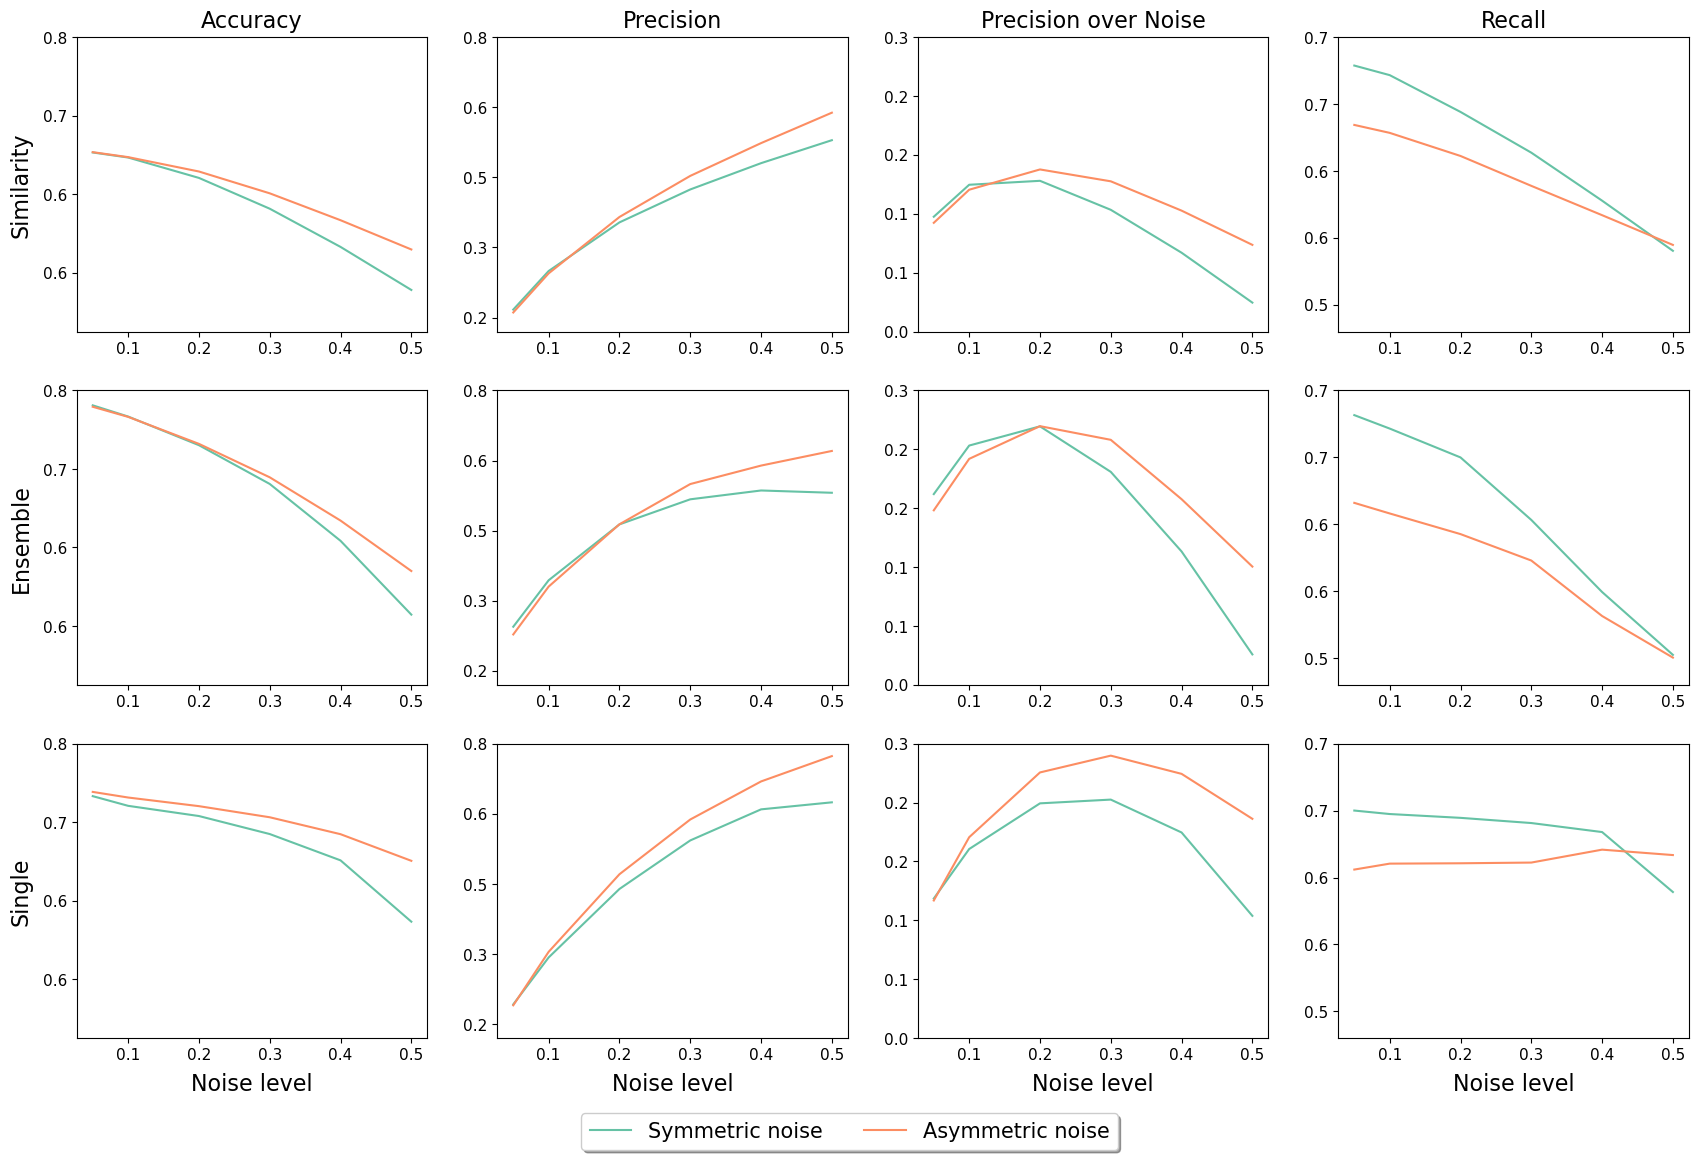

In [76]:

allScores = dfs
clinVarScores = allScores[allScores['Dataset'].isin(['ClinVarReal','ClinVarArt'])]

fs = 14

allNoiseTypes = ["Sym","Asym", "Real"]
twoNoiseTypes = ["Sym","Asym"]


NoiseTypes = allNoiseTypes
n = len(NoiseTypes)


ClinVarLim = [[0.45,0.8],[0,0.9],[-0.2,0.3],[0.2,0.73]]
allLim = [ [0.5,0.8],[0,0.9],[-0.2,0.3],[0.35,0.73]]
allLim = [ [0.5,0.8],[0.12,0.75],[0,0.3],[0.48,0.7]]

diLabels = {'Asym': 'Asymmetric noise',
     'Sym' : 'Symmetric noise'}

scores, variabels = [['Accuracy','Precision',pon, 'Recall'
                     ],['NoiseLevel','NoiseLevel','NoiseLevel','NoiseLevel'
                       ]]

scores1, variabels1 = [['Accuracy','Precision',pon, 'Recall'
                     ],['DatasetSize','DatasetSize','DatasetSize','DatasetSize'
                       ]]

di = {#'NoiseTypeAll': [allScores,allNoiseTypes,ClinVarLim,scores, variabels],
      'NoiseTypeAllW' : [allScores,twoNoiseTypes,allLim,scores, variabels],
      #'NoiseTypeAllWS' : [allScores,twoNoiseTypes,allLim,scores1, variabels1],
    #  'NoiseTypeClinVar' :[clinVarScores,allNoiseTypes,ClinVarLim, scores, variabels]
}

n = 1.3
for key in di.keys():
    li = di[key][3]
 
    fig, axs = plt.subplots(3,len(li),figsize=(4*len(li)*n,10*n))
    print(4*len(li))

    for i,Score in enumerate(li):

        scores_raw = di[key][0]
        NoiseTypes = di[key][1]
        lim = di[key][2]
        variable = di[key][4][i]
        for noiseType in NoiseTypes:
            scores_ =scores_raw[scores_raw['NoiseType'] == noiseType]

            for j,group in enumerate(groups): 

                models = mod[mod['Group']==group]['Abbreviation']
                scores = scores_[scores_['Model'].isin(models)]

                table = scores.groupby(variable).mean(numeric_only = True).reset_index()

                if len(table) > 0:

                    if i==0:
                        axs[j,i].set_ylabel(group,fontsize = fs+2, labelpad = 7 )
                    if j ==0:
                        axs[j,i].set_title("{}".format(Score),fontsize = fs+2 , pad = 7)
                    label = diLabels[noiseType]
                    axs[j,i].plot(table[variable],table[Score].astype(float),  label = label)
                    axs[j,i].tick_params(axis='both', which='major', labelsize=fs-3)
#                    axs[j,i].set_ylabel(group,fontsize = fs )           

                    if (j ==len(groups)-1) : 
                        axs[j,i].set_xlabel(labels[variable],fontsize = fs+2, labelpad = 7 )

                        if (i ==len(li)-1): 
                            axs[j,i].legend( bbox_to_anchor=(-0.6, -0.22),#loc = 'lower center',
              fancybox=True, shadow=True, ncol=2,fontsize = 15 )

                axs[j,i].set_ylim(lim[i])
                axs[j,i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                axs[j,i].yaxis.set_major_locator(MaxNLocator(5)) 


  #  fig.tight_layout()

    name = key+ b + '.jpeg'
    #plt.savefig('figuresNew/' + name,transparent=False,bbox_inches = 'tight', dpi = 300)


#### Pivot table (heatmap) of  model performance vs. sample (Not used in the paper)

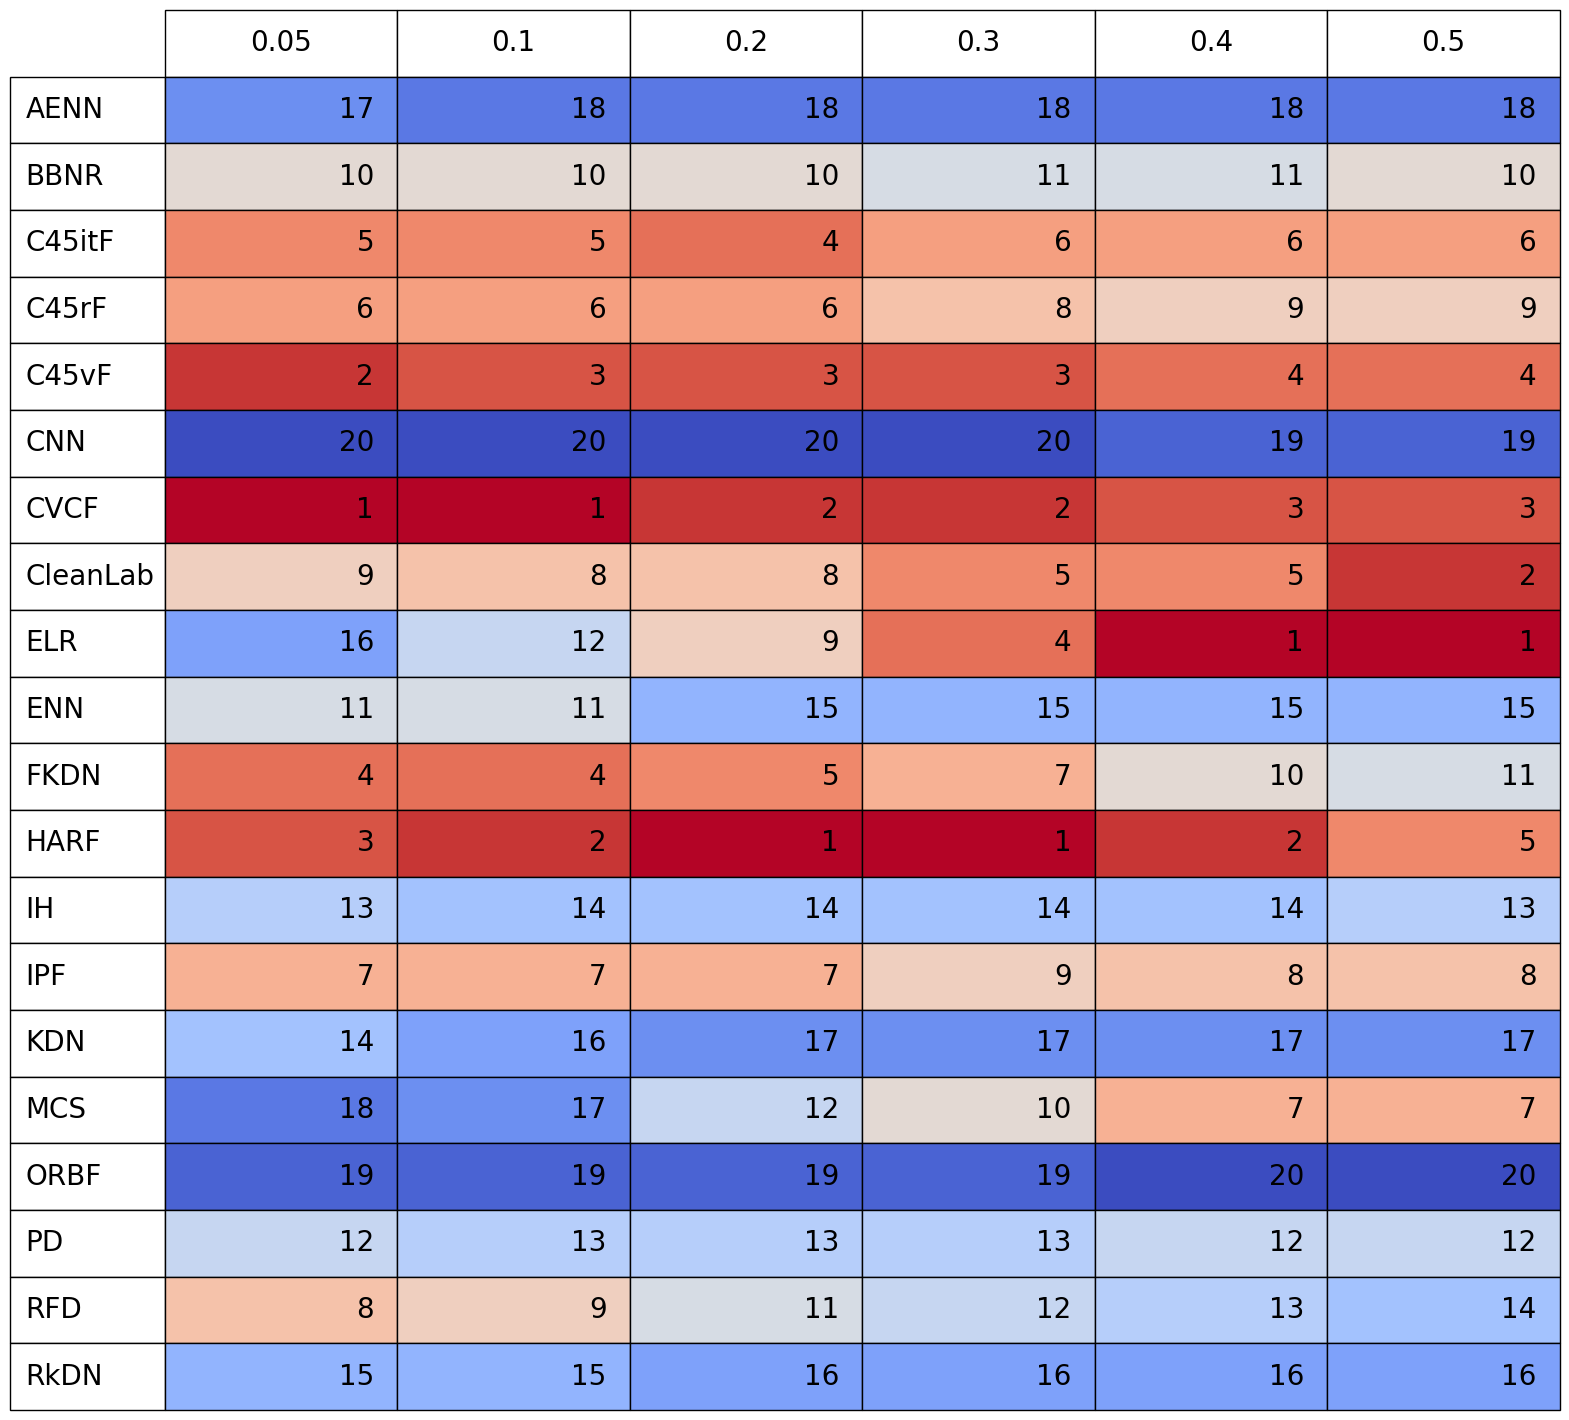

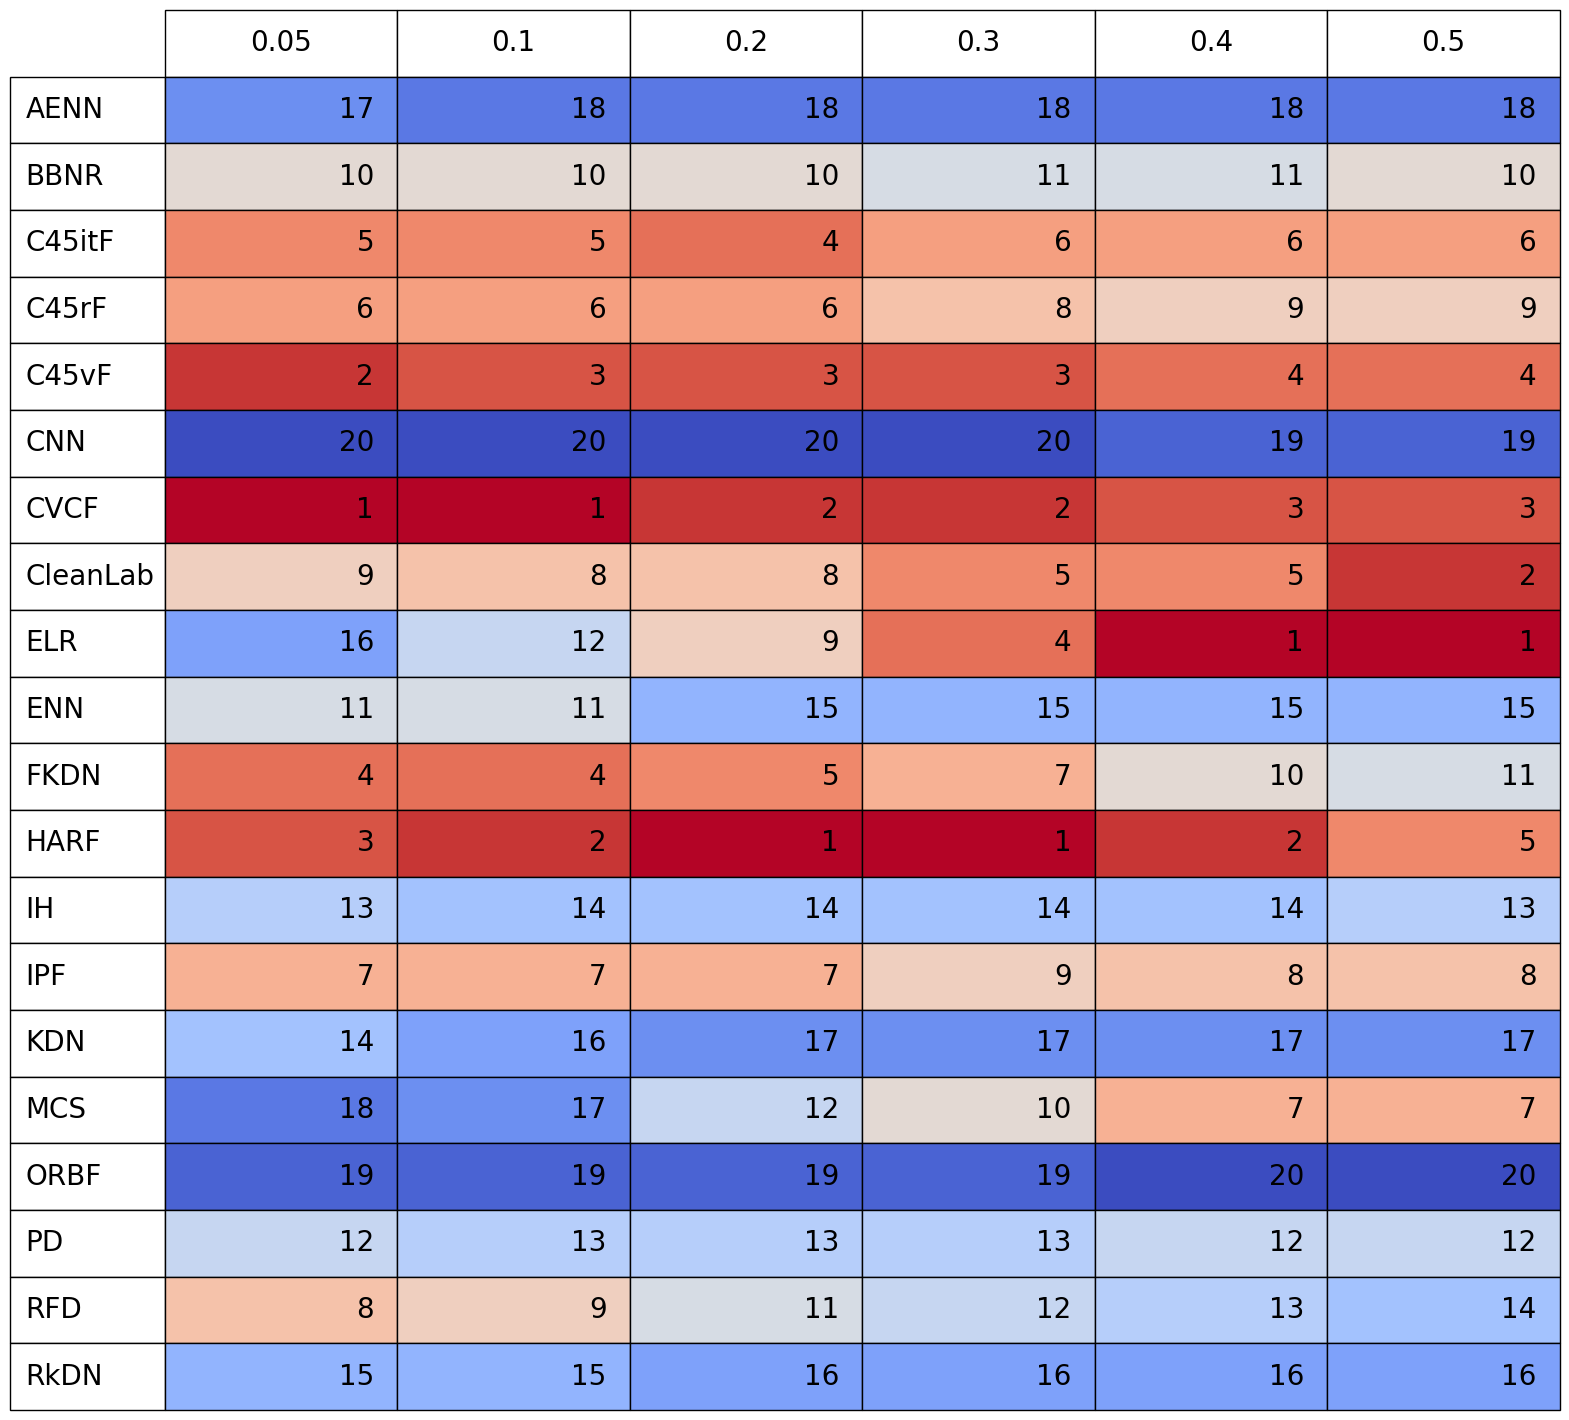

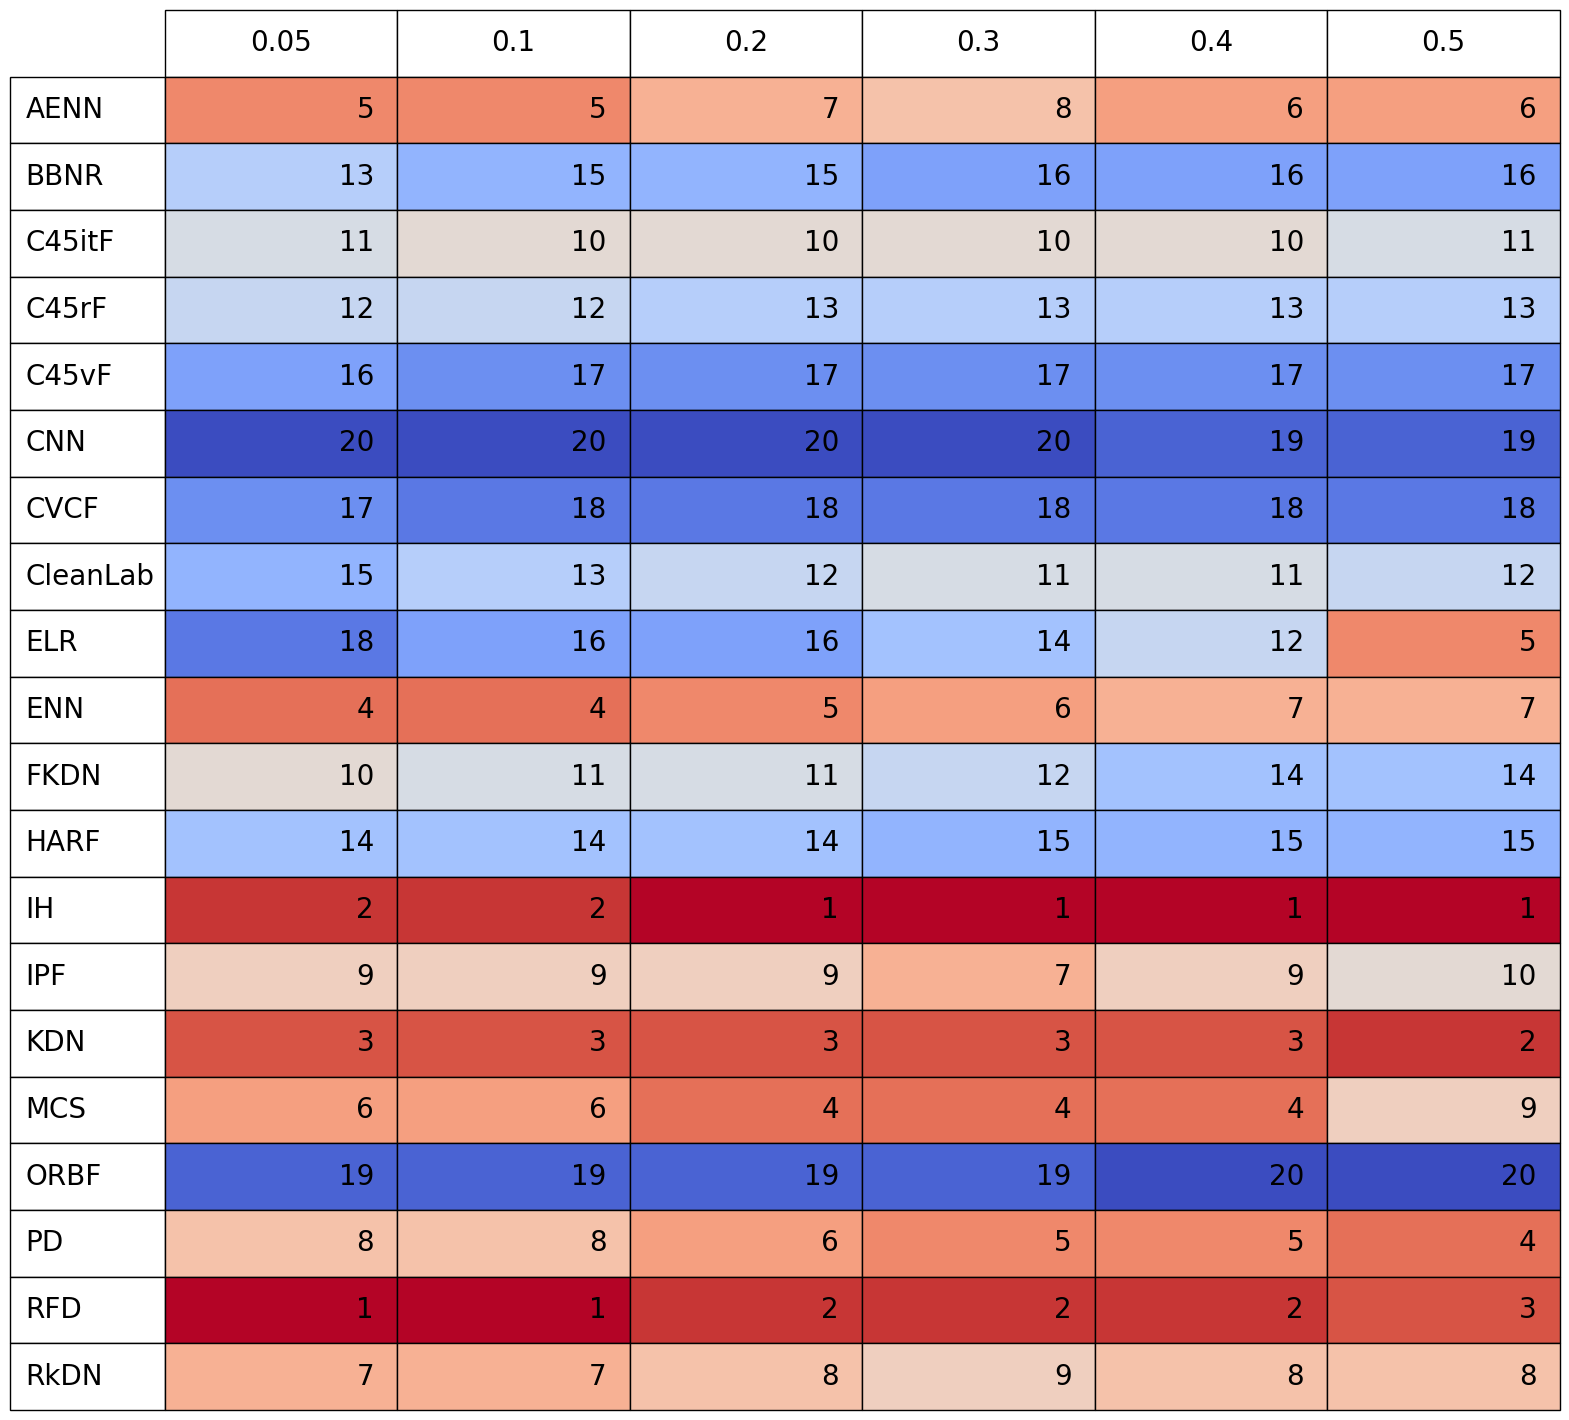

In [77]:
from matplotlib import pyplot as plt
import numpy as np
randn = np.random.randn
from pandas import *


cols = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7]
cols = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5]

#cols = datasets
Score = pon
variable = 'NoiseLevel'
scores, variables = [['Precision',pon, 'Recall'],['NoiseLevel','NoiseLevel','NoiseLevel']]

for i, Score in enumerate(scores):
    variable = variables[i]

    df = allScores.pivot_table(values=Score, index='Model', columns=variable, aggfunc='mean')
    df = df.rank(ascending = False)
    #df.columns = cols
    df= df.astype(float).round(4)
    df= df.astype(int)

    vals = df.values# np.around(df.values,4)
    Min=vals.astype(float).min().min()
    Max=vals.astype(float).max().max()
    norm = plt.Normalize(Min-1, Max+1)
    #norm = plt.Normalize(0, 1)
    cmap = plt.get_cmap('coolwarm_r')

    colours = cmap(norm(vals))

    colores = np.zeros((vals.shape[0], vals.shape[1], 4))
    #cmap = plt.get_cmap('viridis')
    #cmap = plt.get_cmap('hot')

    for i in range(vals.shape[1]):
        col_data = pd.Series(vals[:, i])
        #normal = plt.Normalize(np.min(col_data), np.max(col_data))
        #colores[:, i]  = cmap(norm(col_data))
        a = ((col_data -col_data.min())/(col_data.max() - col_data.min())).to_numpy()
        a = np.ma.masked_array(a)
        colores[:, i] = cmap(a)


    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])

    ytable=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                        colWidths = [0.2]*vals.shape[1]
                      #  colHeights = [0.2]*vals.shape[0]
                        , loc='center', 
                        cellColours=colores)
    ytable.set_fontsize(20)
    ytable.scale(1, 4)
   # fig.tight_layout()

#    plt.savefig('figuresNew/ModelvsDataset'+Score+'_'+b+'.png',transparent=False,bbox_inches = 'tight'                   )

    plt.show()


#### Pivot table (heatmap) of  model performance vs. all averaged scores

In [78]:
li = []
columns=['Accuracy','Precision',pon,'Recall','F-score','Execution Time'
         ]
n = int(len(dfs)*0.8)
for i in range(100):
    dfs_sample = dfs.sample(n = n)
    a = dfs_sample.groupby(['Model']).mean(numeric_only = True)#.reset_index()
    li.append(a[columns])


In [161]:
#pd.DataFrame(np.mean(np.array(li),axis = 0))
li = np.array(li)

li[~np.isnan(li)].mean( axis = 0)

8.53102918261612

Accuracy
Precision
Precision over Noise
Recall
F-score
Execution Time


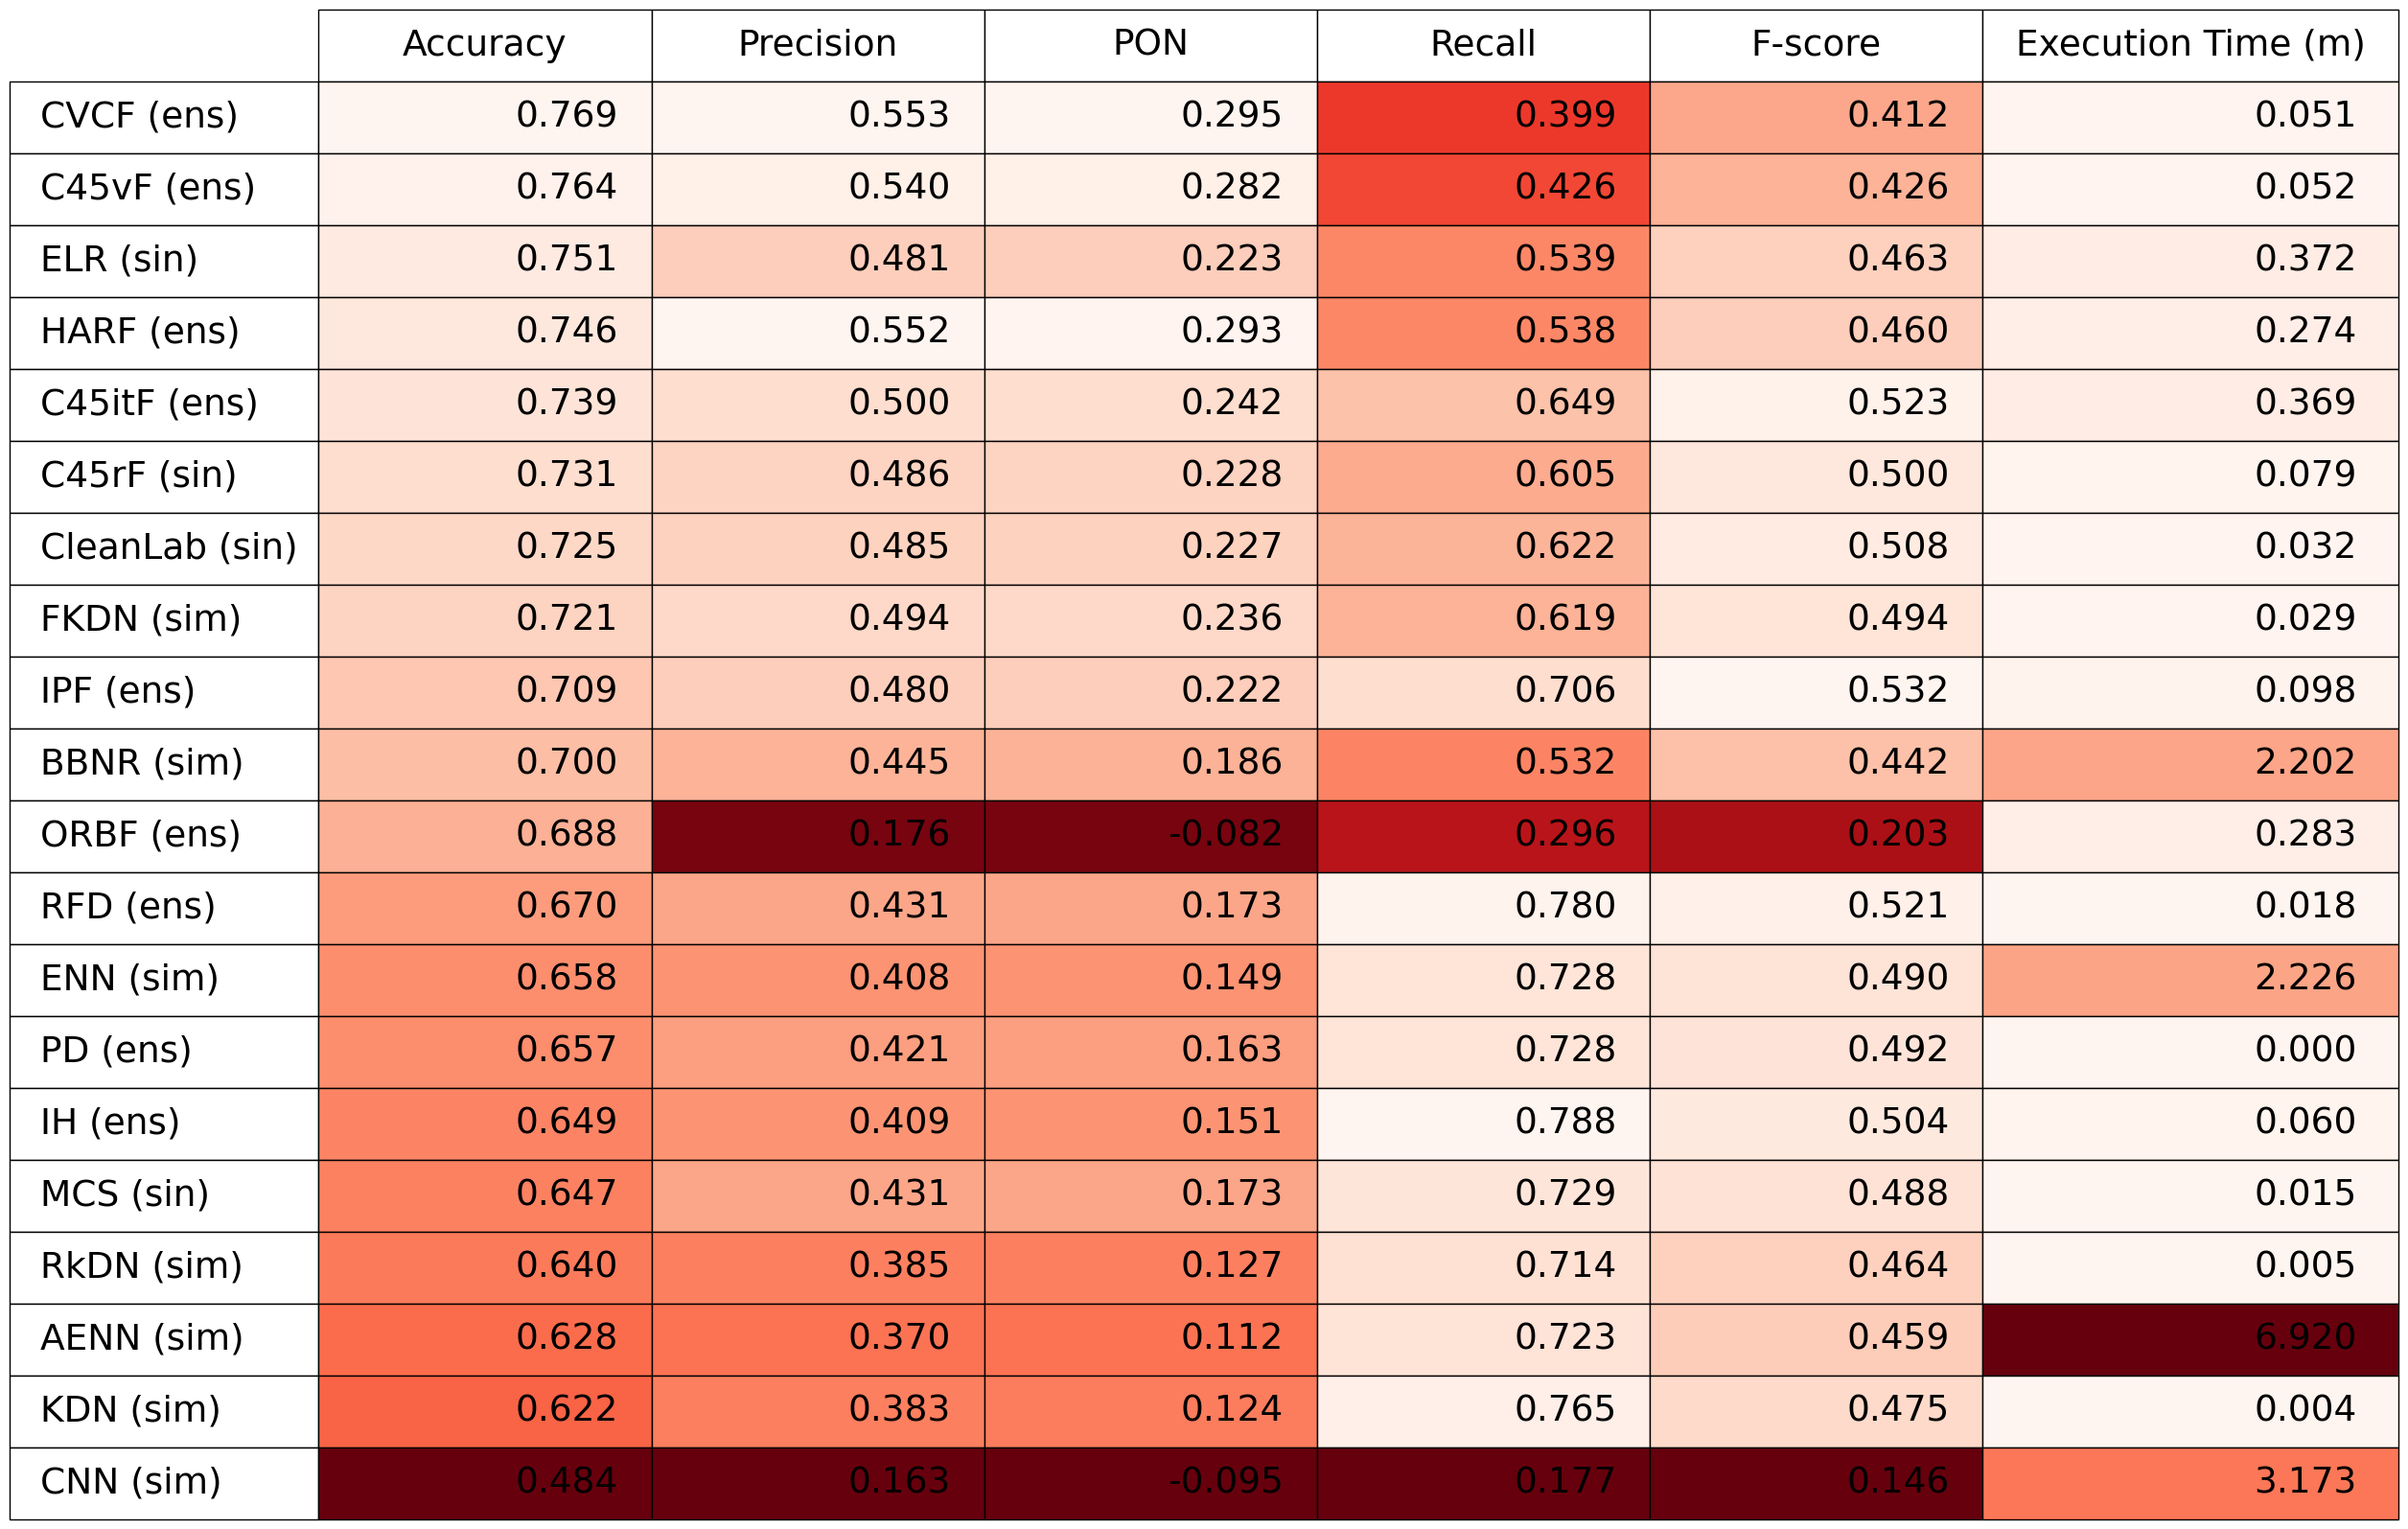

In [79]:
# Exceution time is there only for ClinVar, drop for the analysis over all datasets
import matplotlib.cm as cm
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

a = dfs#[dfs['Group'] =='Ensemble']
columns=['Accuracy','Precision',pon,'Recall','F-score','Execution Time'
         ]
di_Groups = mod[['Abbreviation','Group']].set_index('Abbreviation').to_dict()['Group']



means = dfs.groupby('Model')[columns].mean()

#means = a.groupby('Model').mean()

means['Group'] = means.index
means['Group'] = means['Group'].replace(di)

#means = means.sort_values(['Group','Accuracy'], ascending = True)
means = means.sort_values(['Accuracy'], ascending = False)

means['Execution Time'] = means['Execution Time']/60
fig, ax = plt.subplots(figsize=(28,4))


rows = means.index.to_list()
rows = pd.Series(rows) + ' (' + pd.Series(rows).replace(di_Groups).str[0:3].str.lower() + ')'

conf_data = means[columns].round(3).to_numpy()

#conf_data = pd.DataFrame(conf_data)#.sort_values(4, ascending = False).to_numpy()
conf_data = pd.DataFrame(conf_data).to_numpy()

colores = np.zeros((conf_data.shape[0], conf_data.shape[1], 4))
cmap = plt.get_cmap('viridis')

cmap = plt.get_cmap('Reds').reversed()

for i in range(conf_data.shape[1]):
    print(columns[i])
    
    col_data = pd.Series(conf_data[:, i])
    normal = plt.Normalize(np.min(col_data), np.max(col_data))
    #colores[:, i]  = cmap(norm(col_data))
    a = ((col_data -col_data.min())/(col_data.max() - col_data.min())).to_numpy()
    a = np.ma.masked_array(a)
    if columns[i] in  ['Execution Time','PLR-Inv' ]:
        colores[:, i] =  cmap.reversed()(a)
    else:
        colores[:, i] = cmap(a)


#col_data = pd.Series(conf_data[:, 0])
#a = ((col_data -col_data.min())/(col_data.max() - col_data.min())).to_numpy()
#colores[:, 0] = cmap(a)

columns = pd.Series(columns).replace(pon,'PON').replace('Execution Time','Execution Time (m)')
ax.axis('off')
ax.axis('tight')
conf_data = [['%.3f' % j for j in i] for i in conf_data]
table = ax.table(cellText=conf_data#.round(3)
                 ,
         rowLabels= rows, # "$\\bf{"+ rows+ "}$",
         colLabels= columns, #"$\\bf{"+ columns+ "}$",
         cellColours=colores,
         loc='center',
         colWidths=[0.16, 0.16, 0.16, 0.16, 0.16, 0.2],#[0.16]*len(columns),
        #colWidths=[0.2,0.2,0.2,0.2,0.2,0.2],#[0.16]*len(columns),

                 
        )
table.auto_set_font_size(False)
table.set_fontsize(27)
table.scale(1, 4.5)

# fig.tight_layout()
#plt.savefig('figuresNew/heatmap_table_means_over_everything'+b+'.jpeg',transparent=False,bbox_inches = 'tight'
#                       , dpi = 300)

plt.show()

In [ ]:
conf_data = means[columns].round(3)
conf_data['Execution Time'] = conf_data['Execution Time']/60


conf_data.to_latex('tablesNew/ClinVarHeatmap.tex',index=True, escape=False,
                  caption = 'ClinVar Performance', label = 'table:OverallPerformanceClinVar', 
                  bold_rows = True,  sparsify = True)


#### Correcring latex table

In [ ]:
df = pd.read_csv('latexTable.txt',sep = '&', header = None)
df[0] = df[0].str.replace('\%', '').str.strip()
drop = ['classifSF' , 'hybridRF','saturationFilter', 'PF', 'dynamicCF','consensusSF', 'GE']
ind = df[df[0].isin(drop)].index

df[0] = '\\textbf{'+df[0]+'}'
df.iloc[ind, 0] = '%' + df.iloc[ind, 0]


In [ ]:
df = df.sort_values([1,0], ascending = True,key=lambda col: col.str.lower())

In [ ]:
df.to_csv('latextTable_done.txt',sep = '&', index = False, header = False)